In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor

In [9]:
# org_QM9 = pd.read_csv('QM9_dataset_preprocessed.csv')
org_QM9 = pd.read_csv('/media/omid/HDD2/QM9_sci/QM9_processed.csv')
org_QM9.head()

ID SMILES    mu  alpha  homo  lumo  gap    r2  zpve    cv   u0  \
0  Comp000001      C -1.70  -5.14 -5.55  1.97 4.74 -3.37 -2.28 -4.32 6.61   
1  Comp000002      N -0.56  -5.57 -0.34  1.28 1.45 -3.41 -2.61 -4.35 6.23   
2  Comp000003      O -0.40  -5.94 -1.77  1.00 1.88 -3.45 -3.02 -4.43 5.76   
3  Comp000004    C#C -1.70  -4.79 -1.44  0.64 1.36 -3.26 -2.84 -3.82 5.74   
4  Comp000005    C#N  0.33  -5.17 -4.46  0.00 2.24 -3.31 -3.17 -4.36 5.36   

   u298  h298  g298 canonical_SMILES scaffold_smiles  
0  6.61  6.61  6.61                C             NaN  
1  6.23  6.23  6.23                N             NaN  
2  5.76  5.76  5.76                O             NaN  
3  5.74  5.74  5.74              C#C             NaN  
4  5.36  5.36  5.36              C#N             NaN

In [52]:
org_QM9.columns, org_QM9.shape

(Index(['ID', 'SMILES', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve',
        'cv', 'u0', 'u298', 'h298', 'g298', 'canonical_SMILES',
        'scaffold_smiles'],
       dtype='object'),
 (132480, 16))

In [111]:
# Drop 'scaffold_smiles'
org_QM9.drop(columns=['scaffold_smiles'], inplace=True)

In [10]:
selected_smiles_na = pd.read_csv('/media/omid/HDD2/QM9_sci/QM9_3D_PySCF_Collected_MD.csv')
selected_smiles_na.head()

ID        File Name canonical_SMILES  LogP  SASA (Å²)  Volume (Å³)  \
0  Comp000001  molecule_000001                C  0.64     141.99        16.03   
1  Comp000002  molecule_000002                N  0.16     133.45        17.03   
2  Comp000003  molecule_000003                O -0.16     214.28        22.04   
3  Comp000004  molecule_000004              C#C  0.25     152.38        26.02   
4  Comp000005  molecule_000005              C#N  0.14     143.24        27.01   

   ECI  Steric Hindrance  Dipole Moment (Debye)  HOMO Energy (Hartree)  \
0 0.00             10.93                  -1.70                  -5.55   
1 0.00              7.66                  -0.56                  -0.34   
2 0.00              4.43                  -0.40                  -1.77   
3 2.00              7.13                  -1.70                  -1.44   
4 2.00              4.55                   0.33                  -4.46   

   LUMO Energy (Hartree)  Electrophilicity Index scaffold_smiles  
0                   1.97                   -0.19             NaN  
1                   1.28                   -0.10             NaN  
2                   1.00                   -0.03             NaN  
3                   0.64                   -0.69             NaN  
4                   0.00                   -0.01             NaN

In [113]:
selected_smiles_na.columns, selected_smiles_na.shape

(Index(['ID', 'File Name', 'canonical_SMILES', 'LogP', 'SASA (Å²)',
        'Volume (Å³)', 'ECI', 'Steric Hindrance', 'Dipole Moment (Debye)',
        'HOMO Energy (Hartree)', 'LUMO Energy (Hartree)',
        'Electrophilicity Index', 'scaffold_smiles'],
       dtype='object'),
 (132480, 13))

In [114]:
# Drop 'File Name', 'Dipole Moment (Debye)', 'HOMO Energy (Hartree)','LUMO Energy (Hartree)', and'Electrophilicity Index'
selected_smiles_na.drop(columns=['File Name', 'canonical_SMILES', 'LogP', 'Dipole Moment (Debye)',
                                 'HOMO Energy (Hartree)', 'LUMO Energy (Hartree)',
                                 'Electrophilicity Index', 'scaffold_smiles'], inplace=True)

In [115]:
# Check common columns for merging
common_identifier = "ID"

# Merge datasets on the common identifier
combined_data = pd.merge(org_QM9, selected_smiles_na, on=common_identifier)
combined_data

ID                                             SMILES    mu  \
0       Comp000001                                                  C -1.70   
1       Comp000002                                                  N -0.56   
2       Comp000003                                                  O -0.40   
3       Comp000004                                                C#C -1.70   
4       Comp000005                                                C#N  0.33   
...            ...                                                ...   ...   
132475  Comp132476  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34 -0.71   
132476  Comp132477  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54 -0.11   
132477  Comp132478  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...  0.45   
132478  Comp132479  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34  0.71   
132479  Comp132480  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...  0.57   

        alpha  homo  lumo   gap    r2  zpve    cv    u0  u298  h298  g298  \
0       -5.14 -5.55  1.97  4.74 -3.37 -2.28 -4.32  6.61  6.61  6.61  6.61   
1       -5.57 -0.34  1.28  1.45 -3.41 -2.61 -4.35  6.23  6.23  6.23  6.23   
2       -5.94 -1.77  1.00  1.88 -3.45 -3.02 -4.43  5.76  5.76  5.76  5.76   
3       -4.79 -1.44  0.64  1.36 -3.26 -2.84 -3.82  5.74  5.74  5.74  5.74   
4       -5.17 -4.46  0.00  2.24 -3.31 -3.17 -4.36  5.36  5.36  5.36  5.36   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
132475  -0.70 -3.10 -0.71  0.84  0.47 -1.24 -0.05 -0.43 -0.43 -0.43 -0.43   
132476   0.70 -0.14 -0.93 -0.86  0.94  0.15  0.96  0.29  0.29  0.29  0.29   
132477   0.06 -0.98 -1.22 -0.73  0.62 -0.17  0.43 -0.09 -0.09 -0.09 -0.09   
132478   0.38 -0.13 -0.00  0.06  0.57 -0.17  0.60 -0.08 -0.08 -0.08 -0.08   
132479  -0.17 -0.91 -0.40  0.05  0.45 -0.50  0.13 -0.46 -0.46 -0.46 -0.46   

                                         canonical_SMILES  SASA (Å²)  \
0                                                       C     141.99   
1                                                       N     133.45   
2                                                       O     214.28   
3                                                     C#C     152.38   
4                                                     C#N     143.24   
...                                                   ...        ...   
132475  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34     291.07   
132476  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54     280.97   
132477  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...     288.51   
132478  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34     290.60   
132479  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...     279.14   

        Volume (Å³)   ECI  Steric Hindrance  
0             16.03  0.00             10.93  
1             17.03  0.00              7.66  
2             22.04  0.00              4.43  
3             26.02  2.00              7.13  
4             27.01  2.00              4.55  
...             ...   ...               ...  
132475       120.08 68.00             78.79  
132476       120.06 68.00             70.47  
132477       122.08 68.00             79.04  
132478       120.08 68.00             79.93  
132479       122.06 68.00             71.62  

[132480 rows x 19 columns]

In [116]:
combined_data.columns

Index(['ID', 'SMILES', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve',
       'cv', 'u0', 'u298', 'h298', 'g298', 'canonical_SMILES', 'SASA (Å²)',
       'Volume (Å³)', 'ECI', 'Steric Hindrance'],
      dtype='object')

In [117]:
combined_data.isna().sum()

ID                     0
SMILES                 0
mu                     0
alpha                  0
homo                   0
lumo                   0
gap                    0
r2                     0
zpve                   0
cv                     0
u0                     0
u298                   0
h298                   0
g298                   0
canonical_SMILES       5
SASA (Å²)           3179
Volume (Å³)            1
ECI                    0
Steric Hindrance       1
dtype: int64

In [96]:
# Filter rows where 'SASA (Å²)' is NaN
nan_rows = selected_smiles_na[selected_smiles_na['canonical_SMILES'].isna()].ID

# Display the rows with NaN values in 'SASA (Å²)'
print(nan_rows)

123614    Comp123615
123710    Comp123711
127628    Comp127629
127920    Comp127921
127921    Comp127922
Name: ID, dtype: object


In [118]:
selected_smiles = combined_data.dropna()
selected_smiles.reset_index(drop=True, inplace=True)
selected_smiles

ID                                             SMILES    mu  \
0       Comp000001                                                  C -1.70   
1       Comp000002                                                  N -0.56   
2       Comp000003                                                  O -0.40   
3       Comp000004                                                C#C -1.70   
4       Comp000005                                                C#N  0.33   
...            ...                                                ...   ...   
129291  Comp132476  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34 -0.71   
129292  Comp132477  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54 -0.11   
129293  Comp132478  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...  0.45   
129294  Comp132479  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34  0.71   
129295  Comp132480  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...  0.57   

        alpha  homo  lumo   gap    r2  zpve    cv    u0  u298  h298  g298  \
0       -5.14 -5.55  1.97  4.74 -3.37 -2.28 -4.32  6.61  6.61  6.61  6.61   
1       -5.57 -0.34  1.28  1.45 -3.41 -2.61 -4.35  6.23  6.23  6.23  6.23   
2       -5.94 -1.77  1.00  1.88 -3.45 -3.02 -4.43  5.76  5.76  5.76  5.76   
3       -4.79 -1.44  0.64  1.36 -3.26 -2.84 -3.82  5.74  5.74  5.74  5.74   
4       -5.17 -4.46  0.00  2.24 -3.31 -3.17 -4.36  5.36  5.36  5.36  5.36   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
129291  -0.70 -3.10 -0.71  0.84  0.47 -1.24 -0.05 -0.43 -0.43 -0.43 -0.43   
129292   0.70 -0.14 -0.93 -0.86  0.94  0.15  0.96  0.29  0.29  0.29  0.29   
129293   0.06 -0.98 -1.22 -0.73  0.62 -0.17  0.43 -0.09 -0.09 -0.09 -0.09   
129294   0.38 -0.13 -0.00  0.06  0.57 -0.17  0.60 -0.08 -0.08 -0.08 -0.08   
129295  -0.17 -0.91 -0.40  0.05  0.45 -0.50  0.13 -0.46 -0.46 -0.46 -0.46   

                                         canonical_SMILES  SASA (Å²)  \
0                                                       C     141.99   
1                                                       N     133.45   
2                                                       O     214.28   
3                                                     C#C     152.38   
4                                                     C#N     143.24   
...                                                   ...        ...   
129291  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34     291.07   
129292  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54     280.97   
129293  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...     288.51   
129294  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34     290.60   
129295  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...     279.14   

        Volume (Å³)   ECI  Steric Hindrance  
0             16.03  0.00             10.93  
1             17.03  0.00              7.66  
2             22.04  0.00              4.43  
3             26.02  2.00              7.13  
4             27.01  2.00              4.55  
...             ...   ...               ...  
129291       120.08 68.00             78.79  
129292       120.06 68.00             70.47  
129293       122.08 68.00             79.04  
129294       120.08 68.00             79.93  
129295       122.06 68.00             71.62  

[129296 rows x 19 columns]

In [119]:
selected_smiles.isna().sum()

ID                  0
SMILES              0
mu                  0
alpha               0
homo                0
lumo                0
gap                 0
r2                  0
zpve                0
cv                  0
u0                  0
u298                0
h298                0
g298                0
canonical_SMILES    0
SASA (Å²)           0
Volume (Å³)         0
ECI                 0
Steric Hindrance    0
dtype: int64

In [128]:
# selected_smiles.to_csv('/media/omid/HDD2/QM9_sci/16_3D_MD_QM9.csv', index=False)

In [126]:
selected_smiles_columns = selected_smiles[['ID', 'canonical_SMILES']]
selected_smiles_columns.shape

(129296, 2)

In [127]:
selected_smiles_columns.isna().sum()

ID                  0
canonical_SMILES    0
dtype: int64

## Calculate 2D Molecular Descriptors using RDkit

In [86]:
# Another method to calculate 2D MD
# def RDkit_descriptors(smiles):
#     mols = [Chem.MolFromSmiles(i) for i in smiles] 
    
#     Mol_descriptors = []
#     for mol in mols:
#         # Add hydrogens to molecules
#         # mol = Chem.AddHs(mol)
        
#         # Calculate all descriptors for each molecule
#         descriptors = {}
#         for descriptor_name, descriptor_func in Descriptors._descList:
#             try:
#                 result = descriptor_func(mol)
#                 descriptors[descriptor_name] = result
#             except Exception as e:
#                 descriptors[descriptor_name] = None
#                 print(f"Failed to calculate {descriptor_name}: {str(e)}")
        
#         # Add the SMILES string to the descriptor dictionary
#         descriptors['SMILES'] = Chem.MolToSmiles(mol)
#         Mol_descriptors.append(descriptors)

#     # Create a DataFrame from the list of descriptor dictionaries
#     df_descriptors = pd.DataFrame(Mol_descriptors)

#     # Resetting the index to be numerical
#     df_descriptors.reset_index(drop=True, inplace=True)
    
#     return df_descriptors

# # Function call with a subset of SMILES
# df_descriptors = RDkit_descriptors(selected_smiles_columns['canonical_SMILES'][100:102])
# df_descriptors


In [121]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        # mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors, desc_names = RDkit_descriptors(selected_smiles_columns['canonical_SMILES'])

In [122]:
len(desc_names)

208

In [124]:
df_208_2D_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
# df_208_2D_descriptors.to_csv('/media/omid/HDD2/QM9_sci/208_2D_MD_QM9.csv', index=False)
df_208_2D_descriptors

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0                 0.00            0.00               0.00               0.00   
1                 0.00            0.00               0.00               0.00   
2                 0.00            0.00               0.00               0.00   
3                 4.00            4.00               4.00               4.00   
4                 6.50            3.50               6.50               3.50   
...                ...             ...                ...                ...   
129291            2.09            0.96               2.09               0.96   
129292            5.92            0.55               5.92               0.55   
129293            2.01            0.97               2.01               0.97   
129294            2.03            1.01               2.03               1.01   
129295            5.90            0.51               5.90               0.51   

        qed  MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.36  16.04           12.01       16.03                    8   
1      0.40  17.03           14.01       17.03                    8   
2      0.33  18.02           16.00       18.01                    8   
3      0.33  26.04           24.02       26.02                   10   
4      0.37  27.03           26.02       27.01                   10   
...     ...    ...             ...         ...                  ...   
129291 0.42 120.17          110.09      120.08                   46   
129292 0.46 120.15          112.09      120.06                   46   
129293 0.31 122.17          112.09      122.08                   46   
129294 0.41 120.17          110.09      120.08                   46   
129295 0.39 122.15          114.08      122.06                   46   

        NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                         0  ...           0             0           0   
1                         0  ...           0             0           0   
2                         0  ...           0             0           0   
3                         0  ...           0             0           0   
4                         0  ...           0             0           0   
...                     ...  ...         ...           ...         ...   
129291                    0  ...           0             0           0   
129292                    0  ...           0             0           0   
129293                    0  ...           0             0           0   
129294                    0  ...           0             0           0   
129295                    0  ...           0             0           0   

        fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                       0             0            0            0   
1                       0             0            0            0   
2                       0             0            0            0   
3                       1             0            0            0   
4                       0             0            0            0   
...                   ...           ...          ...          ...   
129291                  0             0            0            0   
129292                  0             0            0            0   
129293                  0             0            0            0   
129294                  0             0            0            0   
129295                  0             0            0            0   

        fr_thiophene  fr_unbrch_alkane  fr_urea  
0                  0                 0        0  
1                  0                 0        0  
2                  0                 0        0  
3                  0                 0        0  
4                  0                 0        0  
...              ...               ...      ...  
129291             0                 0        0  
129292             0                 0        0  
129293             0      

In [125]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

# Get the names of all descriptors
descriptor_names = calc.GetDescriptorNames()

# Print all descriptor names
for name in descriptor_names:
    print(name)

MaxEStateIndex
MinEStateIndex
MaxAbsEStateIndex
MinAbsEStateIndex
qed
MolWt
HeavyAtomMolWt
ExactMolWt
NumValenceElectrons
NumRadicalElectrons
MaxPartialCharge
MinPartialCharge
MaxAbsPartialCharge
MinAbsPartialCharge
FpDensityMorgan1
FpDensityMorgan2
FpDensityMorgan3
BCUT2D_MWHI
BCUT2D_MWLOW
BCUT2D_CHGHI
BCUT2D_CHGLO
BCUT2D_LOGPHI
BCUT2D_LOGPLOW
BCUT2D_MRHI
BCUT2D_MRLOW
BalabanJ
BertzCT
Chi0
Chi0n
Chi0v
Chi1
Chi1n
Chi1v
Chi2n
Chi2v
Chi3n
Chi3v
Chi4n
Chi4v
HallKierAlpha
Ipc
Kappa1
Kappa2
Kappa3
LabuteASA
PEOE_VSA1
PEOE_VSA10
PEOE_VSA11
PEOE_VSA12
PEOE_VSA13
PEOE_VSA14
PEOE_VSA2
PEOE_VSA3
PEOE_VSA4
PEOE_VSA5
PEOE_VSA6
PEOE_VSA7
PEOE_VSA8
PEOE_VSA9
SMR_VSA1
SMR_VSA10
SMR_VSA2
SMR_VSA3
SMR_VSA4
SMR_VSA5
SMR_VSA6
SMR_VSA7
SMR_VSA8
SMR_VSA9
SlogP_VSA1
SlogP_VSA10
SlogP_VSA11
SlogP_VSA12
SlogP_VSA2
SlogP_VSA3
SlogP_VSA4
SlogP_VSA5
SlogP_VSA6
SlogP_VSA7
SlogP_VSA8
SlogP_VSA9
TPSA
EState_VSA1
EState_VSA10
EState_VSA11
EState_VSA2
EState_VSA3
EState_VSA4
EState_VSA5
EState_VSA6
EState_VSA7
EState

In [129]:
df_208_2D_descriptors.isna().sum()

MaxEStateIndex       0
MinEStateIndex       0
MaxAbsEStateIndex    0
MinAbsEStateIndex    0
qed                  0
                    ..
fr_thiazole          0
fr_thiocyan          0
fr_thiophene         0
fr_unbrch_alkane     0
fr_urea              0
Length: 208, dtype: int64

In [130]:
df_208_2D_descriptors.shape, selected_smiles_columns.shape

((129296, 208), (129296, 2))

## Apply 'ID' and 'canonical_SMILES' to 208 2D RDKit MD

In [131]:
# Concatenate 'ID', 'File Name', 'canonical_SMILES' to 208 2D MD
df_208_2D_descriptors_SMILES = pd.concat([selected_smiles_columns, df_208_2D_descriptors], axis=1)
df_208_2D_descriptors_SMILES

ID                                   canonical_SMILES  \
0       Comp000001                                                  C   
1       Comp000002                                                  N   
2       Comp000003                                                  O   
3       Comp000004                                                C#C   
4       Comp000005                                                C#N   
...            ...                                                ...   
129291  Comp132476  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34   
129292  Comp132477  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54   
129293  Comp132478  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...   
129294  Comp132479  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34   
129295  Comp132480  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...   

        MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0                 0.00            0.00               0.00               0.00   
1                 0.00            0.00               0.00               0.00   
2                 0.00            0.00               0.00               0.00   
3                 4.00            4.00               4.00               4.00   
4                 6.50            3.50               6.50               3.50   
...                ...             ...                ...                ...   
129291            2.09            0.96               2.09               0.96   
129292            5.92            0.55               5.92               0.55   
129293            2.01            0.97               2.01               0.97   
129294            2.03            1.01               2.03               1.01   
129295            5.90            0.51               5.90               0.51   

        qed  MolWt  HeavyAtomMolWt  ExactMolWt  ...  fr_sulfide  fr_sulfonamd  \
0      0.36  16.04           12.01       16.03  ...           0             0   
1      0.40  17.03           14.01       17.03  ...           0             0   
2      0.33  18.02           16.00       18.01  ...           0             0   
3      0.33  26.04           24.02       26.02  ...           0             0   
4      0.37  27.03           26.02       27.01  ...           0             0   
...     ...    ...             ...         ...  ...         ...           ...   
129291 0.42 120.17          110.09      120.08  ...           0             0   
129292 0.46 120.15          112.09      120.06  ...           0             0   
129293 0.31 122.17          112.09      122.08  ...           0             0   
129294 0.41 120.17          110.09      120.08  ...           0             0   
129295 0.39 122.15          114.08      122.06  ...           0             0   

        fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0                0                  0             0            0            0   
1                0                  0             0            0            0   
2                0                  0             0            0            0   
3                0                  1             0            0            0   
4                0                  0             0            0            0   
...            ...                ...           ...          ...          ...   
129291           0                  0             0            0            0   
129292           0                  0             0            0            0   
129293           0                  0             0            0            0   
129294           0                  0             0            0            0   
129295           0                  0             0            0            0   

        fr_thiophene  fr_unbrch_alkane  fr_urea  
0                  0                 0        0  
1                  0                 0        0  
2                  0                 0        0  
3                  0            

In [12]:
# Load 3D descriptors
df_16_3D_descriptors_na = pd.read_csv('/media/omid/HDD2/QM9_sci/16_3D_MD_QM9.csv')
df_16_3D_descriptors = df_16_3D_descriptors_na.dropna()
df_16_3D_descriptors.reset_index(drop=True, inplace=True)
df_16_3D_descriptors

ID                                             SMILES    mu  \
0       Comp000001                                                  C -1.70   
1       Comp000002                                                  N -0.56   
2       Comp000003                                                  O -0.40   
3       Comp000004                                                C#C -1.70   
4       Comp000005                                                C#N  0.33   
...            ...                                                ...   ...   
129291  Comp132476  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34 -0.71   
129292  Comp132477  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54 -0.11   
129293  Comp132478  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...  0.45   
129294  Comp132479  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34  0.71   
129295  Comp132480  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...  0.57   

        alpha  homo  lumo   gap    r2  zpve    cv    u0  u298  h298  g298  \
0       -5.14 -5.55  1.97  4.74 -3.37 -2.28 -4.32  6.61  6.61  6.61  6.61   
1       -5.57 -0.34  1.28  1.45 -3.41 -2.61 -4.35  6.23  6.23  6.23  6.23   
2       -5.94 -1.77  1.00  1.88 -3.45 -3.02 -4.43  5.76  5.76  5.76  5.76   
3       -4.79 -1.44  0.64  1.36 -3.26 -2.84 -3.82  5.74  5.74  5.74  5.74   
4       -5.17 -4.46  0.00  2.24 -3.31 -3.17 -4.36  5.36  5.36  5.36  5.36   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
129291  -0.70 -3.10 -0.71  0.84  0.47 -1.24 -0.05 -0.43 -0.43 -0.43 -0.43   
129292   0.70 -0.14 -0.93 -0.86  0.94  0.15  0.96  0.29  0.29  0.29  0.29   
129293   0.06 -0.98 -1.22 -0.73  0.62 -0.17  0.43 -0.09 -0.09 -0.09 -0.09   
129294   0.38 -0.13 -0.00  0.06  0.57 -0.17  0.60 -0.08 -0.08 -0.08 -0.08   
129295  -0.17 -0.91 -0.40  0.05  0.45 -0.50  0.13 -0.46 -0.46 -0.46 -0.46   

                                         canonical_SMILES  SASA (Å²)  \
0                                                       C     141.99   
1                                                       N     133.45   
2                                                       O     214.28   
3                                                     C#C     152.38   
4                                                     C#N     143.24   
...                                                   ...        ...   
129291  C1[C@H]2[C@@H]3[C@H]2[N@H+]2[C@@H]4C[C@]12[C@H]34     291.07   
129292  C1[C@H]2[C@@H]3[C@H]4[C@H]5O[C@@]13[C@@H]2[C@H]54     280.97   
129293  C1[N@H+]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@...     288.51   
129294  C1[C@H]2[C@@H]3[C@H]2[C@H]2[N@@H+]4C[C@]12[C@H]34     290.60   
129295  C1[N@@H+]2[C@H]3[C@@H]4[C@@H]5O[C@]13[C@H]2[C@...     279.14   

        Volume (Å³)   ECI  Steric Hindrance  
0             16.03  0.00             10.93  
1             17.03  0.00              7.66  
2             22.04  0.00              4.43  
3             26.02  2.00              7.13  
4             27.01  2.00              4.55  
...             ...   ...               ...  
129291       120.08 68.00             78.79  
129292       120.06 68.00             70.47  
129293       122.08 68.00             79.04  
129294       120.08 68.00             79.93  
129295       122.06 68.00             71.62  

[129296 rows x 19 columns]

In [134]:
#  Merge `df_200_2D_descriptors_SMILES` with `df_9_3D_descriptors` on 'File Name' to add all columns
df_2D_3D_MD = df_208_2D_descriptors_SMILES.merge(
    df_16_3D_descriptors,
    on='ID',
    how='left'
)

# Drop duplicate columns by removing any columns with '_y' suffix
columns_to_keep = [col for col in df_2D_3D_MD.columns if not col.endswith('_y')]

# Remove '_x' suffix from the remaining columns if both '_x' and '_y' versions exist
df_2D_3D_MD = df_2D_3D_MD[columns_to_keep].rename(columns=lambda x: x.replace('_x', '') if '_x' in x else x)

# Display the resulting DataFrame to check
df_2D_3D_MD.shape

(129296, 227)

In [135]:
# Check for missing values and display only columns with NaNs
nan_summary = df_2D_3D_MD.isna().sum()
nan_columns = nan_summary[nan_summary > 0]

# Display columns with NaN values and their counts
print("Columns with missing values:\n", nan_columns)

Columns with missing values:
 Series([], dtype: int64)


In [137]:
# df_2D_3D_MD.to_csv('/media/omid/HDD2/QM9_sci/2D_3D_MD_227_QM9.csv', index=False)
df_2D_3D_MD.head()

ID canonical_SMILES  MaxEStateIndex  MinEStateIndex  \
0  Comp000001                C            0.00            0.00   
1  Comp000002                N            0.00            0.00   
2  Comp000003                O            0.00            0.00   
3  Comp000004              C#C            4.00            4.00   
4  Comp000005              C#N            6.50            3.50   

   MaxAbsEStateIndex  MinAbsEStateIndex  qed  MolWt  HeavyAtomMolWt  \
0               0.00               0.00 0.36  16.04           12.01   
1               0.00               0.00 0.40  17.03           14.01   
2               0.00               0.00 0.33  18.02           16.00   
3               4.00               4.00 0.33  26.04           24.02   
4               6.50               3.50 0.37  27.03           26.02   

   ExactMolWt  ...  zpve    cv   u0  u298  h298  g298  SASA (Å²)  Volume (Å³)  \
0       16.03  ... -2.28 -4.32 6.61  6.61  6.61  6.61     141.99        16.03   
1       17.03  ... -2.61 -4.35 6.23  6.23  6.23  6.23     133.45        17.03   
2       18.01  ... -3.02 -4.43 5.76  5.76  5.76  5.76     214.28        22.04   
3       26.02  ... -2.84 -3.82 5.74  5.74  5.74  5.74     152.38        26.02   
4       27.01  ... -3.17 -4.36 5.36  5.36  5.36  5.36     143.24        27.01   

   ECI  Steric Hindrance  
0 0.00             10.93  
1 0.00              7.66  
2 0.00              4.43  
3 2.00              7.13  
4 2.00              4.55  

[5 rows x 227 columns]

## Load Dataset

In [5]:
df_2D_3D_MD = pd.read_csv('/media/omid/HDD2/QM9_sci/2D_3D_MD_227_QM9.csv')

In [6]:
df_2D_3D_MD.columns, df_2D_3D_MD.shape

(Index(['ID', 'canonical_SMILES', 'MaxEStateIndex', 'MinEStateIndex',
        'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt',
        'HeavyAtomMolWt', 'ExactMolWt',
        ...
        'zpve', 'cv', 'u0', 'u298', 'h298', 'g298', 'SASA (Å²)', 'Volume (Å³)',
        'ECI', 'Steric Hindrance'],
       dtype='object', length=227),
 (129296, 227))

In [9]:
df_2D_3D_MD = pd.read_csv('2D_3D_MD_222_QM9_with_gap.csv')
important_descriptors_50 = ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
                            'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
                            'MaxPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan3',
                            'BCUT2D_MWLOW', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW',
                            'AvgIpc', 'BalabanJ', 'Kappa1', 'PEOE_VSA4', 'PEOE_VSA6', 'PEOE_VSA7',
                            'PEOE_VSA8', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA6', 'SMR_VSA7',
                            'SlogP_VSA12', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8',
                            'EState_VSA8', 'VSA_EState10', 'VSA_EState3', 'VSA_EState4',
                            'VSA_EState8', 'FractionCSP3', 'NumAliphaticHeterocycles',
                            'NumAliphaticRings', 'NumAromaticRings', 'NumSaturatedHeterocycles',
                            'NumSaturatedRings', 'fr_Ndealkylation2', 'fr_priamide', 'LogP',
                            'SASA (Å²)', 'Volume (Å³)', 'ECI', 'Steric Hindrance',
                            'Dipole Moment (Debye)']

## Identify Important Descriptors - Feature Importance

In [30]:
# List of columns to drop
columns_to_drop = ['ID', 'SMILES', 'canonical_SMILES', 'homo', 'lumo', 'gap']

# Drop the specified columns
XX = df_2D_3D_MD.drop(columns=columns_to_drop, errors='ignore')

yy = df_2D_3D_MD[['homo', 'lumo']]

XX.shape, yy.shape

((129296, 221), (129296, 2))

In [31]:
# Numeric columns
numeric_data = XX.select_dtypes(include=["number"])

# Non-numeric columns
non_numeric_data = XX.select_dtypes(exclude=["number"])

In [33]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# For selecting descriptors based on 'homo'
selector_homo = SelectKBest(mutual_info_regression, k=100)
selector_homo.fit(XX, yy['homo'])
important_descriptors_homo = XX.columns[selector_homo.get_support()]

# For selecting descriptors based on 'lumo'
selector_lumo = SelectKBest(mutual_info_regression, k=100)
selector_lumo.fit(XX, yy['lumo'])
important_descriptors_lumo = XX.columns[selector_lumo.get_support()]

# Print the important descriptors
print("Top descriptors for 'homo':", important_descriptors_homo)
print("Top descriptors for 'lumo':", important_descriptors_lumo)

Top descriptors for 'homo': Index(['MinAbsEStateIndex', 'qed', 'MaxPartialCharge', 'BCUT2D_CHGHI',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW', 'BalabanJ',
       'BertzCT', 'Chi0', 'Chi1', 'Chi1n', 'Chi1v', 'Chi3n', 'Chi3v', 'Ipc',
       'Kappa1', 'Kappa2', 'PEOE_VSA1', 'PEOE_VSA11', 'PEOE_VSA2', 'PEOE_VSA3',
       'PEOE_VSA5', 'PEOE_VSA7', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA4',
       'SMR_VSA7', 'SMR_VSA8', 'SlogP_VSA1', 'SlogP_VSA11', 'SlogP_VSA5',
       'SlogP_VSA7', 'EState_VSA11', 'EState_VSA2', 'EState_VSA7',
       'VSA_EState4', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8',
       'FractionCSP3', 'NumAromaticCarbocycles', 'NumHAcceptors', 'NumHDonors',
       'NumHeteroatoms', 'RingCount', 'MolLogP', 'fr_Al_OH', 'fr_Al_OH_noTert',
       'fr_ArN', 'fr_Ar_N', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S',
       'fr_HOCCN', 'fr_NH1', 'fr_Ndealkylation1', 'fr_Nhpyrrole', 'fr_SH',
       'fr_alkyl_carbamate', 'fr_amide', 'fr_amidine', 'fr_aniline',
       'fr_azide'

In [57]:
'Steric Hindrance' in important_descriptors_lumo

True

In [34]:
# Combined important descriptors for both targets
combined_important_descriptors = set(important_descriptors_homo).union(important_descriptors_lumo)
print("Combined important descriptors:", combined_important_descriptors)
len(combined_important_descriptors)

Combined important descriptors: {'SlogP_VSA8', 'fr_amidine', 'PEOE_VSA7', 'NumHAcceptors', 'fr_urea', 'fr_furan', 'Chi1n', 'BCUT2D_MRHI', 'SlogP_VSA5', 'fr_nitrile', 'BCUT2D_MRLOW', 'NHOHCount', 'Chi4v', 'fr_unbrch_alkane', 'SASA (Å²)', 'Chi2n', 'VSA_EState3', 'SMR_VSA8', 'BCUT2D_CHGHI', 'fr_term_acetylene', 'fr_oxazole', 'BertzCT', 'fr_sulfone', 'fr_benzodiazepine', 'mu', 'fr_ArN', 'BalabanJ', 'MinAbsPartialCharge', 'Steric Hindrance', 'fr_alkyl_carbamate', 'BCUT2D_LOGPHI', 'fr_ester', 'fr_priamide', 'fr_C_O_noCOO', 'fr_ether', 'fr_prisulfonamd', 'qed', 'fr_guanido', 'fr_tetrazole', 'fr_thiophene', 'PEOE_VSA1', 'fr_nitro_arom_nonortho', 'fr_nitro', 'VSA_EState8', 'r2', 'fr_epoxide', 'g298', 'SlogP_VSA11', 'u0', 'PEOE_VSA11', 'fr_morpholine', 'SlogP_VSA10', 'PEOE_VSA3', 'u298', 'fr_HOCCN', 'EState_VSA7', 'fr_imidazole', 'MolLogP', 'fr_sulfide', 'cv', 'fr_barbitur', 'VSA_EState5', 'fr_hdrzine', 'fr_hdrzone', 'fr_SH', 'fr_Ndealkylation1', 'NumHeteroatoms', 'SMR_VSA4', 'fr_Nhpyrrole', 'fr

141

In [35]:
# Find common features between the two sets of important descriptors
common_descriptors = set(important_descriptors_homo).intersection(important_descriptors_lumo)

# Print the common descriptors
print("Common descriptors between 'homo' and 'lumo':", common_descriptors)
len(common_descriptors)

Common descriptors between 'homo' and 'lumo': {'fr_amidine', 'NumHAcceptors', 'fr_urea', 'Chi3n', 'Chi1n', 'fr_phos_ester', 'zpve', 'fr_isothiocyan', 'Ipc', 'Chi1v', 'SMR_VSA2', 'fr_nitroso', 'fr_phenol', 'BCUT2D_MRLOW', 'VSA_EState4', 'PEOE_VSA2', 'fr_unbrch_alkane', 'SASA (Å²)', 'PEOE_VSA5', 'SlogP_VSA1', 'fr_phos_acid', 'BertzCT', 'fr_amide', 'fr_benzodiazepine', 'mu', 'BalabanJ', 'fr_C_S', 'fr_thiocyan', 'Steric Hindrance', 'fr_priamide', 'fr_diazo', 'fr_ester', 'fr_C_O_noCOO', 'fr_azo', 'fr_NH1', 'Chi3v', 'fr_para_hydroxylation', 'EState_VSA2', 'qed', 'fr_prisulfonamd', 'fr_COO2', 'alpha', 'r2', 'fr_epoxide', 'g298', 'u0', 'PEOE_VSA11', 'fr_morpholine', 'Kappa1', 'u298', 'EState_VSA7', 'MaxPartialCharge', 'cv', 'h298', 'BCUT2D_LOGPLOW', 'fr_hdrzone', 'NumHDonors', 'Chi1', 'fr_Ndealkylation1'}


59

In [15]:
common_descriptors = ['Chi1', 'Chi1v', 'VSA_EState8', 'NumRadicalElectrons', 'mu', 'fr_thiocyan', 'cv', 'Chi1n', 'fr_isothiocyan', 'u298', 'fr_Ar_OH', 'fr_unbrch_alkane', 'EState_VSA7', 'VSA_EState10', 'fr_piperzine', 'h298', 'qed', 'fr_alkyl_halide', 'fr_hdrzone', 'fr_ketone', 'fr_term_acetylene', 'Steric Hindrance', 'Chi3v', 'r2', 'fr_HOCCN', 'fr_methoxy', 'fr_sulfone', 'fr_barbitur', 'Chi3n', 'fr_aniline', 'VSA_EState5', 'SlogP_VSA8', 'fr_azo', 'VSA_EState9', 'u0', 'NHOHCount', 'VSA_EState4', 'SMR_VSA8', 'BCUT2D_MRLOW', 'fr_SH', 'fr_guanido', 'PEOE_VSA5', 'zpve', 'fr_benzene', 'ECI', 'Ipc', 'EState_VSA11', 'MaxPartialCharge', 'fr_NH2', 'PEOE_VSA12', 'g298', 'SlogP_VSA7', 'NumSaturatedCarbocycles', 'fr_nitro', 'fr_priamide', 'alpha', 'BertzCT', 'fr_dihydropyridine', 'fr_lactam', 'fr_aldehyde', 'SASA (Å²)', 'BalabanJ']

In [41]:
# Convert the set of common descriptors to a list
common_descriptors_list = list(common_descriptors)

# Filter XX to include only the common descriptors
XX_common = XX[common_descriptors_list]

# Concatenate XX_common with yy to create the final DataFrame
df_common = pd.concat([XX_common, yy], axis=1)
# df_common.to_csv('/media/omid/HDD2/QM9_sci/common_2D_3D_descriptors_QM9_61.csv', index=False)
df_common

fr_amidine  NumHAcceptors  fr_urea  Chi3n  Chi1n  fr_phos_ester  zpve  \
0                0              0        0   0.00   0.00              0 -2.28   
1                0              1        0   0.00   0.00              0 -2.61   
2                0              0        0   0.00   0.00              0 -3.02   
3                0              0        0   0.00   0.33              0 -2.84   
4                0              1        0   0.00   0.26              0 -3.17   
...            ...            ...      ...    ...    ...            ...   ...   
129291           0              0        0   5.23   4.31              0 -1.24   
129292           0              1        0   4.85   4.11              0  0.15   
129293           0              0        0   4.96   4.15              0 -0.17   
129294           0              0        0   5.25   4.29              0 -0.17   
129295           0              1        0   4.52   3.97              0 -0.50   

        fr_isothiocyan    Ipc  Chi1v  ...  MaxPartialCharge    cv  h298  \
0                    0   0.00   0.00  ...             -0.08 -4.32  6.61   
1                    0   0.00   0.00  ...             -0.34 -4.35  6.23   
2                    0   0.00   0.00  ...             -0.41 -4.43  5.76   
3                    0   2.00   0.33  ...             -0.12 -3.82  5.74   
4                    0   2.00   0.26  ...              0.05 -4.36  5.36   
...                ...    ...    ...  ...               ...   ...   ...   
129291               0 281.56   4.31  ...              0.11 -0.05 -0.43   
129292               0 281.56   4.11  ...              0.08  0.96  0.29   
129293               0 281.56   4.15  ...              0.20  0.43 -0.09   
129294               0 281.56   4.29  ...              0.12  0.60 -0.08   
129295               0 281.56   3.97  ...              0.22  0.13 -0.46   

        BCUT2D_LOGPLOW  fr_hdrzone  NumHDonors  Chi1  fr_Ndealkylation1  homo  \
0                 0.14           0           0  0.00                  0 -5.55   
1                -0.48           0           1  0.00                  0 -0.34   
2                -0.29           0           0  0.00                  0 -1.77   
3                -0.58           0           0  1.00                  0 -1.44   
4                -0.57           0           0  1.00                  0 -4.46   
...                ...         ...         ...   ...                ...   ...   
129291           -3.36           0           1  4.43                  0 -3.10   
129292           -2.69           0           0  4.43                  0 -0.14   
129293           -3.41           0           2  4.43                  0 -0.98   
129294           -3.40           0           1  4.43                  0 -0.13   
129295           -3.42           0           1  4.43                  0 -0.91   

        lumo  
0       1.97  
1       1.28  
2       1.00  
3       0.64  
4       0.00  
...      ...  
129291 -0.71  
129292 -0.93  
129293 -1.22  
129294 -0.00  
129295 -0.40  

[129296 rows x 61 columns]

In [42]:
common_2D_3D_descriptors_QM9_61 = pd.read_csv('/media/omid/HDD2/QM9_sci/common_2D_3D_descriptors_QM9_61.csv')
common_2D_3D_descriptors_QM9_61

fr_amidine  NumHAcceptors  fr_urea  Chi3n  Chi1n  fr_phos_ester  zpve  \
0                0              0        0   0.00   0.00              0 -2.28   
1                0              1        0   0.00   0.00              0 -2.61   
2                0              0        0   0.00   0.00              0 -3.02   
3                0              0        0   0.00   0.33              0 -2.84   
4                0              1        0   0.00   0.26              0 -3.17   
...            ...            ...      ...    ...    ...            ...   ...   
129291           0              0        0   5.23   4.31              0 -1.24   
129292           0              1        0   4.85   4.11              0  0.15   
129293           0              0        0   4.96   4.15              0 -0.17   
129294           0              0        0   5.25   4.29              0 -0.17   
129295           0              1        0   4.52   3.97              0 -0.50   

        fr_isothiocyan    Ipc  Chi1v  ...  MaxPartialCharge    cv  h298  \
0                    0   0.00   0.00  ...             -0.08 -4.32  6.61   
1                    0   0.00   0.00  ...             -0.34 -4.35  6.23   
2                    0   0.00   0.00  ...             -0.41 -4.43  5.76   
3                    0   2.00   0.33  ...             -0.12 -3.82  5.74   
4                    0   2.00   0.26  ...              0.05 -4.36  5.36   
...                ...    ...    ...  ...               ...   ...   ...   
129291               0 281.56   4.31  ...              0.11 -0.05 -0.43   
129292               0 281.56   4.11  ...              0.08  0.96  0.29   
129293               0 281.56   4.15  ...              0.20  0.43 -0.09   
129294               0 281.56   4.29  ...              0.12  0.60 -0.08   
129295               0 281.56   3.97  ...              0.22  0.13 -0.46   

        BCUT2D_LOGPLOW  fr_hdrzone  NumHDonors  Chi1  fr_Ndealkylation1  homo  \
0                 0.14           0           0  0.00                  0 -5.55   
1                -0.48           0           1  0.00                  0 -0.34   
2                -0.29           0           0  0.00                  0 -1.77   
3                -0.58           0           0  1.00                  0 -1.44   
4                -0.57           0           0  1.00                  0 -4.46   
...                ...         ...         ...   ...                ...   ...   
129291           -3.36           0           1  4.43                  0 -3.10   
129292           -2.69           0           0  4.43                  0 -0.14   
129293           -3.41           0           2  4.43                  0 -0.98   
129294           -3.40           0           1  4.43                  0 -0.13   
129295           -3.42           0           1  4.43                  0 -0.91   

        lumo  
0       1.97  
1       1.28  
2       1.00  
3       0.64  
4       0.00  
...      ...  
129291 -0.71  
129292 -0.93  
129293 -1.22  
129294 -0.00  
129295 -0.40  

[129296 rows x 61 columns]

## Correlation Matrix for Features

In [58]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    # filename = df.dataframeName
    # df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

plotCorrelationMatrix(common_2D_3D_descriptors_QM9_61, 15)

## Standardization and Normalization on selected Features and Targets

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

def preprocess_dataframe(df, target_columns, scale_type='standardize', scale_targets=True):
    """
    Preprocess the DataFrame by standardizing or normalizing features and targets.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame containing features and target columns.
        target_columns (list): List of target column names (e.g., ['homo', 'lumo']).
        scale_type (str): Scaling type, either 'standardize' (z-score) or 'normalize' (MinMax).
        scale_targets (bool): Whether to scale the target columns (True or False).
    
    Returns:
        pd.DataFrame: DataFrame with scaled features and targets.
        feature_scaler: The scaler used for features.
        target_scaler: The scaler used for targets (if scale_targets=True).
    """
    # Check for missing values
    if df.isnull().values.any():
        raise ValueError("Input DataFrame contains missing values. Handle them before scaling.")
    
    # Drop features with zero variance
    dropped_columns = df.columns[df.std() == 0]
    df = df.loc[:, df.std() > 0]
    if not dropped_columns.empty:
        print(f"Warning: Dropped zero-variance columns: {list(dropped_columns)}")

    # Separate features and targets
    features = df.drop(columns=target_columns)
    targets = df[target_columns]

    # Initialize scalers
    if scale_type == 'standardize':
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler() if scale_targets else None
    elif scale_type == 'normalize':
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler() if scale_targets else None
    else:
        raise ValueError("scale_type must be 'standardize' or 'normalize'.")

    # Scale features
    scaled_features = feature_scaler.fit_transform(features)
    scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

    # Scale targets if required
    if scale_targets:
        scaled_targets = target_scaler.fit_transform(targets)
        scaled_targets_df = pd.DataFrame(scaled_targets, columns=target_columns, index=targets.index)
    else:
        scaled_targets_df = targets  # Use original targets without scaling

    # Combine scaled features and targets into a single DataFrame
    preprocessed_df = pd.concat([scaled_features_df, scaled_targets_df], axis=1)

    # Return the scaled DataFrame and scalers
    return preprocessed_df


In [77]:
scaled_df = preprocess_dataframe(
    common_2D_3D_descriptors_QM9_61, 
    target_columns=['homo', 'lumo'], 
    scale_type='standardize', 
    scale_targets=True
)
scaled_df.head()

fr_amidine  NumHAcceptors  fr_urea  Chi3n  Chi1n  zpve   Ipc  Chi1v  \
0       -0.13          -1.90    -0.10  -2.01  -5.73 -2.27 -2.04  -5.71   
1       -0.13          -0.95    -0.10  -2.01  -5.73 -2.60 -2.04  -5.71   
2       -0.13          -1.90    -0.10  -2.01  -5.73 -3.01 -2.04  -5.71   
3       -0.13          -1.90    -0.10  -2.01  -5.11 -2.84 -2.01  -5.09   
4       -0.13          -0.95    -0.10  -2.01  -5.25 -3.16 -2.01  -5.23   

   SMR_VSA2  fr_nitroso  ...  MaxPartialCharge    cv  h298  BCUT2D_LOGPLOW  \
0     -0.39       -0.01  ...             -2.45 -4.31  6.59            6.38   
1     -0.39       -0.01  ...             -5.12 -4.34  6.21            4.77   
2     -0.39       -0.01  ...             -5.80 -4.42  5.75            5.26   
3     -0.39       -0.01  ...             -2.91 -3.81  5.73            4.53   
4      2.23       -0.01  ...             -1.21 -4.35  5.35            4.54   

   fr_hdrzone  NumHDonors   Chi1  fr_Ndealkylation1  homo  lumo  
0       -0.03       -1.08 -14.59              -0.19 -5.54  1.97  
1       -0.03        0.08 -14.59              -0.19 -0.35  1.28  
2       -0.03       -1.08 -14.59              -0.19 -1.77  1.00  
3       -0.03       -1.08 -11.11              -0.19 -1.44  0.64  
4       -0.03       -1.08 -11.11              -0.19 -4.46  0.01  

[5 rows x 53 columns]

In [78]:
# scaled_df.to_csv('/media/omid/HDD2/QM9_sci/scaled_common_2D_3D_descriptors_QM9_61.csv', index=False)

In [79]:
scaled_common_2D_3D_descriptors_QM9_61 = pd.read_csv('/media/omid/HDD2/QM9_sci/scaled_common_2D_3D_descriptors_QM9_61.csv')
scaled_common_2D_3D_descriptors_QM9_61.head()

fr_amidine  NumHAcceptors  fr_urea  Chi3n  Chi1n  zpve   Ipc  Chi1v  \
0       -0.13          -1.90    -0.10  -2.01  -5.73 -2.27 -2.04  -5.71   
1       -0.13          -0.95    -0.10  -2.01  -5.73 -2.60 -2.04  -5.71   
2       -0.13          -1.90    -0.10  -2.01  -5.73 -3.01 -2.04  -5.71   
3       -0.13          -1.90    -0.10  -2.01  -5.11 -2.84 -2.01  -5.09   
4       -0.13          -0.95    -0.10  -2.01  -5.25 -3.16 -2.01  -5.23   

   SMR_VSA2  fr_nitroso  ...  MaxPartialCharge    cv  h298  BCUT2D_LOGPLOW  \
0     -0.39       -0.01  ...             -2.45 -4.31  6.59            6.38   
1     -0.39       -0.01  ...             -5.12 -4.34  6.21            4.77   
2     -0.39       -0.01  ...             -5.80 -4.42  5.75            5.26   
3     -0.39       -0.01  ...             -2.91 -3.81  5.73            4.53   
4      2.23       -0.01  ...             -1.21 -4.35  5.35            4.54   

   fr_hdrzone  NumHDonors   Chi1  fr_Ndealkylation1  homo  lumo  
0       -0.03       -1.08 -14.59              -0.19 -5.54  1.97  
1       -0.03        0.08 -14.59              -0.19 -0.35  1.28  
2       -0.03       -1.08 -14.59              -0.19 -1.77  1.00  
3       -0.03       -1.08 -11.11              -0.19 -1.44  0.64  
4       -0.03       -1.08 -11.11              -0.19 -4.46  0.01  

[5 rows x 53 columns]

In [134]:
X = scaled_common_2D_3D_descriptors_QM9_61.drop(columns=['homo', 'lumo'])
y = scaled_common_2D_3D_descriptors_QM9_61[['homo', 'lumo']]

In [ ]:
## Feature Importance based on SHAP values

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.multioutput import MultiOutputRegressor
# import shap

# # Train a multi-output model
# multi_rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
# multi_rf_model.fit(X, y)

# # Extract individual regressors and compute SHAP values for each target
# target_names = y.columns  # Assuming y is a DataFrame with columns like ['homo', 'lumo']
# for i, target_name in enumerate(target_names):
#     print(f"Processing SHAP values for target: {target_name}")
    
#     # Extract the regressor for the current target
#     rf_model = multi_rf_model.estimators_[i]
    
#     # Compute SHAP values
#     explainer = shap.TreeExplainer(rf_model)
#     shap_values = explainer.shap_values(X)
    
#     # Generate SHAP summary plot
#     shap.summary_plot(shap_values, X, plot_type="bar", max_display=60, show=True)


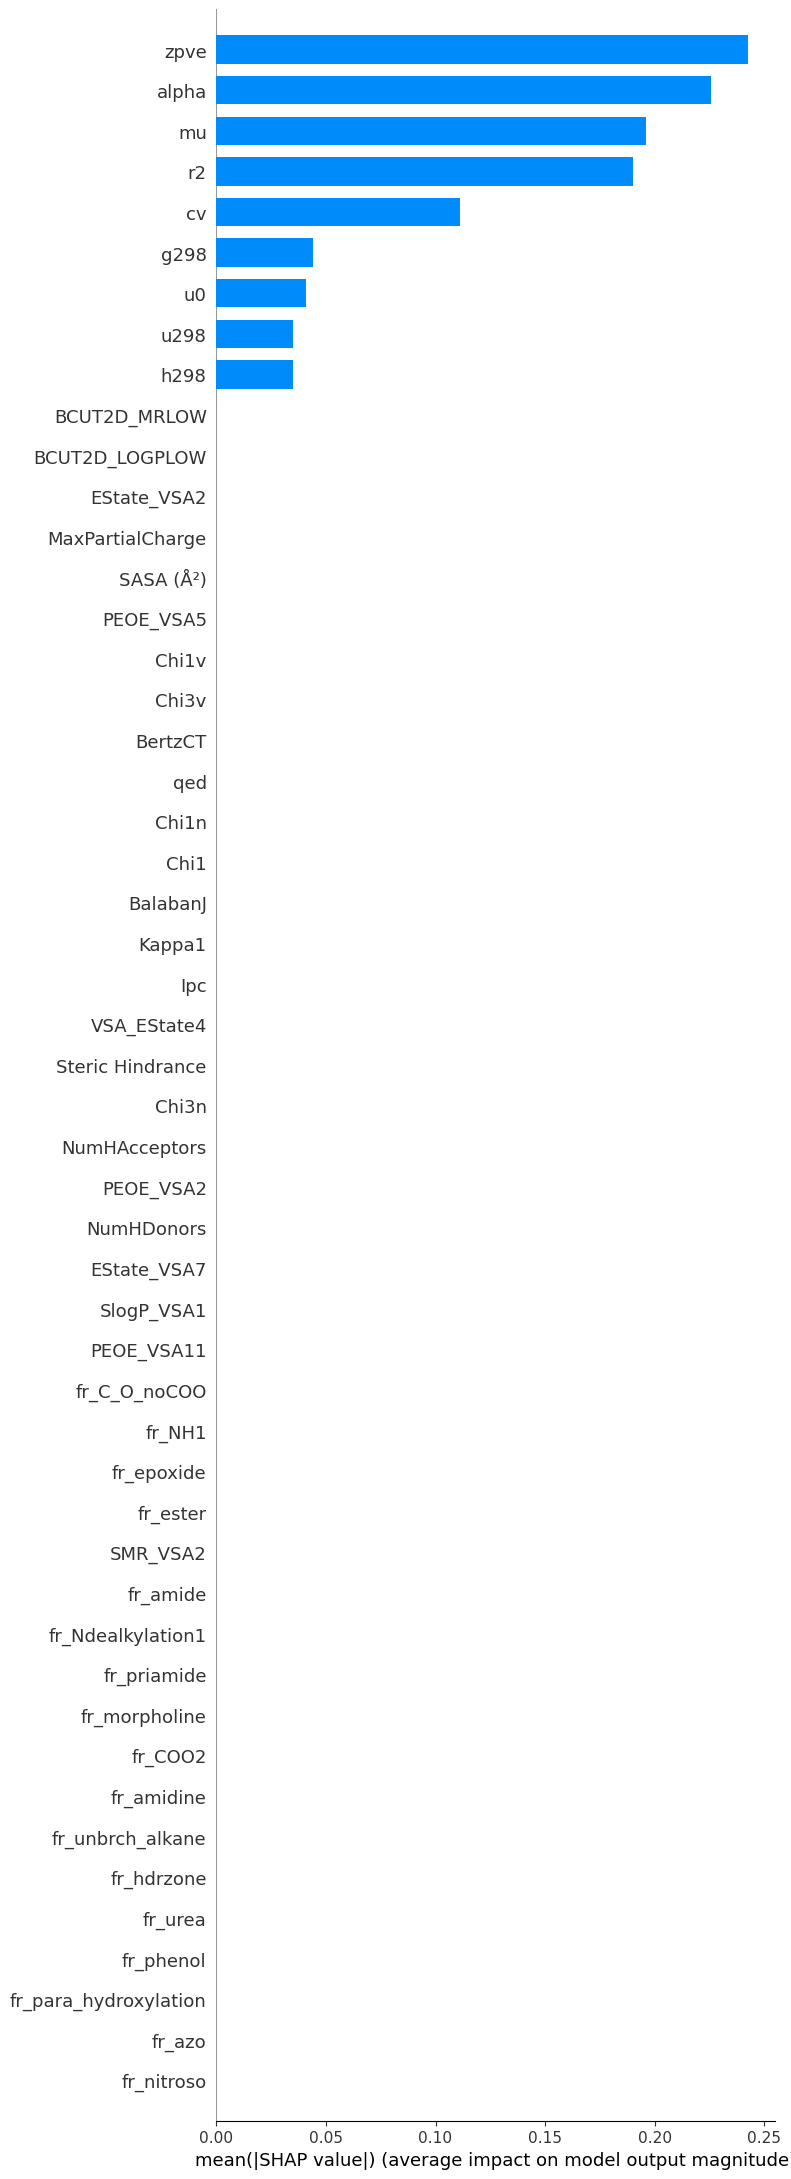

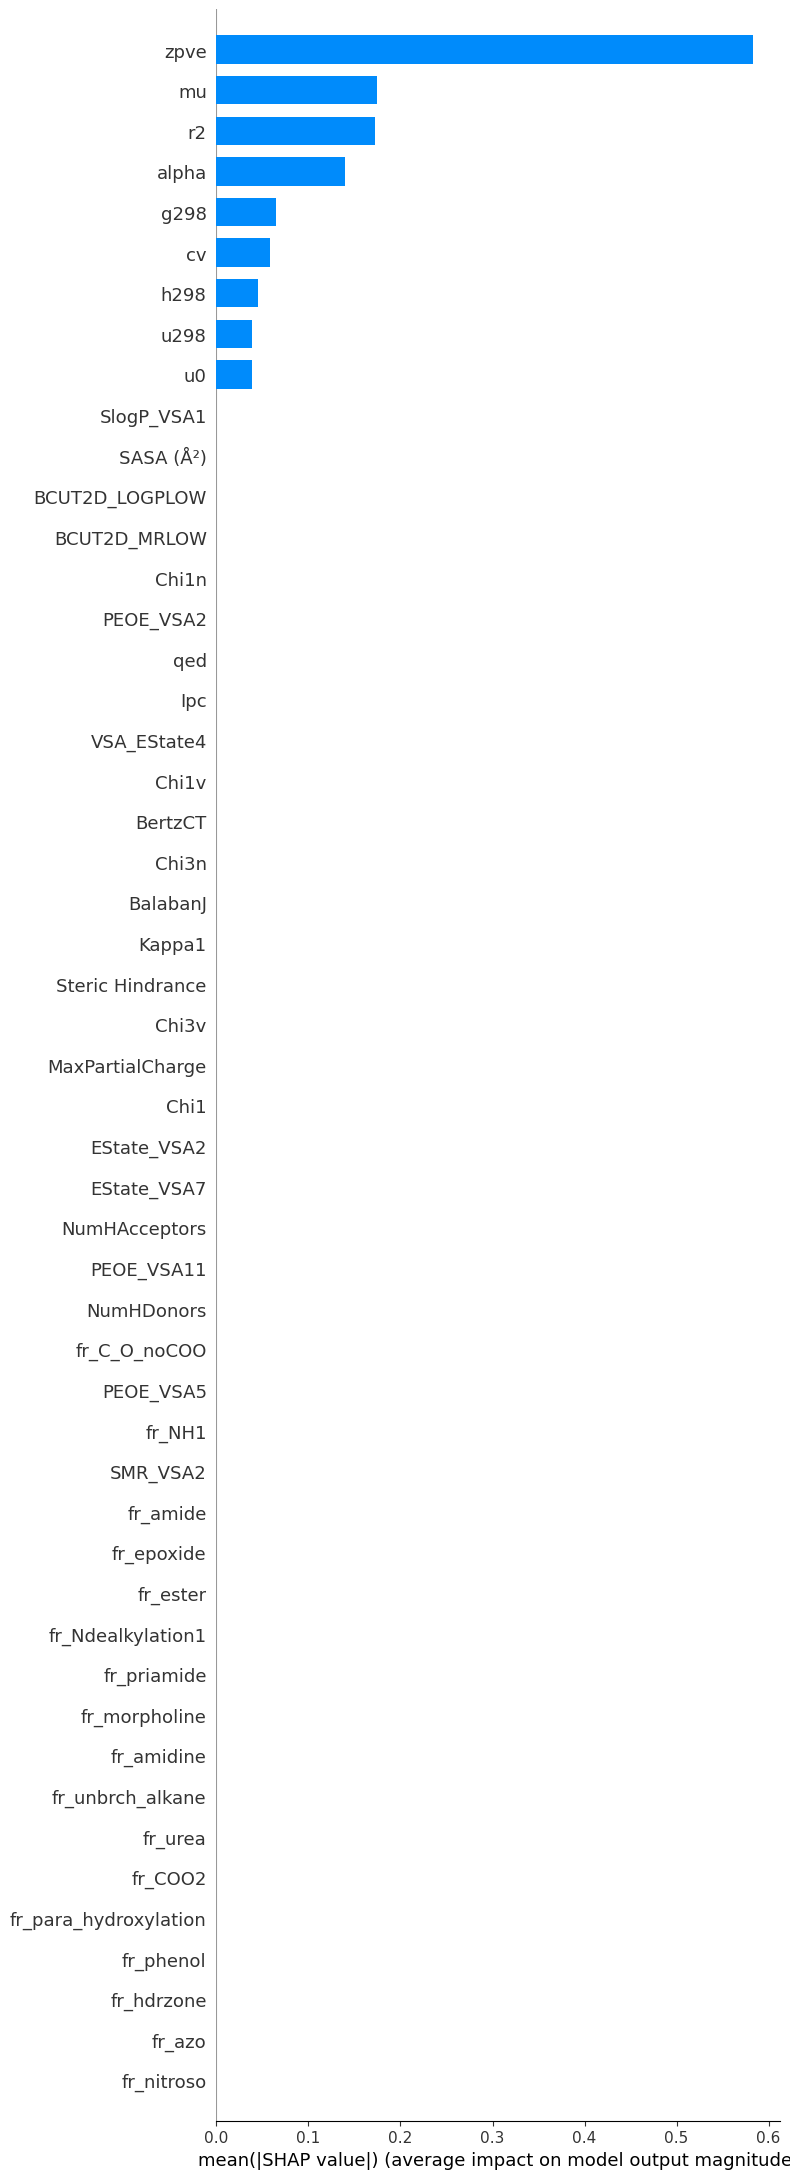

In [373]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import shap

# Train a multi-output model
multi_rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_rf_model.fit(X, y)

# Compute SHAP values for each target ('homo' and 'lumo')
# For 'homo' target
rf_model_homo = multi_rf_model.estimators_[0]  # Access the regressor for 'homo'
explainer_homo = shap.TreeExplainer(rf_model_homo)
shap_values_homo = explainer_homo.shap_values(X)

# For 'lumo' target
rf_model_lumo = multi_rf_model.estimators_[1]  # Access the regressor for 'lumo'
explainer_lumo = shap.TreeExplainer(rf_model_lumo)
shap_values_lumo = explainer_lumo.shap_values(X)

# Create SHAP summary plots for both targets
shap.summary_plot(shap_values_homo, X, plot_type="bar", max_display=60)
shap.summary_plot(shap_values_lumo, X, plot_type="bar", max_display=60)


In [382]:
# Directory to save results
save_path = '/media/omid/HDD2/QM9_sci'

# Save SHAP values for 'homo'
# shap_homo_df = pd.DataFrame(shap_values_homo, columns=[f"Feature_{i}" for i in range(X.shape[1])])
# shap_homo_df.to_csv(f"{save_path}/shap_values_homo.csv", index=False)

# Create SHAP summary plot for 'homo'
shap.summary_plot(shap_values_homo, X, plot_type="bar", max_display=60, show=False)
plt.savefig(f"{save_path}/shap_summary_homo_60.png", bbox_inches='tight')
plt.close()
shap.summary_plot(shap_values_homo, X, plot_type="bar", max_display=10, show=False)
plt.savefig(f"{save_path}/shap_summary_homo_10.png", bbox_inches='tight')
plt.close()

# Save SHAP values for 'lumo'
# shap_lumo_df = pd.DataFrame(shap_values_lumo, columns=[f"Feature_{i}" for i in range(X.shape[1])])
# shap_lumo_df.to_csv(f"{save_path}/shap_values_lumo.csv", index=False)

# Create SHAP summary plot for 'lumo'
shap.summary_plot(shap_values_lumo, X, plot_type="bar", max_display=60, show=False)
plt.savefig(f"{save_path}/shap_summary_lumo_60.png", bbox_inches='tight')
plt.close()
shap.summary_plot(shap_values_lumo, X, plot_type="bar", max_display=10, show=False)
plt.savefig(f"{save_path}/shap_summary_lumo_10.png", bbox_inches='tight')
plt.close()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import shap
import matplotlib.pyplot as plt

# Train a multi-output model
multi_rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
multi_rf_model.fit(X, y)

# Directory to save results
save_path = '/media/omid/HDD2/QM9_sci'

# Compute SHAP values for each target ('homo' and 'lumo')

# --------------------------------------------------------

# For 'homo' target
rf_model_homo = multi_rf_model.estimators_[0]  # Access the regressor for 'homo'
explainer_homo = shap.TreeExplainer(rf_model_homo)
shap_values_homo = explainer_homo.shap_values(X)

# Save SHAP values for 'homo'
shap_homo_df = pd.DataFrame(shap_values_homo, columns=[f"Feature_{i}" for i in range(X.shape[1])])
shap_homo_df.to_csv(f"{save_path}/shap_values_homo.csv", index=False)

# Create SHAP summary plot for 'homo'
shap.summary_plot(shap_values_homo, X, plot_type="bar", max_display=60, show=False)
plt.savefig(f"{save_path}/shap_summary_homo_60.png", bbox_inches='tight')
plt.close()
shap.summary_plot(shap_values_homo, X, plot_type="bar", max_display=10, show=False)
plt.savefig(f"{save_path}/shap_summary_homo_10.png", bbox_inches='tight')
plt.close()

# --------------------------------------------------------

# For 'lumo' target
rf_model_lumo = multi_rf_model.estimators_[1]  # Access the regressor for 'lumo'
explainer_lumo = shap.TreeExplainer(rf_model_lumo)
shap_values_lumo = explainer_lumo.shap_values(X)

# Save SHAP values for 'lumo'
shap_lumo_df = pd.DataFrame(shap_values_lumo, columns=[f"Feature_{i}" for i in range(X.shape[1])])
shap_lumo_df.to_csv(f"{save_path}/shap_values_lumo.csv", index=False)

# Create SHAP summary plot for 'lumo'
shap.summary_plot(shap_values_lumo, X, plot_type="bar", max_display=60, show=False)
plt.savefig(f"{save_path}/shap_summary_lumo_60.png", bbox_inches='tight')
plt.close()
shap.summary_plot(shap_values_lumo, X, plot_type="bar", max_display=10, show=False)
plt.savefig(f"{save_path}/shap_summary_lumo_10.png", bbox_inches='tight')
plt.close()

# All Lazy Models for HOMO/LUMO - for 51 feature of QM9

In [399]:
scaled_common_2D_3D_descriptors_QM9_61 = pd.read_csv('/media/omid/HDD2/QM9_sci/scaled_common_2D_3D_descriptors_QM9_61.csv')

X = scaled_common_2D_3D_descriptors_QM9_61.drop(columns=['homo', 'lumo'])
y = scaled_common_2D_3D_descriptors_QM9_61[['homo', 'lumo']]

In [406]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import REGRESSORS  # Import all supported regressors

# Split the data into training, validation, and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the remaining set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Create a dictionary of all available regressors
# all_models_dict = {model_name: model_class for model_name, model_class in REGRESSORS}

# # Initialize LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, regressors=all_models_dict)

# # Fit the model on training data and evaluate it on validation data
# models, predictions = reg.fit(X_train, X_val, y_train, y_val)
models_homo_lumo_reg_2d_3d, predictions_homo_lumo_reg_2d_3d = reg.fit(X_train, X_val, y_train, y_val)


100%|███████████████████████████████████████████| 42/42 [09:37<00:00, 13.75s/it]


In [407]:
# Sort by RMSE in ascending order
predictions_homo_lumo_reg_2d_3d_sorted = predictions_homo_lumo_reg_2d_3d.sort_values(by='RMSE', ascending=True)
models_homo_lumo_reg_2d_3d_sorted = models_homo_lumo_reg_2d_3d.sort_values(by='RMSE', ascending=True)

In [408]:
# Save Both models and predictions with Pickle
import pickle

with open('/media/omid/HDD2/QM9_sci/homo_lumo_reg_2d_3d_train_results_ANA_51Features_val_QM9.pkl', 'wb') as f:
    pickle.dump({'models': models_homo_lumo_reg_2d_3d_sorted, 'predictions': predictions_homo_lumo_reg_2d_3d_sorted}, f)

In [415]:
# Load the pickle file
with open('/media/omid/HDD2/QM9_sci/homo_lumo_reg_2d_3d_train_results_ANA_51Features_val_QM9.pkl', 'rb') as f:
    data = pickle.load(f)

# Extract the models and predictions
df_trainings = data['models']
df_predictions = data['predictions']

# Convert them into a DataFrame
models_h_l_reg_2d_3d_sorted = pd.DataFrame(df_trainings)
predictions_h_l_reg_2d_3d_sorted = pd.DataFrame(df_predictions)

# Reset the index to move any hierarchical index into columns
models_h_l_reg_2d_3d_sorted_reset = models_h_l_reg_2d_3d_sorted.reset_index()
predictions_h_l_reg_2d_3d_sorted_reset = predictions_h_l_reg_2d_3d_sorted.reset_index()

# Save models metadata to a CSV file
models_h_l_reg_2d_3d_sorted_reset.to_csv('/media/omid/HDD2/QM9_sci/models_homo_lumo_reg_2d_3d_sorted_reset_lazy_51Features_QM9.csv', index=False)
predictions_h_l_reg_2d_3d_sorted_reset.to_csv('/media/omid/HDD2/QM9_sci/predictions_homo_lumo_reg_2d_3d_sorted_reset_lazy_51Features_QM9.csv', index=False)

predictions_h_l_reg_2d_3d_sorted_reset[:-2]

Model  Adjusted R-Squared  R-Squared  RMSE  \
0             BaggingRegressor                1.00       1.00  0.00   
1        DecisionTreeRegressor                1.00       1.00  0.00   
2        RandomForestRegressor                1.00       1.00  0.00   
3          ExtraTreesRegressor                1.00       1.00  0.00   
4           ExtraTreeRegressor                1.00       1.00  0.00   
5                 XGBRegressor                0.97       0.97  0.17   
6                 MLPRegressor                0.74       0.74  0.52   
7             LinearRegression                0.41       0.42  0.77   
8   TransformedTargetRegressor                0.41       0.42  0.77   
9                      RidgeCV                0.38       0.38  0.79   
10                       Ridge                0.38       0.38  0.79   
11   OrthogonalMatchingPursuit                0.38       0.38  0.80   
12         KNeighborsRegressor                0.29       0.29  0.85   
13                  ElasticNet                0.05       0.06  0.98   
14                       Lasso               -0.00      -0.00  1.01   
15              DummyRegressor               -0.00      -0.00  1.01   
16                   LassoLars               -0.00      -0.00  1.01   

    Time Taken  
0        30.88  
1         4.68  
2       294.47  
3        56.88  
4         0.78  
5         0.97  
6       176.83  
7         0.35  
8         0.36  
9         0.68  
10        0.27  
11        0.26  
12        1.47  
13        0.29  
14        0.29  
15        0.20  
16        0.26

In [417]:
# Visualizing the performance on the validation set
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=predictions_homo_lumo_reg_2d_3d.index,
                 y="RMSE",
                 data=predictions_homo_lumo_reg_2d_3d,
                 palette='rainbow')
ax.set(ylim=(0, 1))
plt.xticks(rotation=90)
plt.title("HOMO/LUMO Energy Prediction Model Performance")
plt.savefig("/media/omid/HDD2/QM9_sci/HOMO_LUMO_Energy_Prediction_Model_Performance_reg_2d_3d_QM9_51.png", format='png', dpi=300, bbox_inches='tight')

plt.show()

## Best Models for HOMO/LUMO - for 51 feature of QM9

In [87]:
scaled_common_2D_3D_descriptors_QM9_61 = pd.read_csv('/media/omid/HDD2/QM9_sci/scaled_common_2D_3D_descriptors_QM9_61.csv')

X = scaled_common_2D_3D_descriptors_QM9_61.drop(columns=['homo', 'lumo'])
y = scaled_common_2D_3D_descriptors_QM9_61[['homo', 'lumo']]

In [386]:
# XX = X[:1000]
# yy = y[:1000]

# XX.shape, yy.shape

((1000, 51), (1000, 2))

In [88]:
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor,
    StackingRegressor,
)
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import pickle

# Split the data into training, validation, and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Define additional regressors
regressors = {
    "AdaBoostReg.": AdaBoostRegressor(random_state=42, n_estimators=50),  # Fewer estimators
    "BayesianRidge": BayesianRidge(),  # Bayesian linear model
    "ElasticNetReg.": ElasticNet(random_state=42, alpha=1.0, l1_ratio=0.5),  # Regularized linear model
    "KNeighborsReg.": KNeighborsRegressor(n_neighbors=5),  # Simple k-NN
    "LinearReg.": LinearRegression(),  # Basic linear model
    "LassoReg.": Lasso(random_state=42, alpha=1.0),  # Regularized linear model
    "MLPReg.": MLPRegressor(random_state=42, hidden_layer_sizes=(10,), max_iter=500),  # Simple neural network
    "RidgeReg.": Ridge(random_state=42, alpha=1.0),  # Regularized linear model
    "SVR": SVR(kernel="linear"),  # Linear kernel for simplicity
}

# Define the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ("RandomForest", RandomForestRegressor(random_state=42)),
        ("XGBoost", XGBRegressor(random_state=42, verbosity=0)),
        ("ExtraTrees", ExtraTreesRegressor(random_state=42)),
        ("GradientBoosting", GradientBoostingRegressor(random_state=42, n_estimators=100)),
    ],
    final_estimator=LinearRegression()
)
regressors["StackingReg."] = stacking_regressor

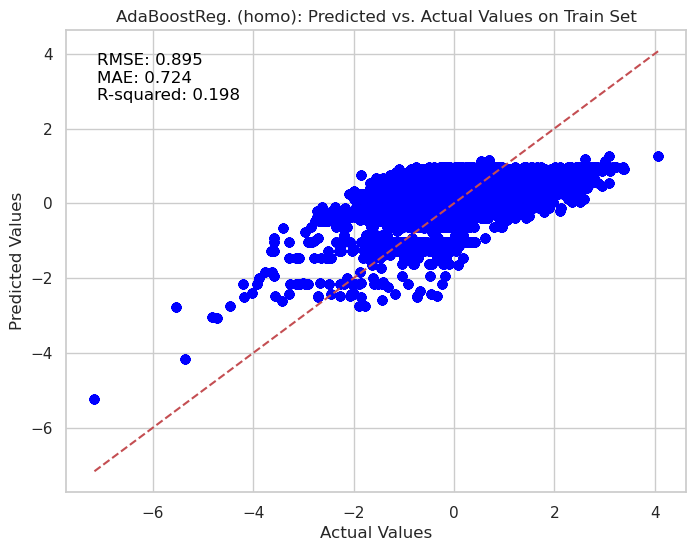

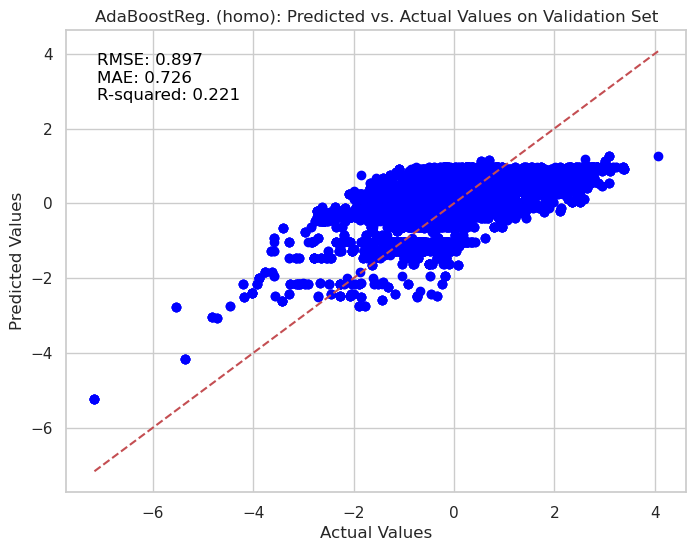

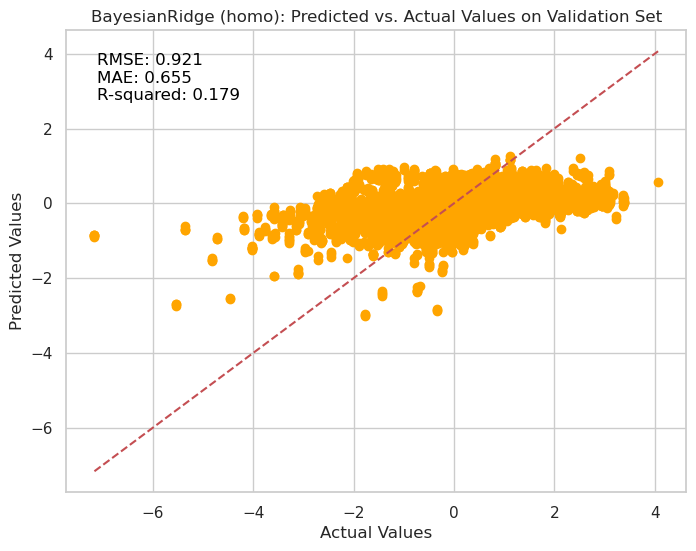

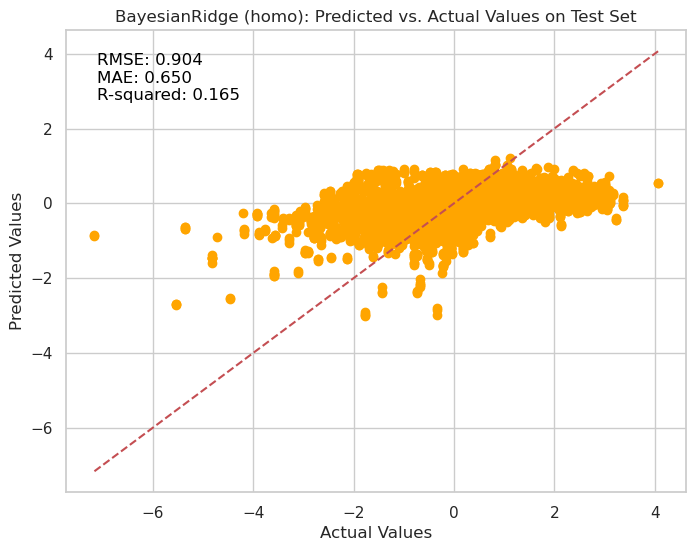

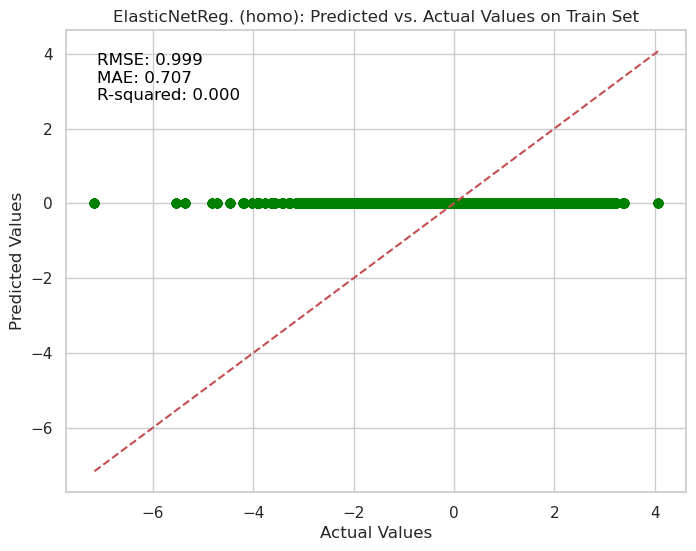

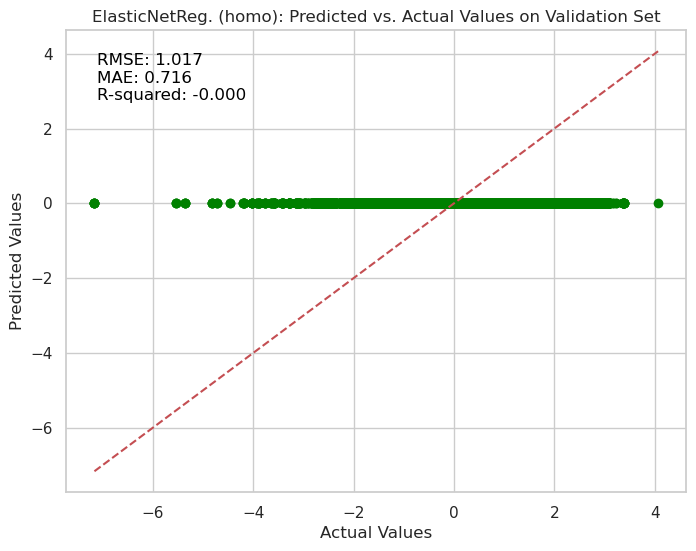

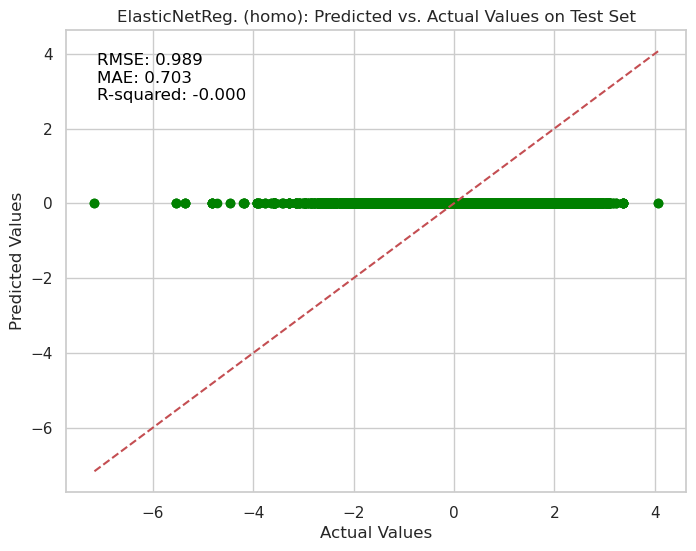

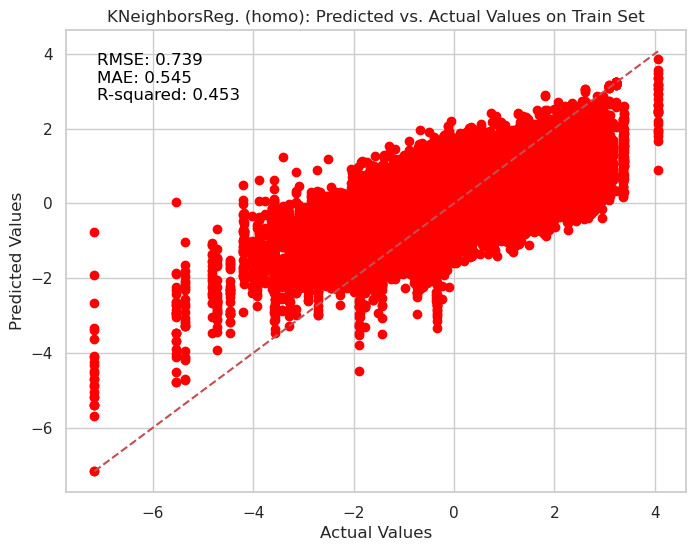

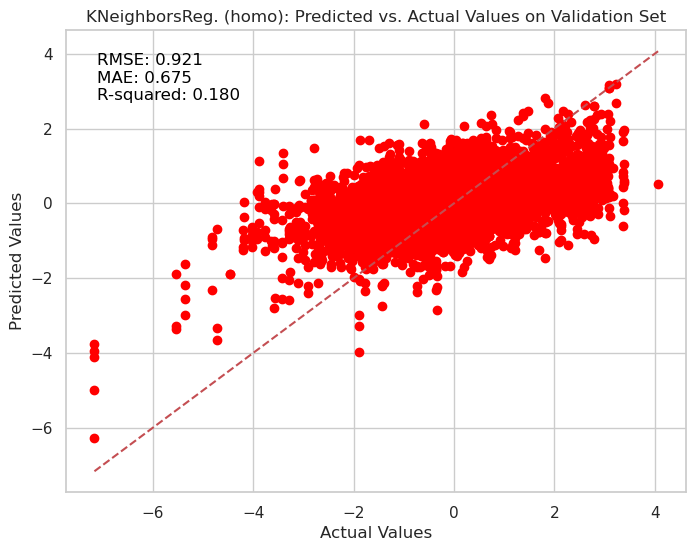

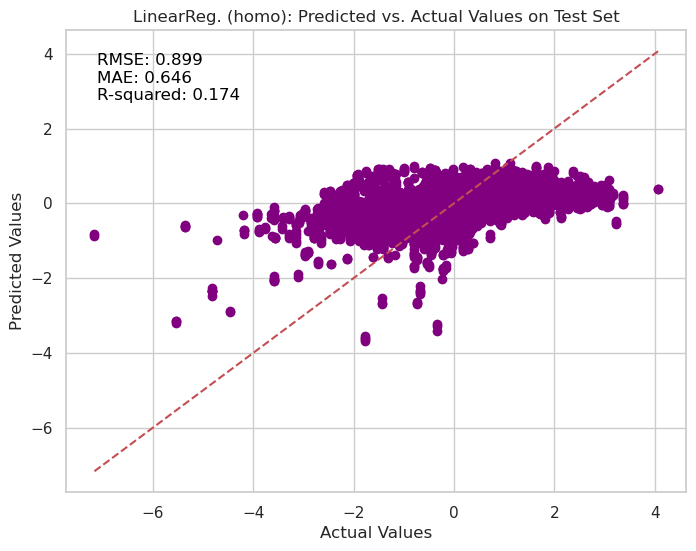

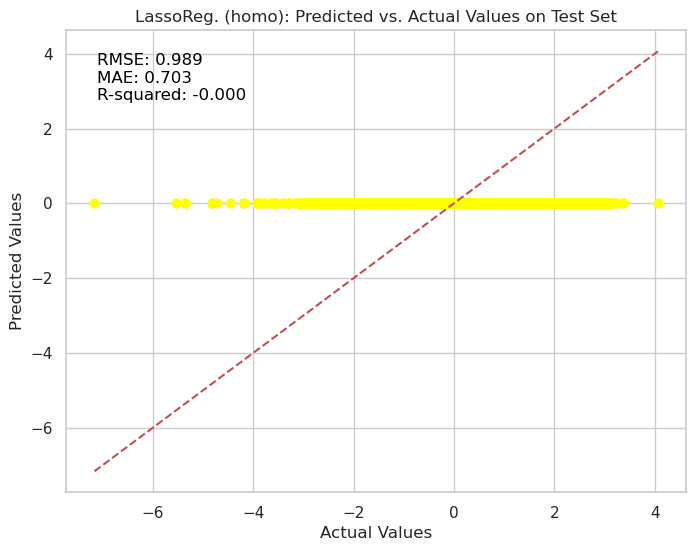

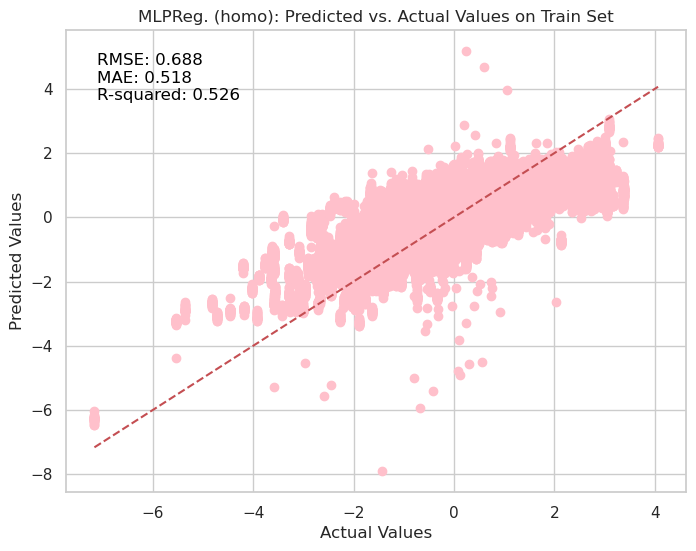

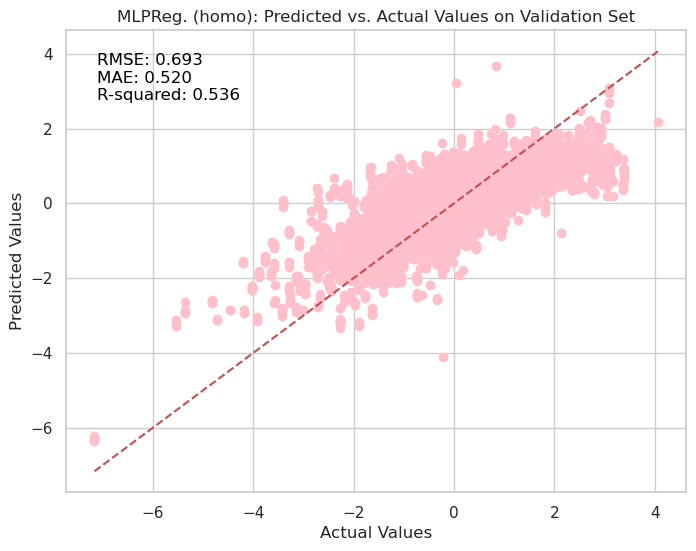

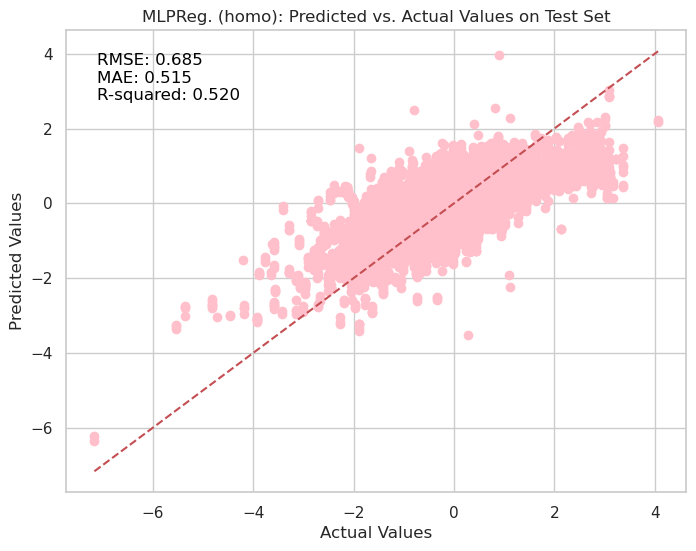

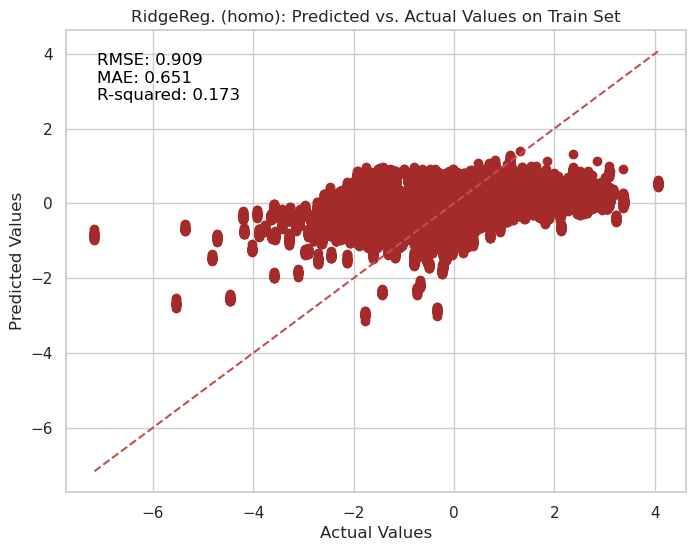

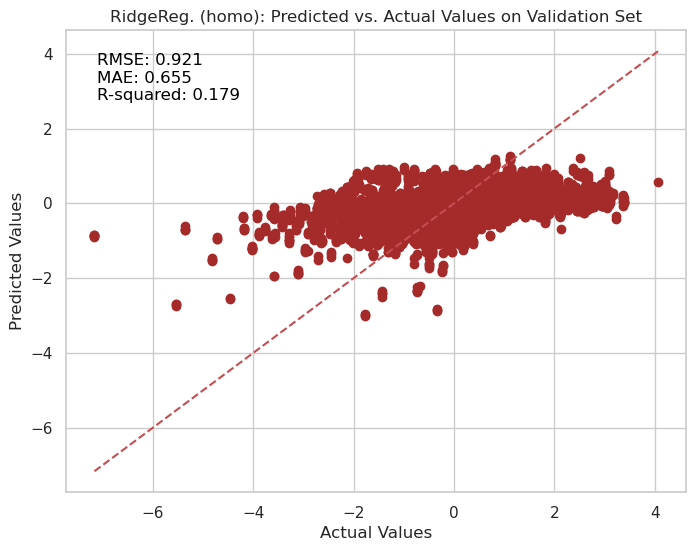

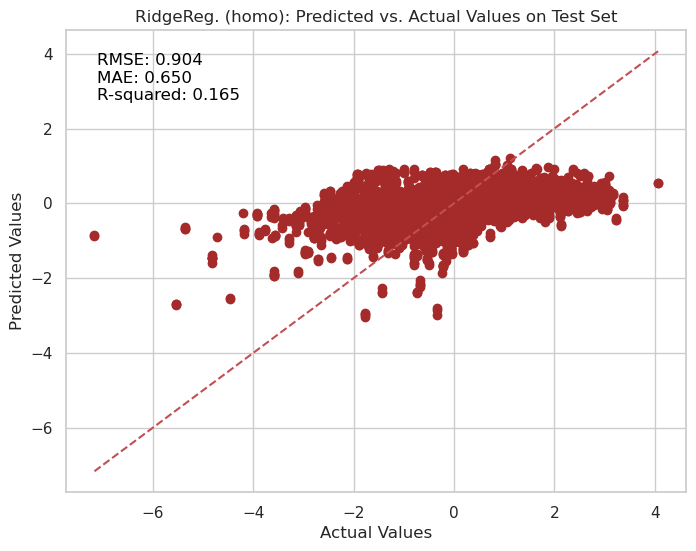

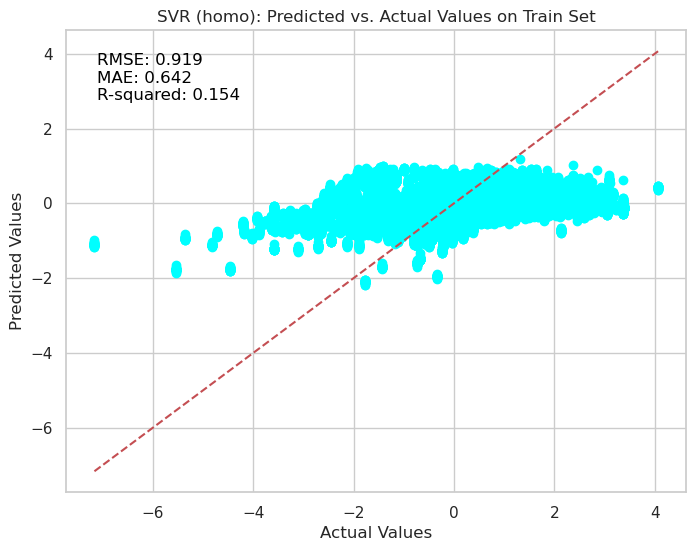

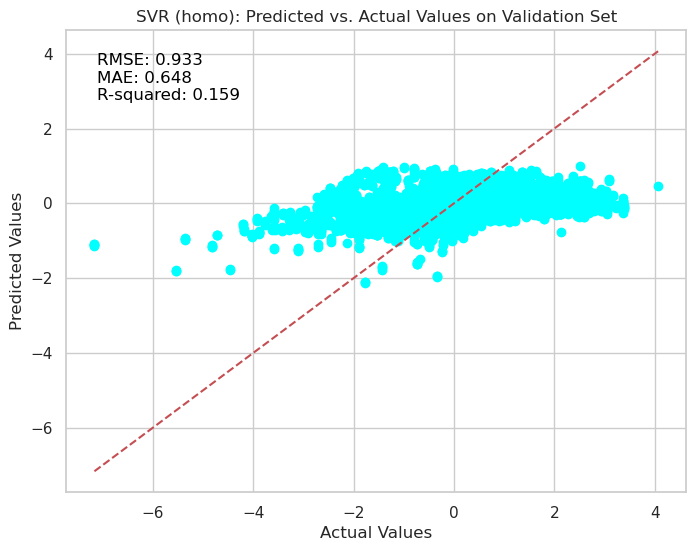

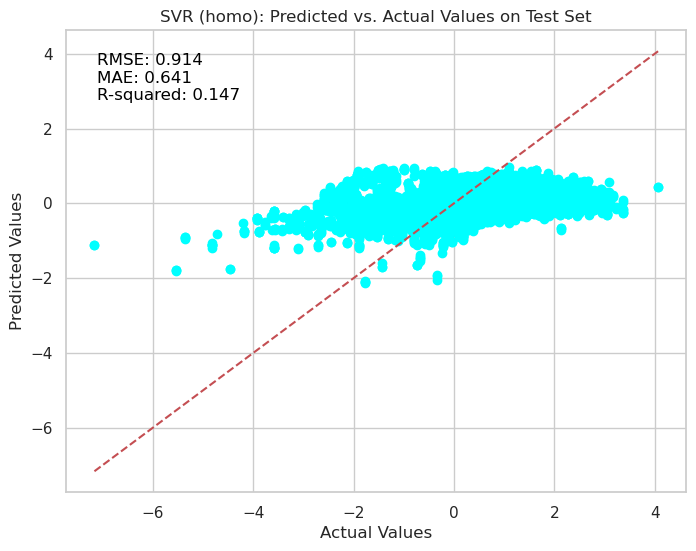

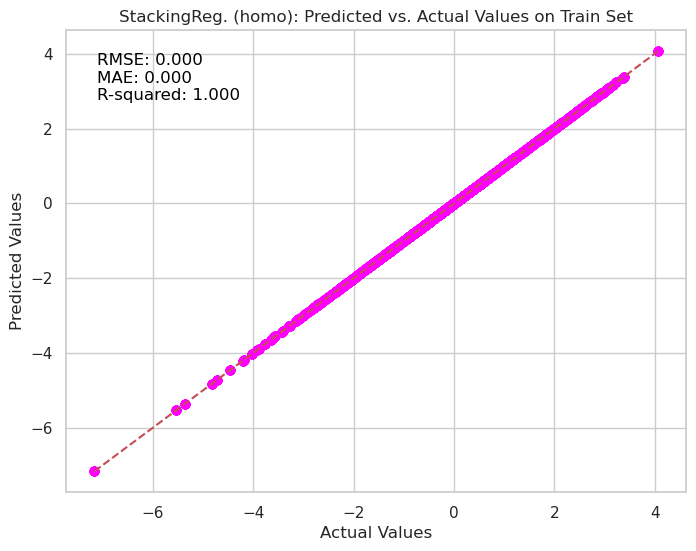

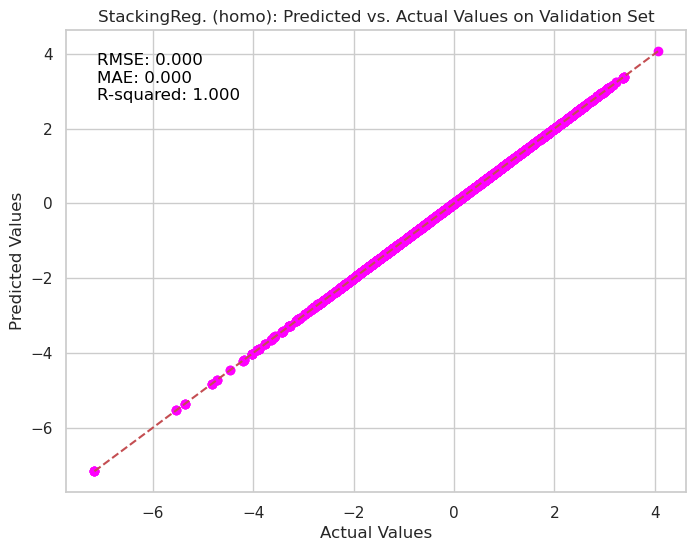

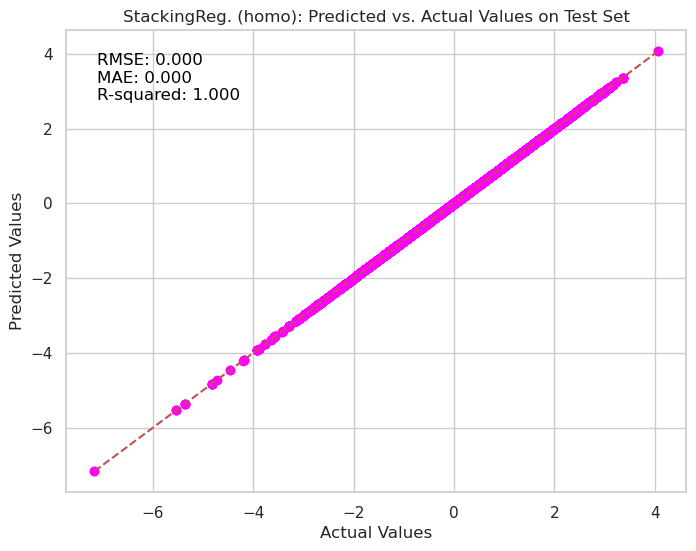

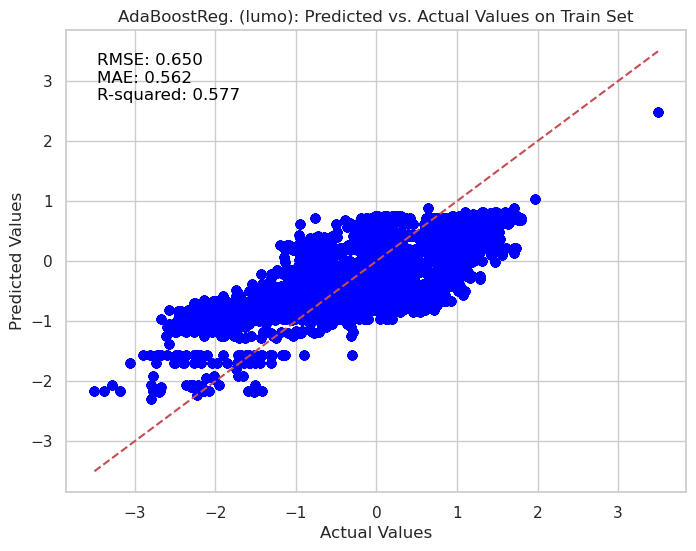

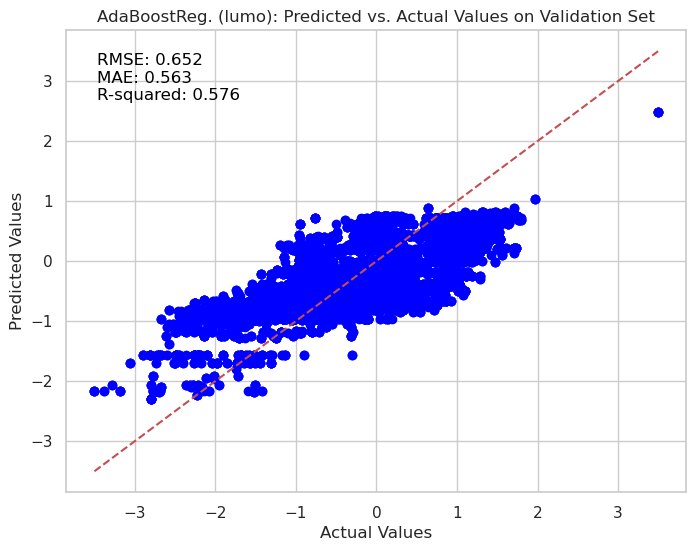

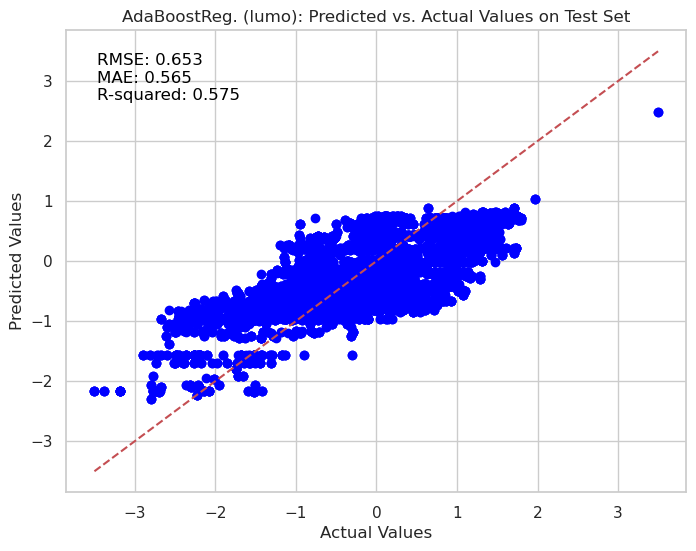

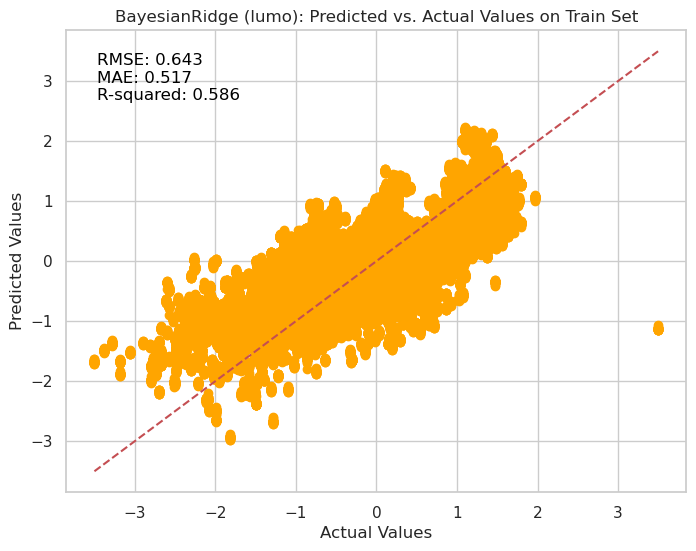

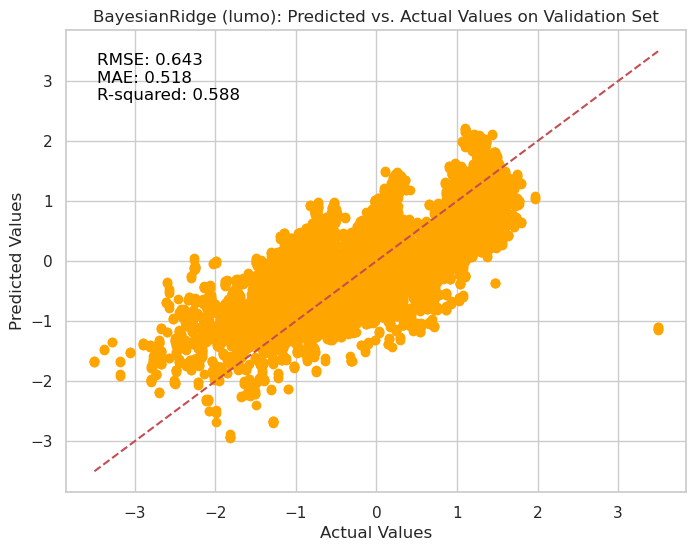

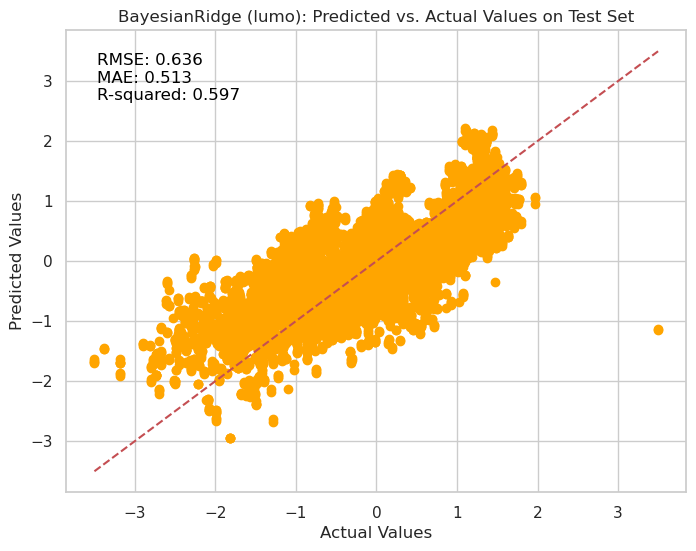

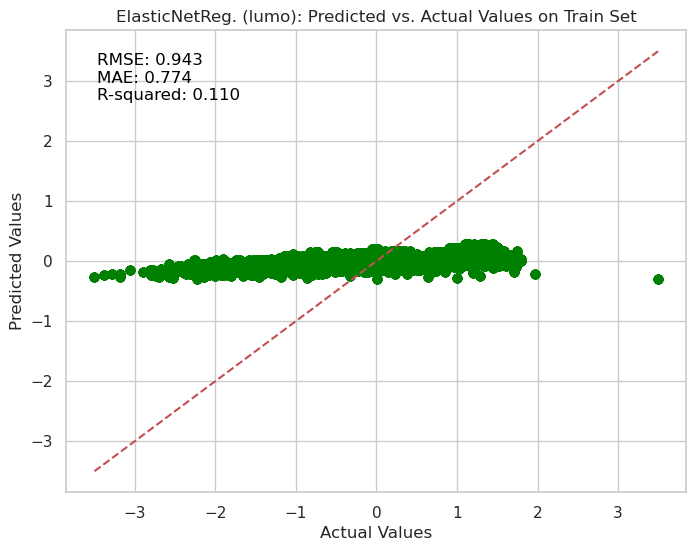

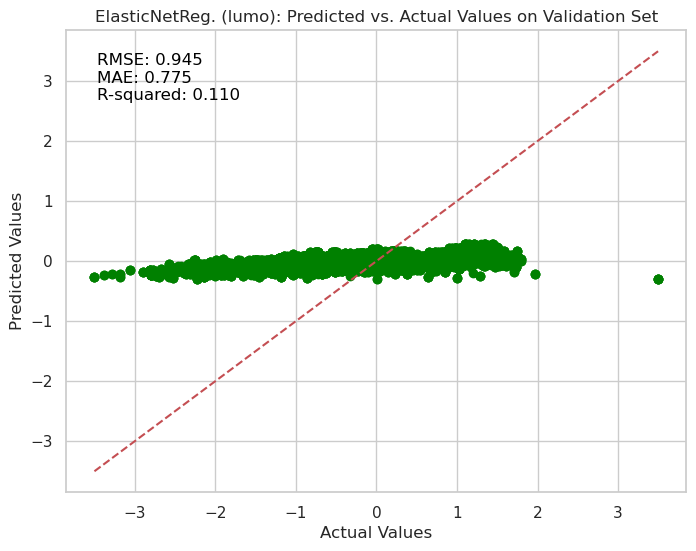

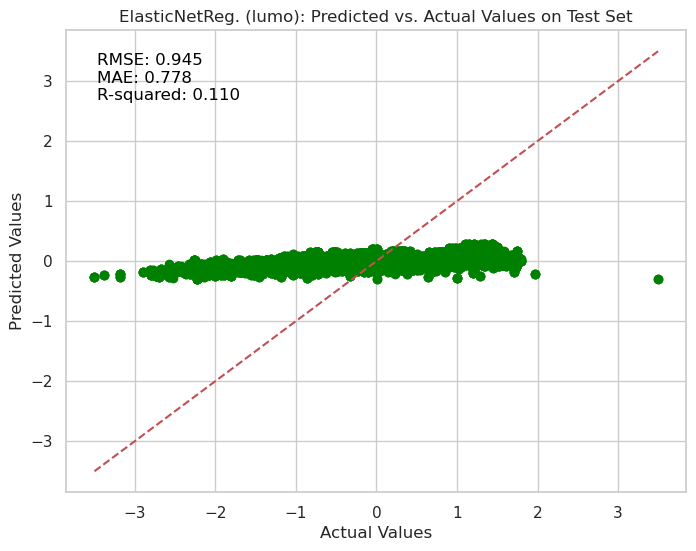

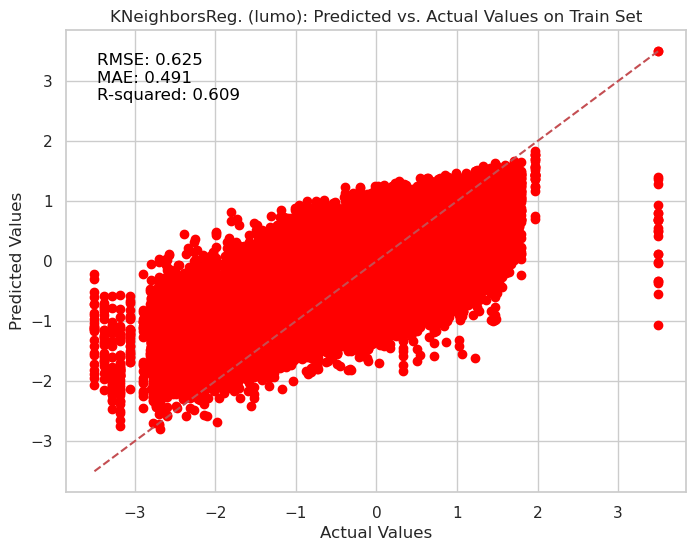

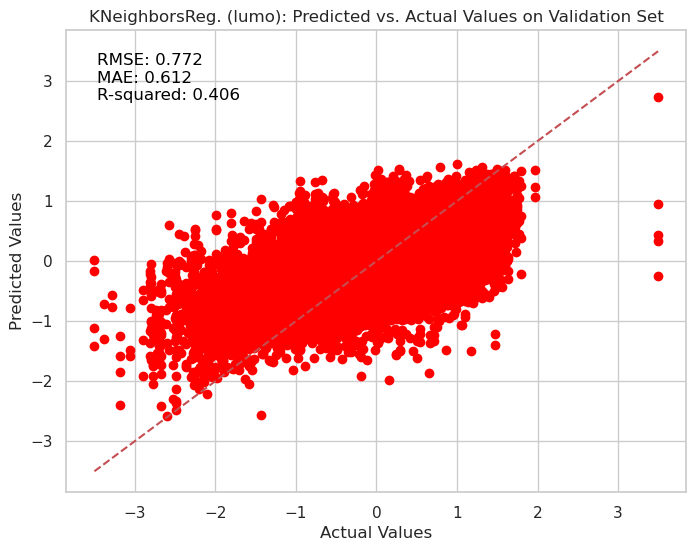

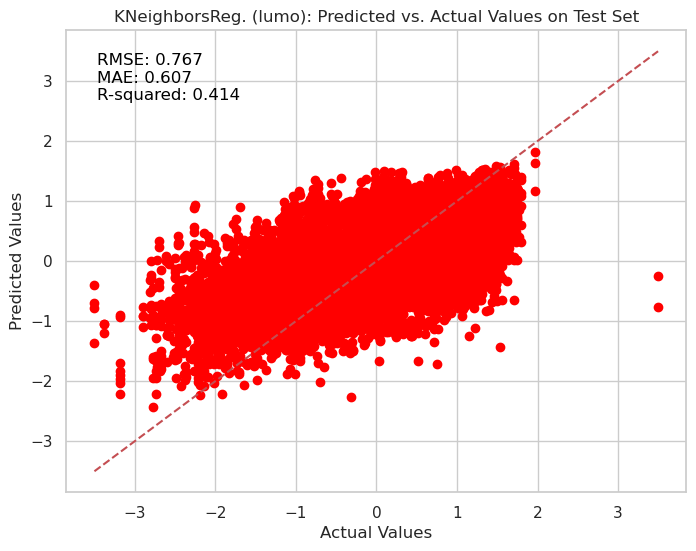

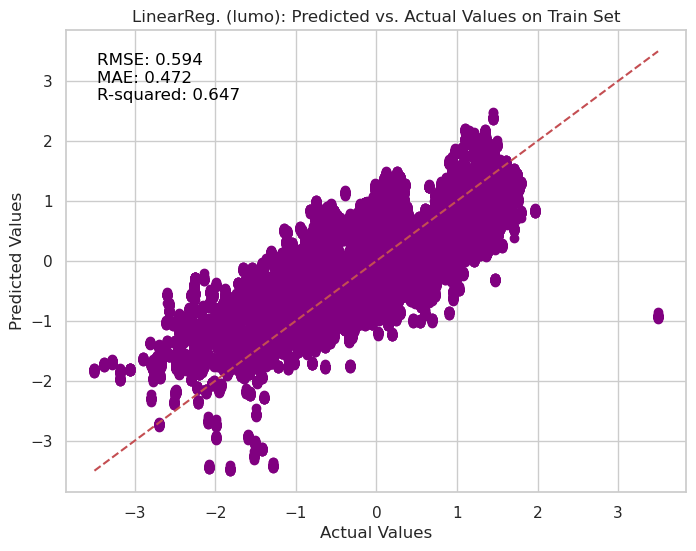

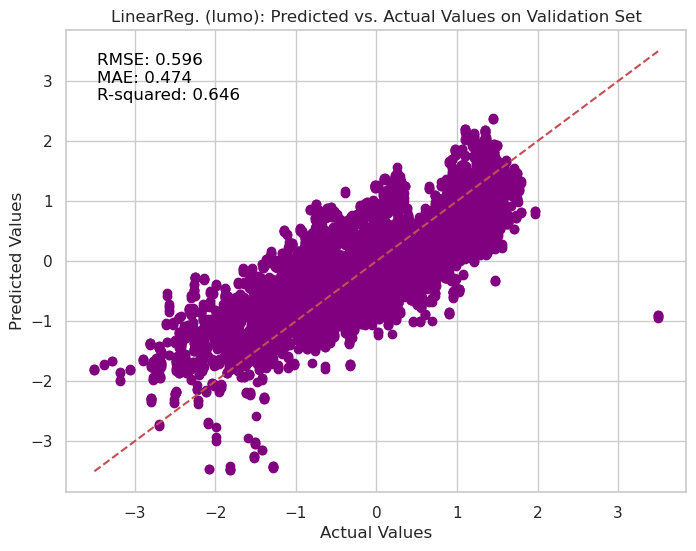

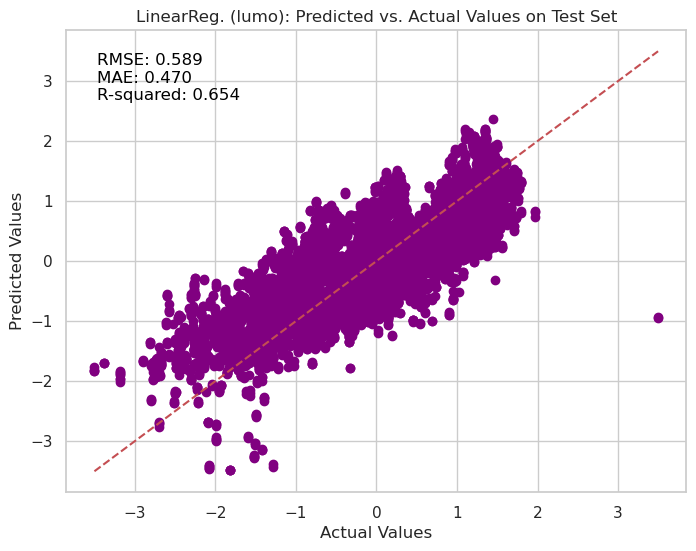

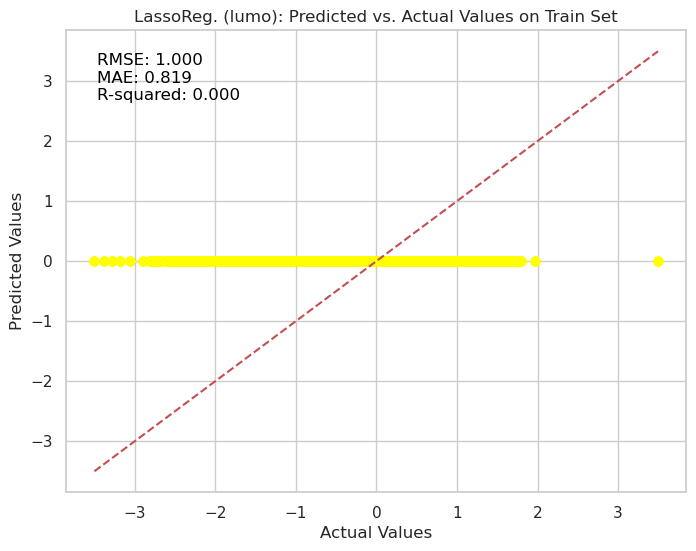

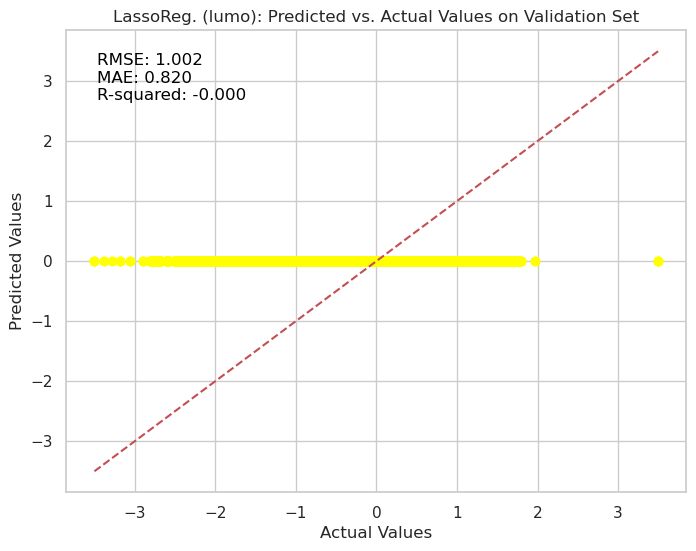

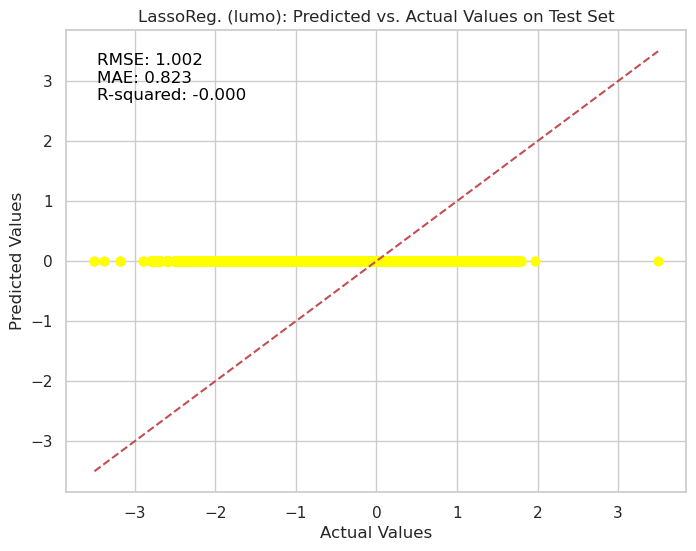

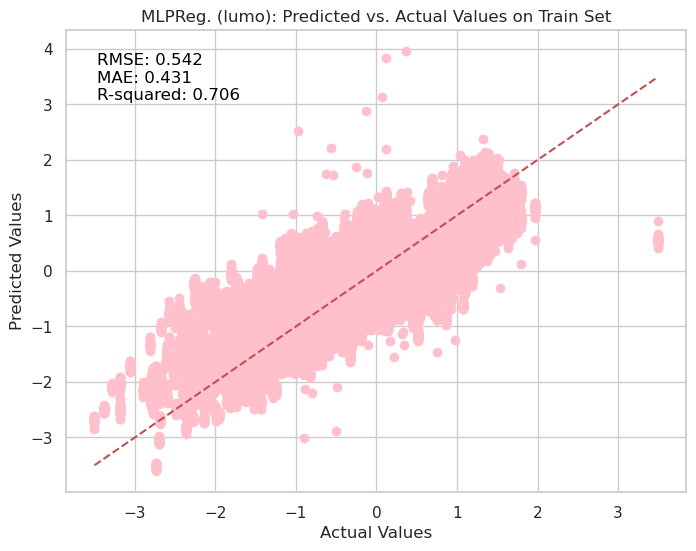

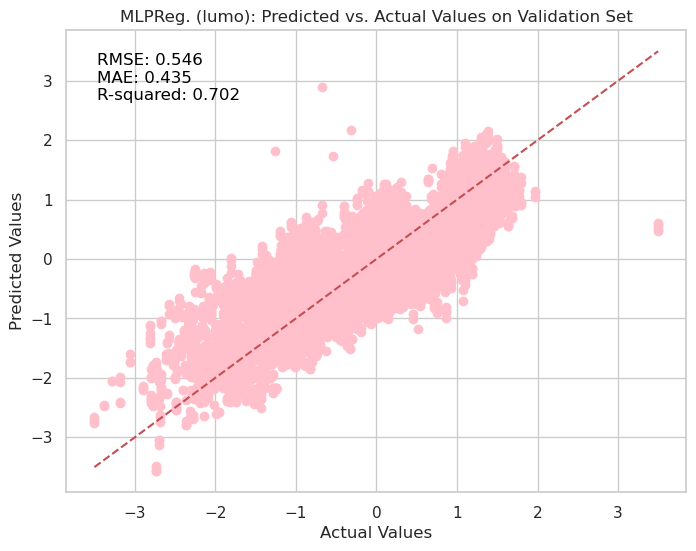

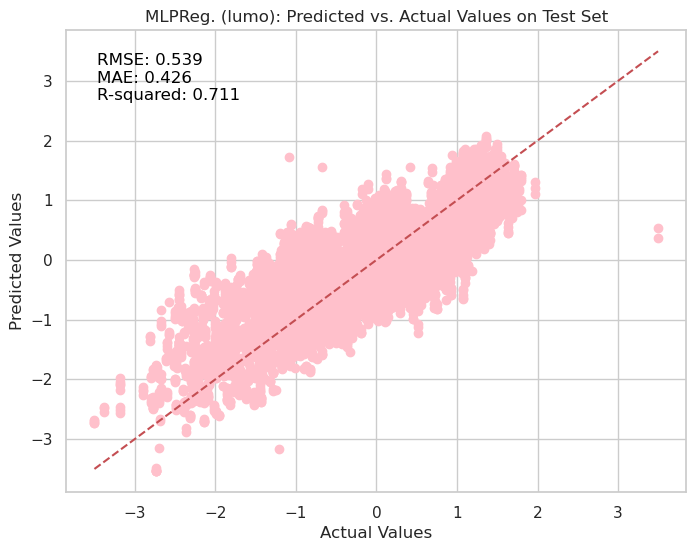

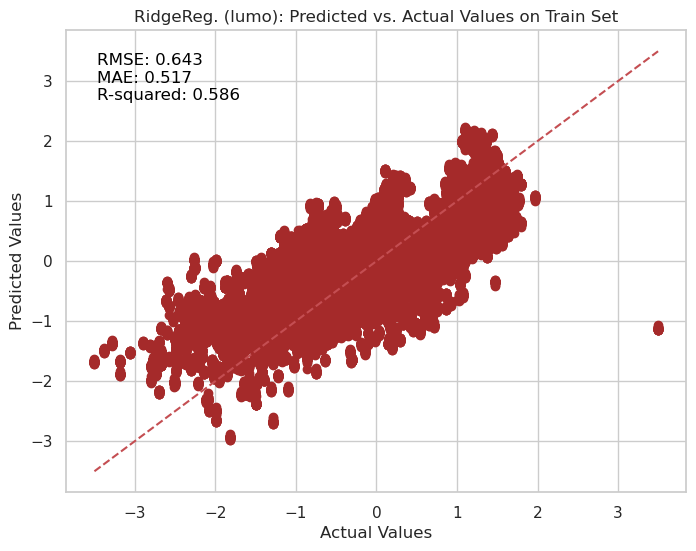

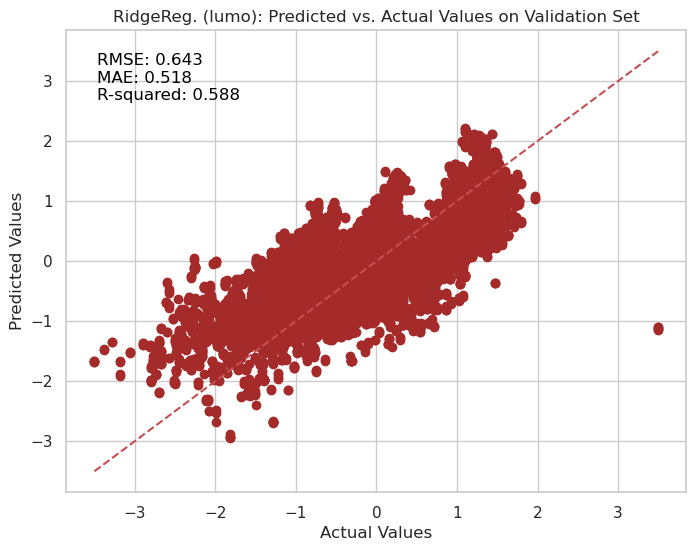

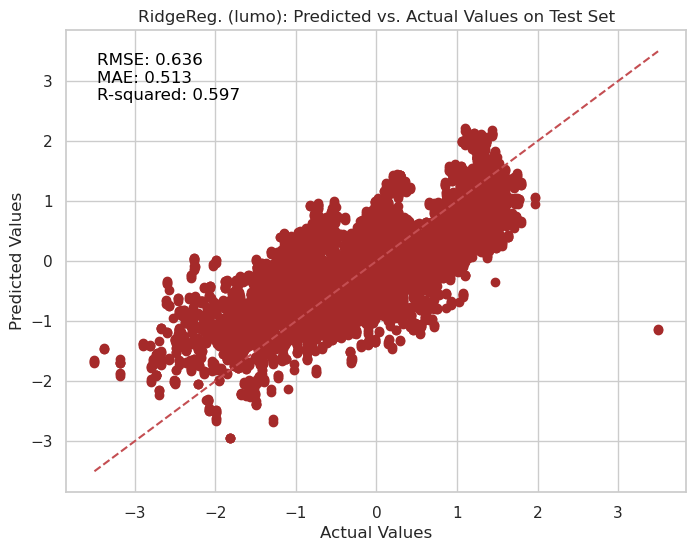

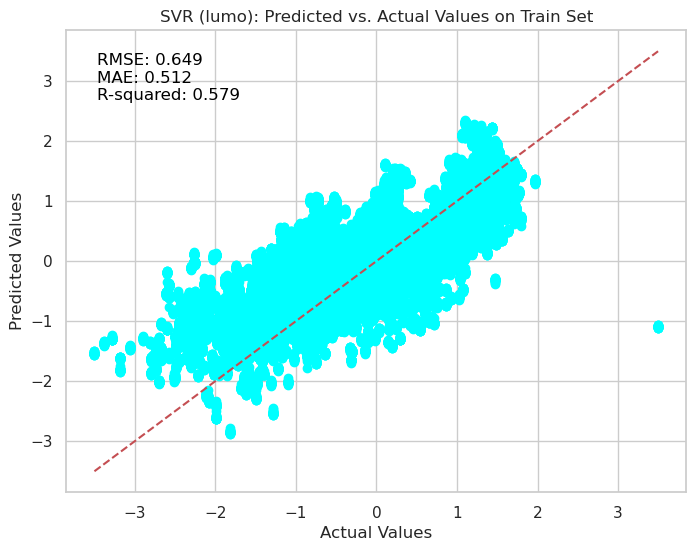

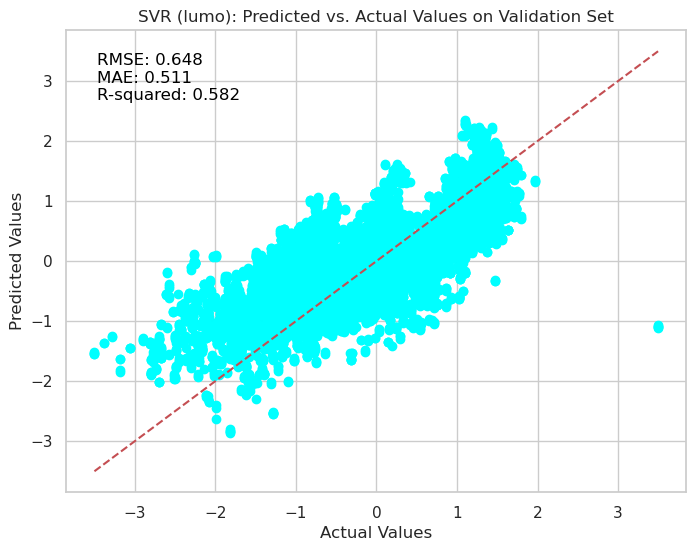

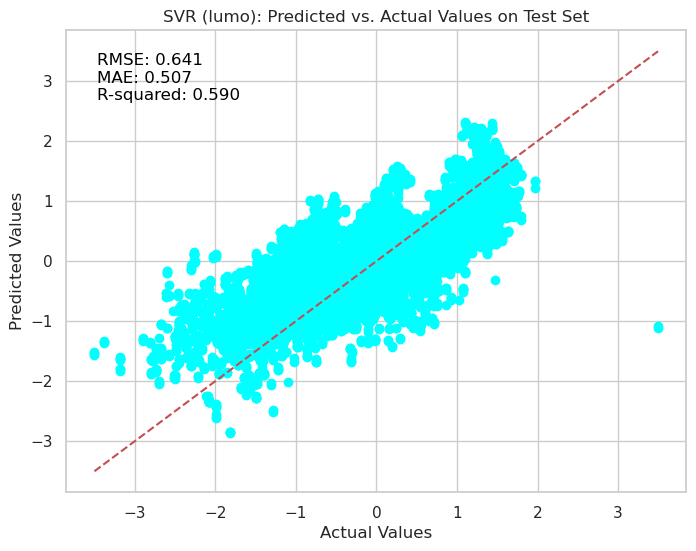

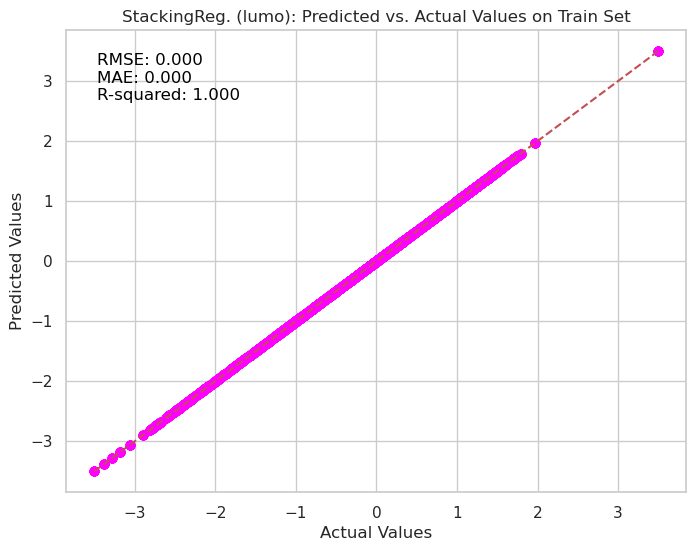

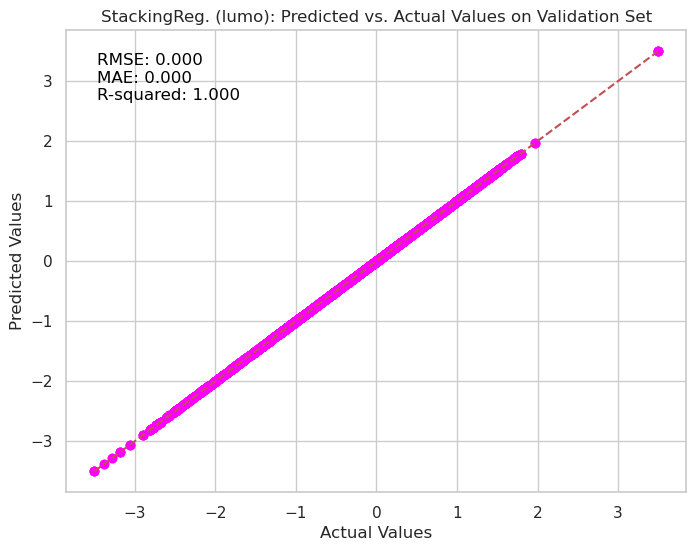

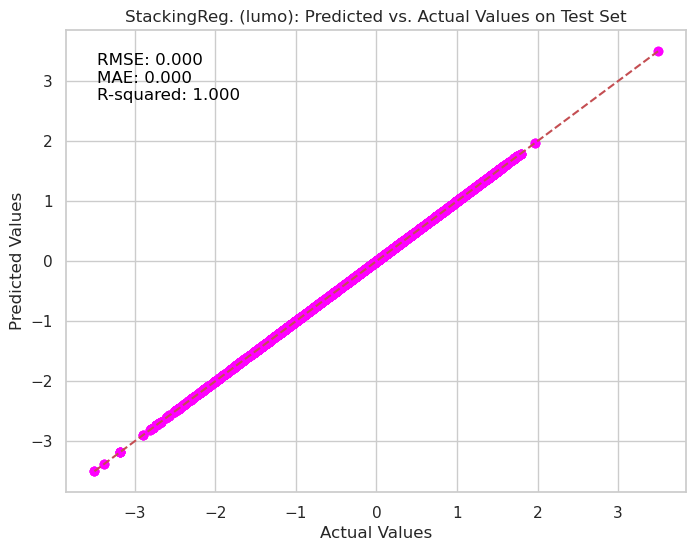

Models and plots saved as:
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_model.pkl
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_train_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_validation_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_test_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_train_actual_vs_predicted_51_QM9.csv
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_validation_actual_vs_predicted_51_QM9.csv
- /media/omid/HDD2/QM9_sci/new250211/AdaBoostReg._homo_test_actual_vs_predicted_51_QM9.csv
- /media/omid/HDD2/QM9_sci/new250211/BayesianRidge_homo_model.pkl
- /media/omid/HDD2/QM9_sci/new250211/BayesianRidge_homo_train_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/BayesianRidge_homo_validation_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/BayesianRidge_homo_test_scatter_plot_51_QM9.png
- /media/omid/HDD2/QM9_sci/new250211/Baye

Model Target  Train RMSE  Train MAE  Train R2  Validation RMSE  \
9     StackingReg.   homo       0.000      0.000     1.000            0.000   
6          MLPReg.   homo       0.688      0.518     0.526            0.693   
0     AdaBoostReg.   homo       0.895      0.724     0.198            0.897   
4       LinearReg.   homo       0.906      0.648     0.179            0.917   
1    BayesianRidge   homo       0.909      0.651     0.173            0.921   
7        RidgeReg.   homo       0.909      0.651     0.173            0.921   
3   KNeighborsReg.   homo       0.739      0.545     0.453            0.921   
8              SVR   homo       0.919      0.642     0.154            0.933   
2   ElasticNetReg.   homo       0.999      0.707     0.000            1.017   
5        LassoReg.   homo       0.999      0.707     0.000            1.017   
19    StackingReg.   lumo       0.000      0.000     1.000            0.000   
16         MLPReg.   lumo       0.542      0.431     0.706            0.546   
14      LinearReg.   lumo       0.594      0.472     0.647            0.596   
11   BayesianRidge   lumo       0.643      0.517     0.586            0.643   
17       RidgeReg.   lumo       0.643      0.517     0.586            0.643   
18             SVR   lumo       0.649      0.512     0.579            0.648   
10    AdaBoostReg.   lumo       0.650      0.562     0.577            0.652   
13  KNeighborsReg.   lumo       0.625      0.491     0.609            0.772   
12  ElasticNetReg.   lumo       0.943      0.774     0.110            0.945   
15       LassoReg.   lumo       1.000      0.819     0.000            1.002   

    Validation MAE  Validation R2  Test RMSE  Test MAE  Test R2  
9            0.000          1.000      0.000     0.000    1.000  
6            0.520          0.536      0.685     0.515    0.520  
0            0.726          0.221      0.891     0.724    0.188  
4            0.653          0.186      0.899     0.646    0.174  
1            0.655          0.179      0.904     0.650    0.165  
7            0.655          0.179      0.904     0.650    0.165  
3            0.675          0.180      0.910     0.671    0.154  
8            0.648          0.159      0.914     0.641    0.147  
2            0.716         -0.000      0.989     0.703   -0.000  
5            0.716         -0.000      0.989     0.703   -0.000  
19           0.000          1.000      0.000     0.000    1.000  
16           0.435          0.702      0.539     0.426    0.711  
14           0.474          0.646      0.589     0.470    0.654  
11           0.518          0.588      0.636     0.513    0.597  
17           0.518          0.588      0.636     0.513    0.597  
18           0.511          0.582      0.641     0.507    0.590  
10           0.563          0.576      0.653     0.565    0.575  
13           0.612          0.406      0.767     0.607    0.414  
12           0.775          0.110      0.945     0.778    0.110  
15           0.820         -0.000      1.002     0.823   -0.000

In [89]:
# Define the save path
save_path = "/media/omid/HDD2/QM9_sci/new250211"

# Ensure the directory exists
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Colors for plots
colors = [
    'blue', 'orange', 'green', 'red', 'purple', 'yellow', 'pink', 
    'brown', 'cyan', 'magenta', 'lime', 'indigo', 'teal', 'violet', 
    'gold', 'silver', 'crimson', 'navy', 'maroon', 'darkgreen'
]

# Results storage
results = []
# actual_vs_pred = {"homo": {}, "lumo": {}}

# Loop through targets ('homo' and 'lumo')
for target in ['homo', 'lumo']:
    y_train_target = y_train[target]
    y_val_target = y_val[target]
    y_test_target = y_test[target]

    for model_name, model in regressors.items():
        i = list(regressors.keys()).index(model_name)

        # Train the model
        model.fit(X_train, y_train_target)

        # Save the model
        model_filename = os.path.join(save_path, f"{model_name}_{target}_model_51_QM9.pkl")
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

        # Predictions
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        predictions_test = model.predict(X_test)

        # Save actual vs predicted values for train, validation, and test datasets
        train_df = pd.DataFrame({
            'Index': y_train_target.index,
            'Actual': y_train_target.values,
            'Predicted': predictions_train
        })
        train_csv_filename = os.path.join(
            save_path, f"{model_name.replace(' ', '_')}_{target}_train_actual_vs_predicted_51_QM9.csv"
        )
        train_df.to_csv(train_csv_filename, index=False)

        # ------------------------------------------------

        val_df = pd.DataFrame({
            'Index': y_val_target.index,
            'Actual': y_val_target.values,
            'Predicted': predictions_val
        })
        val_csv_filename = os.path.join(
            save_path, f"{model_name.replace(' ', '_')}_{target}_validation_actual_vs_predicted_51_QM9.csv"
        )
        val_df.to_csv(val_csv_filename, index=False)
        
        # ------------------------------------------------

        test_df = pd.DataFrame({
            'Index': y_test_target.index,
            'Actual': y_test_target.values,
            'Predicted': predictions_test
        })
        test_csv_filename = os.path.join(
            save_path, f"{model_name.replace(' ', '_')}_{target}_test_actual_vs_predicted_51_QM9.csv"
        )
        test_df.to_csv(test_csv_filename, index=False)

        # ------------------------------------------------

        # Calculate metrics for train, validation, and test sets
        metrics = {
            "Train": {
                "RMSE": np.sqrt(mean_squared_error(y_train_target, predictions_train)),
                "MAE": np.mean(np.abs(y_train_target - predictions_train)),
                "R2": r2_score(y_train_target, predictions_train)
            },
            "Validation": {
                "RMSE": np.sqrt(mean_squared_error(y_val_target, predictions_val)),
                "MAE": np.mean(np.abs(y_val_target - predictions_val)),
                "R2": r2_score(y_val_target, predictions_val)
            },
            "Test": {
                "RMSE": np.sqrt(mean_squared_error(y_test_target, predictions_test)),
                "MAE": np.mean(np.abs(y_test_target - predictions_test)),
                "R2": r2_score(y_test_target, predictions_test)
            }
        }

        # Append metrics to results
        results.append({
            'Model': model_name,
            'Target': target,
            **{f"{data} {metric}": round(value, 3)
               for data, data_metrics in metrics.items()
               for metric, value in data_metrics.items()}
        })

        # # Store actual vs predicted for test set
        # actual_vs_pred[target][model_name] = pd.DataFrame({
        #     'Actual': y_test_target.values,
        #     'Predicted': predictions_test
        # })

        # Visualization for train, validation, and test sets
        for data, title, filename, y_true, predictions in [
            ('Train', 'Train Set', f"{model_name.replace(' ', '_')}_{target}_train_scatter_plot_51_QM9.png", y_train_target, predictions_train),
            ('Validation', 'Validation Set', f"{model_name.replace(' ', '_')}_{target}_validation_scatter_plot_51_QM9.png", y_val_target, predictions_val),
            ('Test', 'Test Set', f"{model_name.replace(' ', '_')}_{target}_test_scatter_plot_51_QM9.png", y_test_target, predictions_test)
        ]:
            rmse = metrics[data]["RMSE"]
            mae = metrics[data]["MAE"]
            r2 = metrics[data]["R2"]

            plt.figure(figsize=(8, 6))
            plt.scatter(y_true, predictions, color=colors[i], label=f'{model_name} {data} Predictions')
            plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'{model_name} ({target}): Predicted vs. Actual Values on {title}')
            
            # Display metrics on the plot
            plt.text(0.05, 0.95,
                     f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR-squared: {r2:.3f}',
                     transform=plt.gca().transAxes,
                     verticalalignment='top',
                     horizontalalignment='left',
                     fontsize=12, color='black')
            
            # Save the plot
            plot_filename = os.path.join(save_path, filename)
            plt.savefig(plot_filename, format='png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Separate sorting for 'homo' and 'lumo'
results_df_homo = results_df[results_df['Target'] == 'homo'].sort_values(by='Test R2', ascending=False)
results_df_lumo = results_df[results_df['Target'] == 'lumo'].sort_values(by='Test R2', ascending=False)

# Concatenate the two sorted DataFrames
results_df_sorted = pd.concat([results_df_homo, results_df_lumo])

# Concatenate the two sorted DataFrames
results_df_sorted = pd.concat([results_df_homo, results_df_lumo])

# Save results to CSV
csv_filename = os.path.join(save_path, "model_comparison_results_homo_lumo_51_QM9.csv")
results_df_sorted.to_csv(csv_filename, index=False)

# Indicate the saved files
print("Models and plots saved as:")
for target in ['homo', 'lumo']:
    for model_name in regressors.keys():
        # Print model and plot file paths
        print(f"- {os.path.join(save_path, model_name)}_{target}_model.pkl")
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_train_scatter_plot_51_QM9.png")
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_validation_scatter_plot_51_QM9.png")
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_test_scatter_plot_51_QM9.png")
        
        # Print CSV file paths for actual vs predicted values
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_train_actual_vs_predicted_51_QM9.csv")
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_validation_actual_vs_predicted_51_QM9.csv")
        print(f"- {os.path.join(save_path, model_name.replace(' ', '_'))}_{target}_test_actual_vs_predicted_51_QM9.csv")

# Display the sorted results
results_df_sorted

In [90]:
results_df_sorted

Model Target  Train RMSE  Train MAE  Train R2  Validation RMSE  \
9     StackingReg.   homo       0.000      0.000     1.000            0.000   
6          MLPReg.   homo       0.688      0.518     0.526            0.693   
0     AdaBoostReg.   homo       0.895      0.724     0.198            0.897   
4       LinearReg.   homo       0.906      0.648     0.179            0.917   
1    BayesianRidge   homo       0.909      0.651     0.173            0.921   
7        RidgeReg.   homo       0.909      0.651     0.173            0.921   
3   KNeighborsReg.   homo       0.739      0.545     0.453            0.921   
8              SVR   homo       0.919      0.642     0.154            0.933   
2   ElasticNetReg.   homo       0.999      0.707     0.000            1.017   
5        LassoReg.   homo       0.999      0.707     0.000            1.017   
19    StackingReg.   lumo       0.000      0.000     1.000            0.000   
16         MLPReg.   lumo       0.542      0.431     0.706            0.546   
14      LinearReg.   lumo       0.594      0.472     0.647            0.596   
11   BayesianRidge   lumo       0.643      0.517     0.586            0.643   
17       RidgeReg.   lumo       0.643      0.517     0.586            0.643   
18             SVR   lumo       0.649      0.512     0.579            0.648   
10    AdaBoostReg.   lumo       0.650      0.562     0.577            0.652   
13  KNeighborsReg.   lumo       0.625      0.491     0.609            0.772   
12  ElasticNetReg.   lumo       0.943      0.774     0.110            0.945   
15       LassoReg.   lumo       1.000      0.819     0.000            1.002   

    Validation MAE  Validation R2  Test RMSE  Test MAE  Test R2  
9            0.000          1.000      0.000     0.000    1.000  
6            0.520          0.536      0.685     0.515    0.520  
0            0.726          0.221      0.891     0.724    0.188  
4            0.653          0.186      0.899     0.646    0.174  
1            0.655          0.179      0.904     0.650    0.165  
7            0.655          0.179      0.904     0.650    0.165  
3            0.675          0.180      0.910     0.671    0.154  
8            0.648          0.159      0.914     0.641    0.147  
2            0.716         -0.000      0.989     0.703   -0.000  
5            0.716         -0.000      0.989     0.703   -0.000  
19           0.000          1.000      0.000     0.000    1.000  
16           0.435          0.702      0.539     0.426    0.711  
14           0.474          0.646      0.589     0.470    0.654  
11           0.518          0.588      0.636     0.513    0.597  
17           0.518          0.588      0.636     0.513    0.597  
18           0.511          0.582      0.641     0.507    0.590  
10           0.563          0.576      0.653     0.565    0.575  
13           0.612          0.406      0.767     0.607    0.414  
12           0.775          0.110      0.945     0.778    0.110  
15           0.820         -0.000      1.002     0.823   -0.000

In [94]:
model_comparison_results_homo_lumo_51_QM9 = pd.read_csv('/media/omid/HDD2/QM9_sci/new250211/model_comparison_results_homo_lumo_51_QM9.csv')
model_comparison_results_homo_lumo_51_QM9

Model Target  Train RMSE  Train MAE  Train R2  Validation RMSE  \
0     StackingReg.   homo       0.000      0.000     1.000            0.000   
1          MLPReg.   homo       0.688      0.518     0.526            0.693   
2     AdaBoostReg.   homo       0.895      0.724     0.198            0.897   
3       LinearReg.   homo       0.906      0.648     0.179            0.917   
4    BayesianRidge   homo       0.909      0.651     0.173            0.921   
5        RidgeReg.   homo       0.909      0.651     0.173            0.921   
6   KNeighborsReg.   homo       0.739      0.545     0.453            0.921   
7              SVR   homo       0.919      0.642     0.154            0.933   
8   ElasticNetReg.   homo       0.999      0.707     0.000            1.017   
9        LassoReg.   homo       0.999      0.707     0.000            1.017   
10    StackingReg.   lumo       0.000      0.000     1.000            0.000   
11         MLPReg.   lumo       0.542      0.431     0.706            0.546   
12      LinearReg.   lumo       0.594      0.472     0.647            0.596   
13   BayesianRidge   lumo       0.643      0.517     0.586            0.643   
14       RidgeReg.   lumo       0.643      0.517     0.586            0.643   
15             SVR   lumo       0.649      0.512     0.579            0.648   
16    AdaBoostReg.   lumo       0.650      0.562     0.577            0.652   
17  KNeighborsReg.   lumo       0.625      0.491     0.609            0.772   
18  ElasticNetReg.   lumo       0.943      0.774     0.110            0.945   
19       LassoReg.   lumo       1.000      0.819     0.000            1.002   

    Validation MAE  Validation R2  Test RMSE  Test MAE  Test R2  
0            0.000          1.000      0.000     0.000    1.000  
1            0.520          0.536      0.685     0.515    0.520  
2            0.726          0.221      0.891     0.724    0.188  
3            0.653          0.186      0.899     0.646    0.174  
4            0.655          0.179      0.904     0.650    0.165  
5            0.655          0.179      0.904     0.650    0.165  
6            0.675          0.180      0.910     0.671    0.154  
7            0.648          0.159      0.914     0.641    0.147  
8            0.716         -0.000      0.989     0.703   -0.000  
9            0.716         -0.000      0.989     0.703   -0.000  
10           0.000          1.000      0.000     0.000    1.000  
11           0.435          0.702      0.539     0.426    0.711  
12           0.474          0.646      0.589     0.470    0.654  
13           0.518          0.588      0.636     0.513    0.597  
14           0.518          0.588      0.636     0.513    0.597  
15           0.511          0.582      0.641     0.507    0.590  
16           0.563          0.576      0.653     0.565    0.575  
17           0.612          0.406      0.767     0.607    0.414  
18           0.775          0.110      0.945     0.778    0.110  
19           0.820         -0.000      1.002     0.823   -0.000

RMSE plot saved as /media/omid/HDD2/QM9_sci/new250211/rmse_model_comparison_results_homo_lumo_51_QM9.png


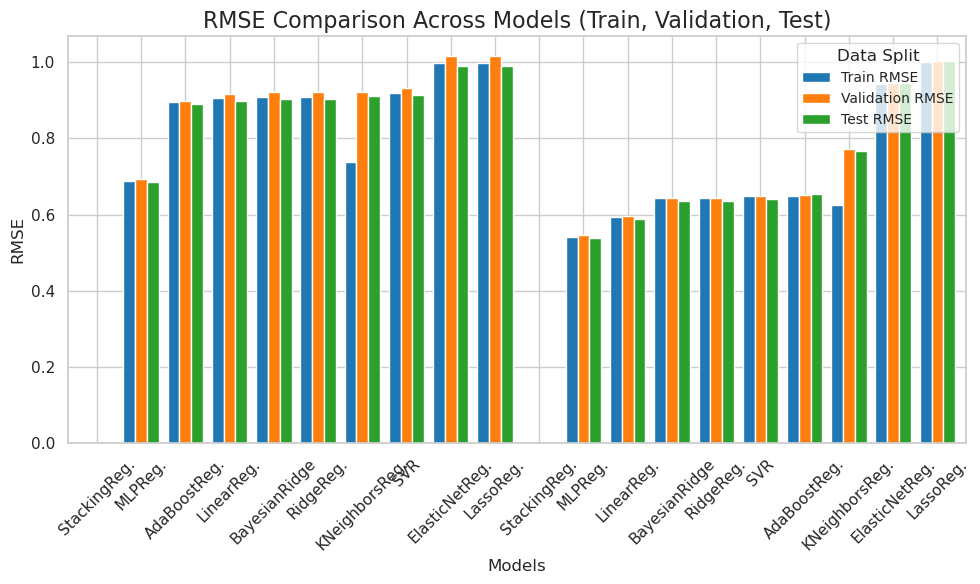

MAE plot saved as /media/omid/HDD2/QM9_sci/new250211/mae_model_comparison_results_homo_lumo_51_QM9_homo_lumo.png


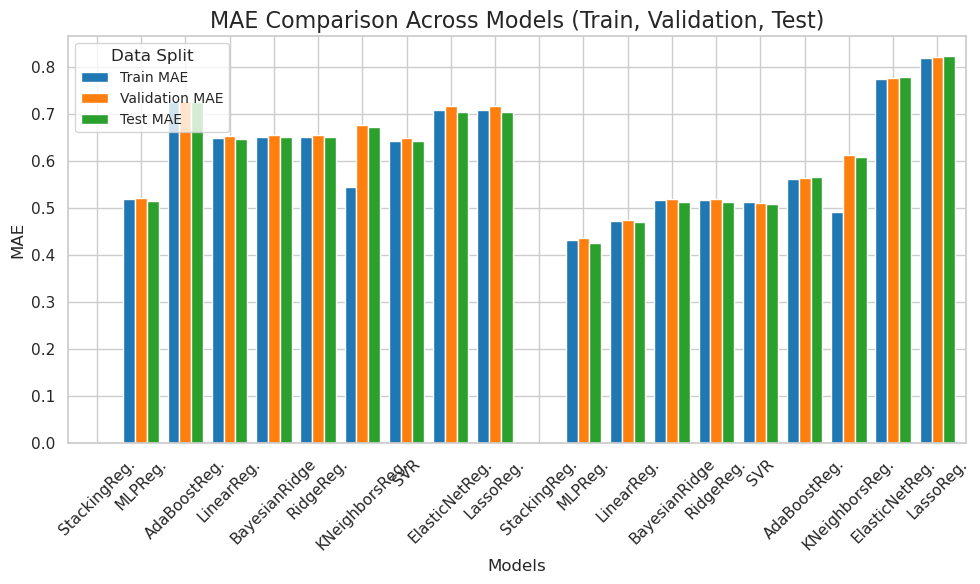

R2 plot saved as /media/omid/HDD2/QM9_sci/new250211/r2_model_comparison_results_homo_lumo_51_QM9_homo_lumo.png


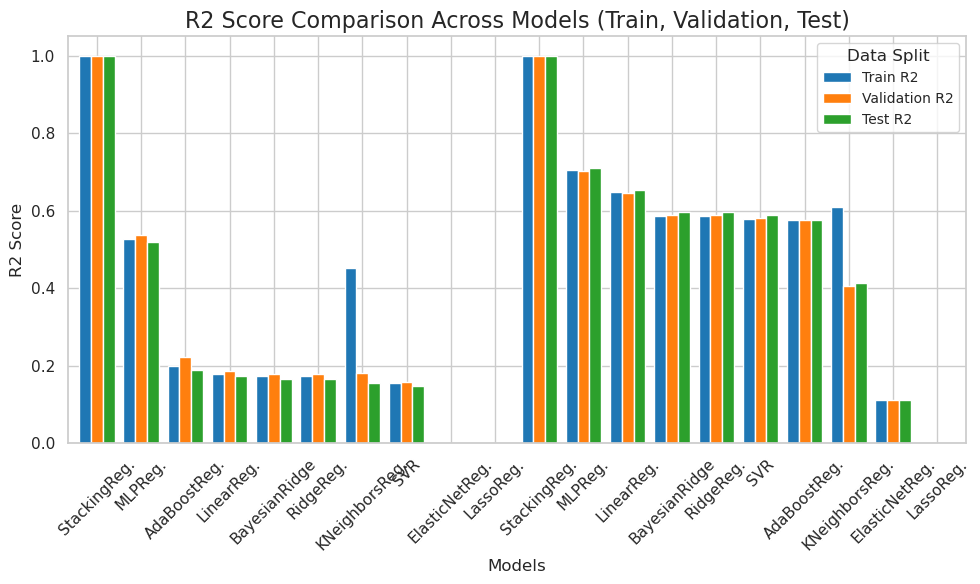

In [95]:
save_path = "/media/omid/HDD2/QM9_sci/new250211/"

# Create RMSE bar plot for each model across Train, Validation, and Test
plt.figure(figsize=(10, 6))
df_rmse = model_comparison_results_homo_lumo_51_QM9[['Model', 'Train RMSE', 'Validation RMSE', 'Test RMSE']].set_index('Model')
df_rmse.plot(kind='bar', width=0.8, color=['tab:blue', 'tab:orange', 'tab:green'], ax=plt.gca())
plt.title('RMSE Comparison Across Models (Train, Validation, Test)', fontsize=16)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Data Split', fontsize=10)
plt.tight_layout()
output_path_rmse = os.path.join(save_path, "rmse_model_comparison_results_homo_lumo_51_QM9.png")
plt.savefig(output_path_rmse, dpi=300, bbox_inches='tight')
print(f"RMSE plot saved as {output_path_rmse}")
plt.show()

# Create MAE bar plot for each model across Train, Validation, and Test
plt.figure(figsize=(10, 6))
df_rmse = model_comparison_results_homo_lumo_51_QM9[['Model', 'Train MAE', 'Validation MAE', 'Test MAE']].set_index('Model')
df_rmse.plot(kind='bar', width=0.8, color=['tab:blue', 'tab:orange', 'tab:green'], ax=plt.gca())
plt.title('MAE Comparison Across Models (Train, Validation, Test)', fontsize=16)
plt.ylabel('MAE', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Data Split', fontsize=10)
plt.tight_layout()
output_path_mae = os.path.join(save_path,"mae_model_comparison_results_homo_lumo_51_QM9_homo_lumo.png")
plt.savefig(output_path_mae, dpi=300, bbox_inches='tight')
print(f"MAE plot saved as {output_path_mae}")
plt.show()

# Create R2 bar plot for each model across Train, Validation, and Test
plt.figure(figsize=(10, 6))

df_r2 = model_comparison_results_homo_lumo_51_QM9[['Model', 'Train R2', 'Validation R2', 'Test R2']].set_index('Model')
df_r2.plot(kind='bar', width=0.8, color=['tab:blue', 'tab:orange', 'tab:green'], ax=plt.gca())
plt.title('R2 Score Comparison Across Models (Train, Validation, Test)', fontsize=16)
plt.ylabel('R2 Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Data Split', fontsize=10)
plt.tight_layout()
output_path_r2 = os.path.join(save_path,"r2_model_comparison_results_homo_lumo_51_QM9_homo_lumo.png")
plt.savefig(output_path_r2, dpi=300, bbox_inches='tight')
print(f"R2 plot saved as {output_path_r2}")
plt.show()

## Define 10-fold cross-validation

In [16]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Ensure the save path directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Define the number of folds
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Storage for fold-wise metrics
fold_results = []

# Loop through targets ('homo' and 'lumo')
for target in ['homo', 'lumo']:
    y_target = y[target]
    
    for model_name, model in regressors.items():
        # Storage for metrics across all folds
        fold_metrics = []
        
        # Perform 10-fold cross-validation
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_target.iloc[train_idx], y_target.iloc[test_idx]
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Predictions
            predictions_train = model.predict(X_train)
            predictions_test = model.predict(X_test)
            
            # Calculate metrics
            metrics = {
                "Fold": fold + 1,
                "Model": model_name,
                "Target": target,
                "Train RMSE": np.sqrt(mean_squared_error(y_train, predictions_train)),
                "Train MAE": np.mean(np.abs(y_train - predictions_train)),
                "Train R2": r2_score(y_train, predictions_train),
                "Test RMSE": np.sqrt(mean_squared_error(y_test, predictions_test)),
                "Test MAE": np.mean(np.abs(y_test - predictions_test)),
                "Test R2": r2_score(y_test, predictions_test),
            }
            fold_metrics.append(metrics)
        
        # Calculate average metrics across folds (unchanged)
        avg_metrics = {
            "Fold": "Average",
            "Model": model_name,
            "Target": target,
            "Train RMSE": np.mean([m["Train RMSE"] for m in fold_metrics]),
            "Train MAE": np.mean([m["Train MAE"] for m in fold_metrics]),
            "Train R2": np.mean([m["Train R2"] for m in fold_metrics]),
            "Test RMSE": np.mean([m["Test RMSE"] for m in fold_metrics]),
            "Test MAE": np.mean([m["Test MAE"] for m in fold_metrics]),
            "Test R2": np.mean([m["Test R2"] for m in fold_metrics]),
        }

        # Calculate standard deviation for each metric
        std_metrics = {
            "Fold": "STD",  # Label for standard deviation row
            "Model": model_name,
            "Target": target,
            "Train RMSE": np.std([m["Train RMSE"] for m in fold_metrics]),
            "Train MAE": np.std([m["Train MAE"] for m in fold_metrics]),
            "Train R2": np.std([m["Train R2"] for m in fold_metrics]),
            "Test RMSE": np.std([m["Test RMSE"] for m in fold_metrics]),
            "Test MAE": np.std([m["Test MAE"] for m in fold_metrics]),
            "Test R2": np.std([m["Test R2"] for m in fold_metrics]),
        }

        # Append both average and standard deviation to fold_metrics
        fold_metrics.append(avg_metrics)
        fold_metrics.append(std_metrics)
        
        # Append to overall results
        fold_results.extend(fold_metrics)

# Convert fold results to DataFrame
fold_results_df = pd.DataFrame(fold_results)

# Save fold-wise results to CSV
fold_results_csv = os.path.join(save_path, "fold_results_homo_lumo_10fold_51_QM9.csv")
fold_results_df.to_csv(fold_results_csv, index=False)
print(f"Fold-wise results saved to {fold_results_csv}")

# Display average and std metrics for each model
average_std_metrics_df = fold_results_df[fold_results_df["Fold"].isin(["Average", "STD"])]  # Filter for Average and STD rows
print(average_std_metrics_df)

# Save average and std metrics to a separate CSV
average_std_metrics_csv = os.path.join(save_path, "average_std_metrics_homo_lumo_10fold_51_QM9.csv")
average_std_metrics_df.to_csv(average_std_metrics_csv, index=False)
print(f"Average and STD metrics saved to {average_std_metrics_csv}")


Fold-wise results saved to /media/omid/HDD2/QM9_sci/10foldnew/250203/fold_results_homo_lumo_10fold_51_QM9.csv
        Fold                  Model Target  Train RMSE  Train MAE  \
10   Average    1 AdaBoostRegressor   homo    0.898952   0.731305   
11       STD    1 AdaBoostRegressor   homo    0.012045   0.014523   
22   Average        2 BayesianRidge   homo    0.909625   0.651048   
23       STD        2 BayesianRidge   homo    0.001001   0.000734   
34   Average  3 ElasticNetRegressor   homo    0.999999   0.707886   
35       STD  3 ElasticNetRegressor   homo    0.001251   0.000836   
46   Average  4 KNeighborsRegressor   homo    0.737286   0.543017   
47       STD  4 KNeighborsRegressor   homo    0.001293   0.001061   
58   Average     6 LinearRegression   homo    0.906071   0.648704   
59       STD     6 LinearRegression   homo    0.001004   0.000722   
70   Average       5 LassoRegressor   homo    0.999999   0.707886   
71       STD       5 LassoRegressor   homo    0.001251   0.000

In [19]:
import os
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Ensure the save path directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save fold-wise results to CSV
fold_results_csv = os.path.join(save_path, "fold_results_homo_lumo_10fold_51_QM9.csv")
fold_results_df.to_csv(fold_results_csv, index=False)
print(f"Fold-wise results saved to {fold_results_csv}")

# Display average and std metrics for each model
average_std_metrics_df = fold_results_df[fold_results_df["Fold"].isin(["Average", "STD"])]  # Filter for Average and STD rows
print(average_std_metrics_df)

# Save average and std metrics to a separate CSV
average_std_metrics_csv = os.path.join(save_path, "average_std_metrics_homo_lumo_10fold_51_QM9.csv")
average_std_metrics_df.to_csv(average_std_metrics_csv, index=False)
print(f"Average and STD metrics saved to {average_std_metrics_csv}")


Fold-wise results saved to /media/omid/HDD2/QM9_sci/10foldnew/250203/fold_results_homo_lumo_10fold_51_QM9.csv
        Fold                  Model Target  Train RMSE  Train MAE  \
10   Average    1 AdaBoostRegressor   homo    0.898952   0.731305   
11       STD    1 AdaBoostRegressor   homo    0.012045   0.014523   
22   Average        2 BayesianRidge   homo    0.909625   0.651048   
23       STD        2 BayesianRidge   homo    0.001001   0.000734   
34   Average  3 ElasticNetRegressor   homo    0.999999   0.707886   
35       STD  3 ElasticNetRegressor   homo    0.001251   0.000836   
46   Average  4 KNeighborsRegressor   homo    0.737286   0.543017   
47       STD  4 KNeighborsRegressor   homo    0.001293   0.001061   
58   Average     6 LinearRegression   homo    0.906071   0.648704   
59       STD     6 LinearRegression   homo    0.001004   0.000722   
70   Average       5 LassoRegressor   homo    0.999999   0.707886   
71       STD       5 LassoRegressor   homo    0.001251   0.000

## Visualizing 10-fold CV performance for HOMO energy

In [21]:
# File paths and data loading
# save_path = "/media/omid/HDD2/QM9_sci/"
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

input_file = "fold_results_homo_lumo_10fold_51_QM9.csv"
output_file = "filtered_fold_results_homo_10fold_61_QM9.csv"
fold_results_df = pd.read_csv(save_path + input_file)

# Filter DataFrame for rows with Target = 'homo'
filtered_df = fold_results_df[fold_results_df["Target"] == "homo"]

# Create a DataFrame for Train RMSE
train_rmse_folds = filtered_df[filtered_df["Fold"] != "Average"][["Fold", "Model", "Train RMSE", "Train MAE", "Train R2"]]

# Extract "Average" fold for Train RMSE and Test RMSE
train_rmse_avg = filtered_df[filtered_df["Fold"] == "Average"][["Fold", "Model", "Train RMSE", "Train MAE", "Train R2"]]
train_rmse_avg["Fold"] = "Average_tr"  # Change the fold label to "Average_train"

test_rmse_avg = filtered_df[filtered_df["Fold"] == "Average"][["Fold", "Model", "Test RMSE", "Test MAE", "Test R2"]]
test_rmse_avg["Fold"] = "Average_ts"  # Change the fold label to "Average_test"

# Create a new DataFrame for RMSE values
fold_df = pd.concat(
    [
        train_rmse_folds.rename(columns={"Train RMSE": "RMSE", "Train MAE": "MAE", "Train R2": "R2"}),
        train_rmse_avg.rename(columns={"Train RMSE": "RMSE", "Train MAE": "MAE", "Train R2": "R2"}),
        test_rmse_avg.rename(columns={"Test RMSE": "RMSE", "Test MAE": "MAE", "Test R2": "R2"})
    ],
    ignore_index=True
)

# Sort Fold column by custom logic
fold_df = fold_df.assign(
    FoldOrder=fold_df["Fold"].apply(
        lambda x: float(x.split("_")[0]) if x.isdigit() else float("inf")
    )
)
fold_df = fold_df.sort_values(by=["Model", "FoldOrder"], ascending=[True, True]).drop(
    columns=["FoldOrder"]
).reset_index(drop=True)

# Save the resulting DataFrame to a CSV file
output_path = save_path + output_file
# fold_df.to_csv(output_path, index=False)

print(f"Filtered results saved to: {output_path}")


Filtered results saved to: /media/omid/HDD2/QM9_sci/10foldnew/250203/filtered_fold_results_homo_10fold_61_QM9.csv


In [31]:
import pandas as pd
import re

# Load the data
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_homo_10fold_61_QM9.csv"
df = pd.read_csv(save_path + input_file)

# Step 1: Remove leading numbers and spaces and Replace 'Regressor' or 'Regression' with 'Reg.' in 'Model' column
def clean_model_name(name):
    if isinstance(name, str):
        # Remove leading numbers and spaces
        name = re.sub(r'^\d+\s+', '', name)
        # Replace 'Regressor' or 'Regression' with 'Reg.'
        name = re.sub(r'(Regressor|Regression)$', 'Reg.', name)
    return name

# Apply the cleaning function to the 'Model' column
df["Model"] = df["Model"].apply(clean_model_name)

# Step 2: Rename values in the 'Fold' column (not column names)
df['Fold'] = df['Fold'].replace({'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})

# Step 3: Save the modified DataFrame to a new CSV file
output_file = save_path + "filtered_fold_results_homo_10fold_61_QM9_modified.csv"
# df.to_csv(output_file, index=False)

In [32]:
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_homo_10fold_61_QM9_modified.csv"
fold_df = pd.read_csv(save_path + input_file)

In [35]:
fold_df

Fold         Model  RMSE   MAE    R2
0             1  AdaBoostReg. 0.884 0.717 0.219
1             2  AdaBoostReg. 0.892 0.719 0.203
2             3  AdaBoostReg. 0.906 0.739 0.181
3             4  AdaBoostReg. 0.888 0.725 0.214
4             5  AdaBoostReg. 0.913 0.747 0.165
..          ...           ...   ...   ...   ...
125           9  StackingReg. 0.000 0.000 1.000
126          10  StackingReg. 0.000 0.000 1.000
127         STD  StackingReg. 0.000 0.000 0.000
128  Avg. Train  StackingReg. 0.000 0.000 1.000
129   Avg. Test  StackingReg. 0.000 0.000 1.000

[130 rows x 5 columns]

Radar plot saved as radar_plot_rmse_fold_results_homo_10fold_61_QM9_with_test.png


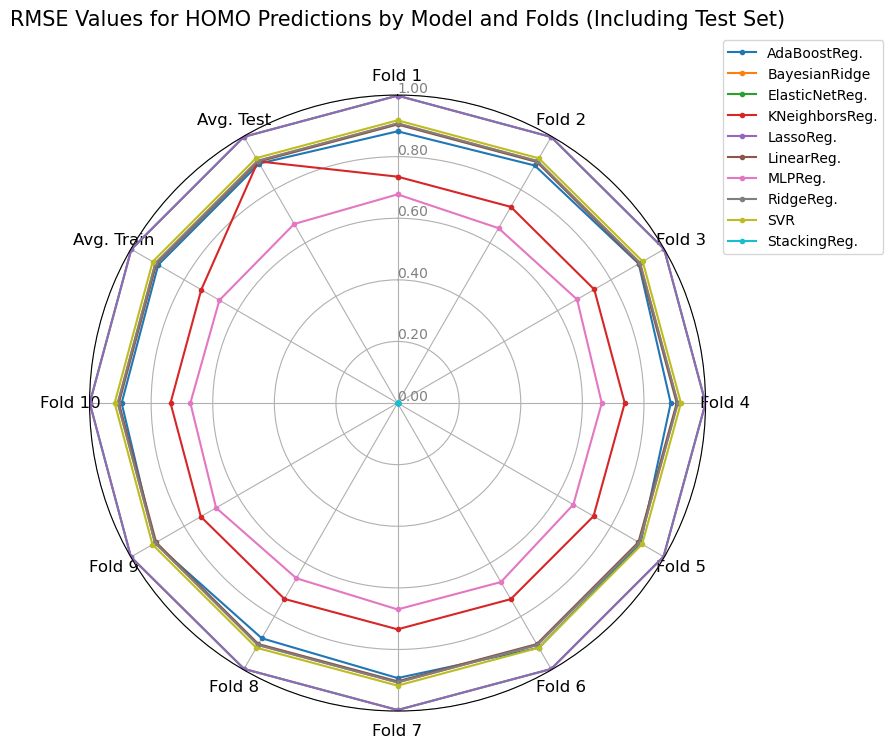

In [37]:
rmse_df = fold_df[["Fold", "Model", "RMSE"]]

# Prepare test results and model-wise data
test_results_dict = {model: rmse_df[rmse_df["Model"] == model].reset_index(drop=True) 
                     for model in rmse_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in rmse_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_rmse = test_df[test_df["Fold"] == "Avg. Test"]["RMSE"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]

# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['RMSE'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
# min_rmse = min(min(df['RMSE']) for df in df_dict.values())
# max_rmse = max(max(df['RMSE']) for df in df_dict.values())
min_rmse = min(min(df[df['Fold'] != "STD"]["RMSE"]) for df in df_dict.values())
max_rmse = max(max(df[df['Fold'] != "STD"]["RMSE"]) for df in df_dict.values())
tick_interval = (max_rmse - min_rmse) / 5  # Divide range into 5 intervals
yticks = [min_rmse + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_rmse, max_rmse)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('RMSE Values for HOMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_rmse_fold_results_homo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()


Radar plot saved as radar_plot_r2_fold_results_homo_10fold_61_QM9_with_test.png


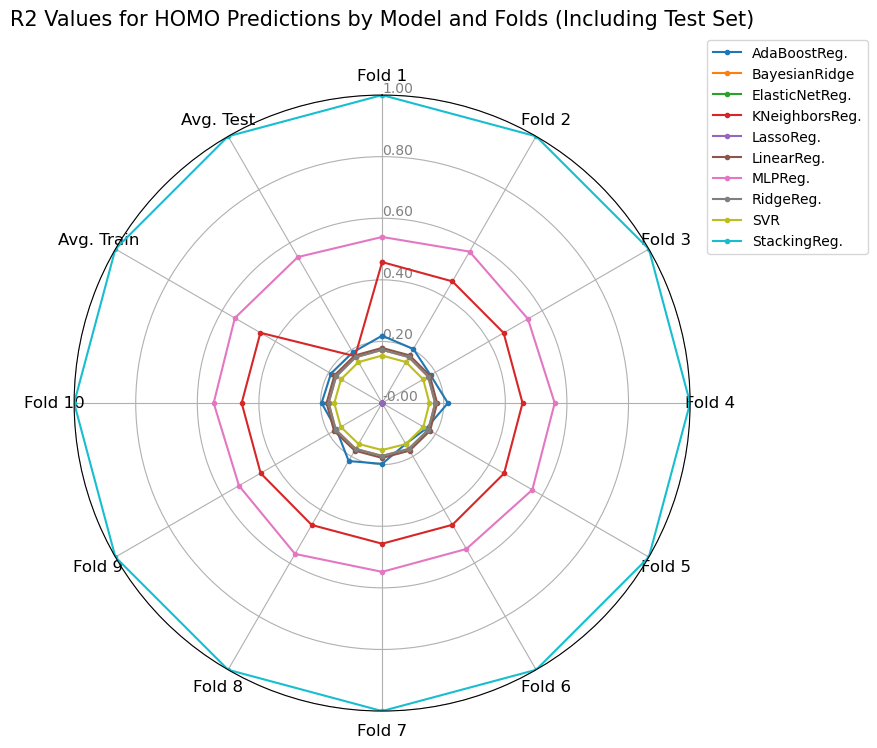

In [38]:
r2_df = fold_df[["Fold", "Model", "R2"]]

# Prepare test results and model-wise data
test_results_dict = {model: r2_df[r2_df["Model"] == model].reset_index(drop=True) 
                     for model in r2_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in r2_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_r2 = test_df[test_df["Fold"] == "Avg. Test"]["R2"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]

# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['R2'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
# min_r2 = min(min(df['R2']) for df in df_dict.values())
# max_r2 = max(max(df['R2']) for df in df_dict.values())
min_r2 = min(min(df[df['Fold'] != "STD"]["R2"]) for df in df_dict.values())
max_r2 = max(max(df[df['Fold'] != "STD"]["R2"]) for df in df_dict.values())
tick_interval = (max_r2 - min_r2) / 5  # Divide range into 5 intervals
yticks = [min_r2 + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_r2, max_r2)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('R2 Values for HOMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_r2_fold_results_homo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()

Radar plot saved as radar_plot_mae_fold_results_homo_10fold_61_QM9_with_test.png


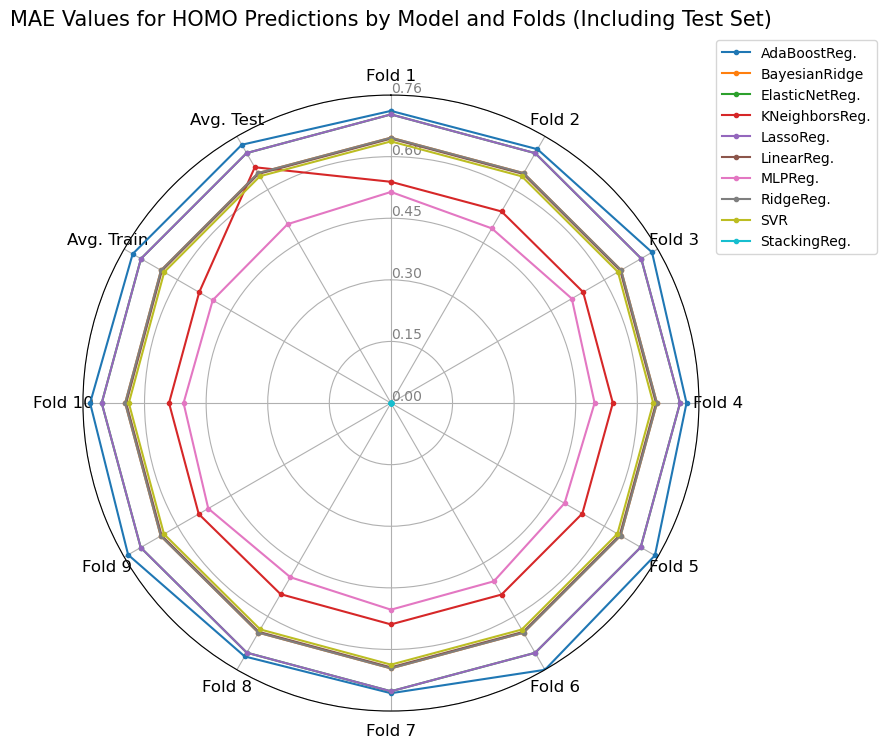

In [39]:
mae_df = fold_df[["Fold", "Model", "MAE"]]

# Prepare test results and model-wise data
test_results_dict = {model: mae_df[mae_df["Model"] == model].reset_index(drop=True) 
                     for model in mae_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in mae_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_mae = test_df[test_df["Fold"] == "Avg. Test"]["MAE"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]

# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['MAE'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
# min_mae = min(min(df['MAE']) for df in df_dict.values())
# max_mae = max(max(df['MAE']) for df in df_dict.values())
min_mae = min(min(df[df['Fold'] != "STD"]["MAE"]) for df in df_dict.values())
max_mae = max(max(df[df['Fold'] != "STD"]["MAE"]) for df in df_dict.values())
tick_interval = (max_mae - min_mae) / 5  # Divide range into 5 intervals
yticks = [min_mae + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_mae, max_mae)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('MAE Values for HOMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_mae_fold_results_homo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()

In [41]:
import re

# Load the data
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_homo_10fold_61_QM9.csv"
foldwise_model_results_10fold_cv_ANA_homo = pd.read_csv(save_path + input_file)

# Create horizontal DataFrames for each metric
mae_df = foldwise_model_results_10fold_cv_ANA_homo.pivot(index='Model', columns='Fold', values='MAE').reset_index()
rmse_df = foldwise_model_results_10fold_cv_ANA_homo.pivot(index='Model', columns='Fold', values='RMSE').reset_index()
r2_df = foldwise_model_results_10fold_cv_ANA_homo.pivot(index='Model', columns='Fold', values='R2').reset_index()

# Rename columns to include "Fold" prefix and "Average"
def rename_columns(df):
    # Check for numeric fold names and rename appropriately
    df.columns = ['Model'] + [
        f"Fold {col}" if isinstance(col, (int, float)) or str(col).isdigit() else str(col)
        for col in df.columns[1:]
    ]
    return df

mae_df = rename_columns(mae_df).round(3)
rmse_df = rename_columns(rmse_df).round(3)
r2_df = rename_columns(r2_df).round(3)

# Rename 'Average_tr' to 'Avg. Train' and 'Average_ts' to 'Avg. Test'
mae_df = mae_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})
rmse_df = rmse_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})
r2_df = r2_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})

# Function to clean model names by removing leading numbers and spaces and replacing "Regressor" with "Reg."
def clean_model_name(name):
    name = re.sub(r'^\d+\s+', '', name)  # Remove leading digits and spaces
    name = re.sub(r'(Regressor|Regression)$', 'Reg.', name)  # Replace "Regressor" with "Reg."
    return name

# Apply the cleaning function to the 'Model' column in each DataFrame
mae_df["Model"] = mae_df["Model"].apply(clean_model_name)
rmse_df["Model"] = rmse_df["Model"].apply(clean_model_name)
r2_df["Model"] = r2_df["Model"].apply(clean_model_name)

# Display the DataFrames with float format set to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save results to CSV
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
mae_df.to_csv(save_path+"MAE_results_10fold_cv_ANA_homo.csv", index=False)
rmse_df.to_csv(save_path+"RMSE_results_10fold_cv_ANA_homo.csv", index=False)
r2_df.to_csv(save_path+"R2_results_10fold_cv_ANA_homo.csv", index=False)

In [42]:
mae_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.717    0.738   0.719   0.739   0.725   0.747   0.755   
1   BayesianRidge   0.651    0.652   0.651   0.652   0.652   0.650   0.650   
2  ElasticNetReg.   0.708    0.709   0.708   0.709   0.709   0.707   0.707   
3  KNeighborsReg.   0.543    0.544   0.543   0.544   0.544   0.542   0.542   
4       LassoReg.   0.708    0.709   0.708   0.709   0.709   0.707   0.707   
5      LinearReg.   0.648    0.649   0.649   0.649   0.650   0.648   0.648   
6         MLPReg.   0.518    0.509   0.495   0.512   0.499   0.492   0.505   
7       RidgeReg.   0.651    0.652   0.651   0.652   0.652   0.650   0.650   
8             SVR   0.642    0.643   0.642   0.643   0.643   0.641   0.641   
9    StackingReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.712   0.717   0.744       0.731      0.731 0.015  
1   0.651   0.650   0.652       0.651      0.651 0.001  
2   0.707   0.707   0.709       0.708      0.708 0.001  
3   0.543   0.541   0.544       0.543      0.668 0.001  
4   0.707   0.707   0.709       0.708      0.708 0.001  
5   0.648   0.648   0.649       0.649      0.649 0.001  
6   0.507   0.493   0.517       0.505      0.507 0.009  
7   0.651   0.650   0.652       0.651      0.651 0.001  
8   0.642   0.641   0.643       0.642      0.642 0.001  
9   0.000   0.000   0.000       0.000      0.000 0.000

In [43]:
rmse_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.884    0.898   0.892   0.906   0.888   0.913   0.919   
1   BayesianRidge   0.910    0.910   0.909   0.911   0.912   0.908   0.909   
2  ElasticNetReg.   1.000    1.001   0.999   1.001   1.002   0.999   0.999   
3  KNeighborsReg.   0.736    0.738   0.737   0.739   0.739   0.736   0.736   
4       LassoReg.   1.000    1.001   0.999   1.001   1.002   0.999   0.999   
5      LinearReg.   0.906    0.907   0.906   0.907   0.908   0.905   0.905   
6         MLPReg.   0.679    0.674   0.657   0.674   0.664   0.660   0.672   
7       RidgeReg.   0.910    0.910   0.909   0.911   0.912   0.908   0.909   
8             SVR   0.920    0.920   0.919   0.921   0.922   0.919   0.919   
9    StackingReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.895   0.883   0.912       0.899      0.900 0.012  
1   0.909   0.909   0.910       0.910      0.910 0.001  
2   0.998   0.999   1.001       1.000      1.000 0.001  
3   0.736   0.736   0.739       0.737      0.908 0.001  
4   0.998   0.999   1.001       1.000      1.000 0.001  
5   0.905   0.905   0.907       0.906      0.906 0.001  
6   0.671   0.658   0.682       0.669      0.673 0.008  
7   0.909   0.909   0.910       0.910      0.910 0.001  
8   0.919   0.919   0.921       0.920      0.920 0.001  
9   0.000   0.000   0.000       0.000      0.000 0.000

In [44]:
r2_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.219    0.196   0.203   0.181   0.214   0.165   0.153   
1   BayesianRidge   0.173    0.174   0.172   0.172   0.172   0.173   0.172   
2  ElasticNetReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   
3  KNeighborsReg.   0.458    0.456   0.456   0.455   0.456   0.457   0.456   
4       LassoReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   
5      LinearReg.   0.179    0.180   0.179   0.179   0.179   0.180   0.178   
6         MLPReg.   0.539    0.547   0.568   0.547   0.560   0.563   0.547   
7       RidgeReg.   0.173    0.174   0.172   0.172   0.172   0.173   0.172   
8             SVR   0.154    0.155   0.154   0.154   0.154   0.155   0.154   
9    StackingReg.   1.000    1.000   1.000   1.000   1.000   1.000   1.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.197   0.217   0.171       0.192      0.190 0.022  
1   0.172   0.172   0.174       0.173      0.172 0.001  
2   0.000   0.000   0.000       0.000     -0.000 0.000  
3   0.457   0.457   0.455       0.456      0.175 0.001  
4   0.000   0.000   0.000       0.000     -0.000 0.000  
5   0.178   0.178   0.180       0.179      0.178 0.001  
6   0.548   0.566   0.537       0.552      0.547 0.011  
7   0.172   0.172   0.174       0.173      0.172 0.001  
8   0.153   0.153   0.155       0.154      0.154 0.001  
9   1.000   1.000   1.000       1.000      1.000 0.000

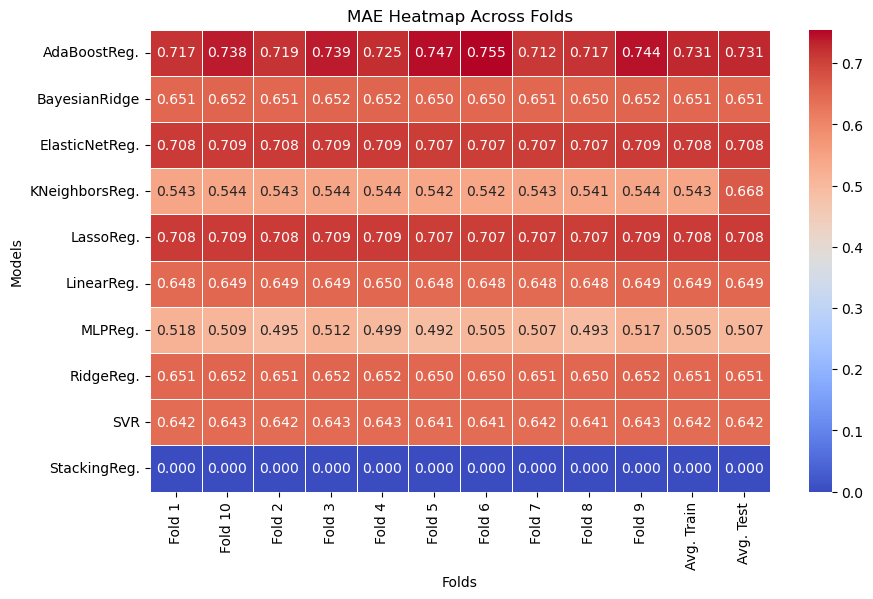

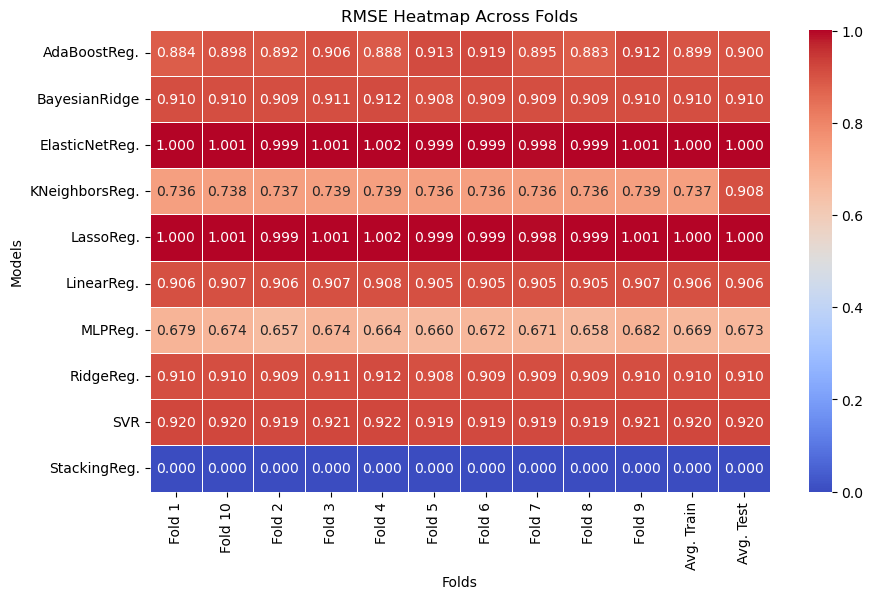

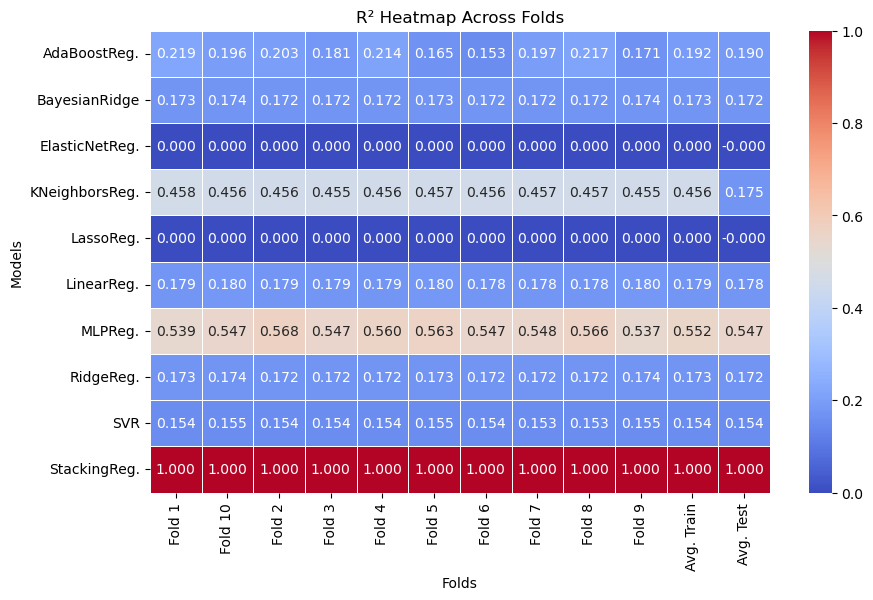

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Remove the 'STD' fold if it exists in the DataFrame
mae_df = mae_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for MAE values
sns.heatmap(mae_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("MAE Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "mae_heat_homo.png", dpi=300)
plt.show()

rmse_df = rmse_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for RMSE values
sns.heatmap(rmse_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("RMSE Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "rmse_heat_homo.png", dpi=300)
plt.show()

r2_df = r2_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for R² values
sns.heatmap(r2_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("R² Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "r2_heat_homo.png", dpi=300)
plt.show()

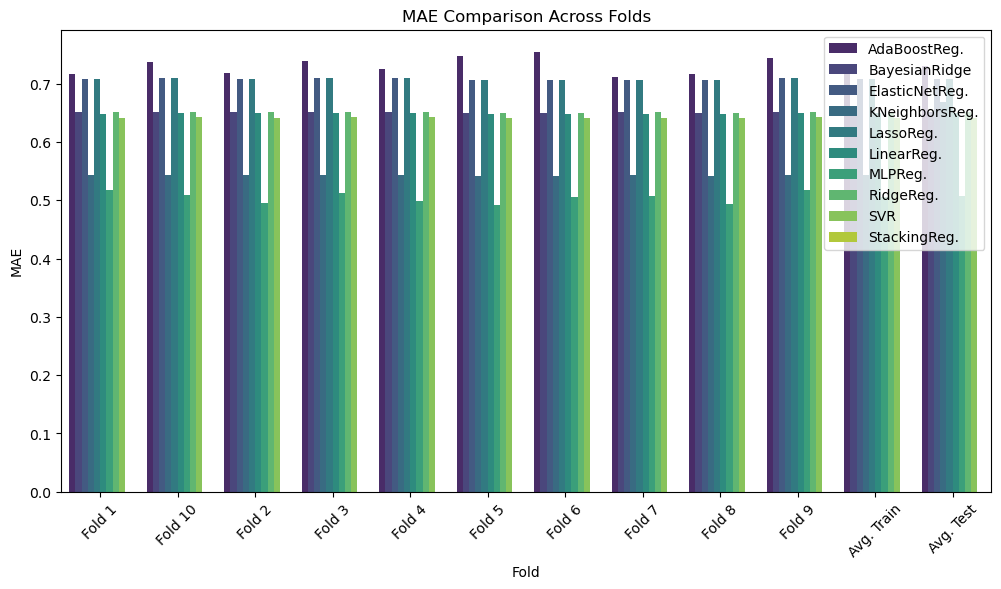

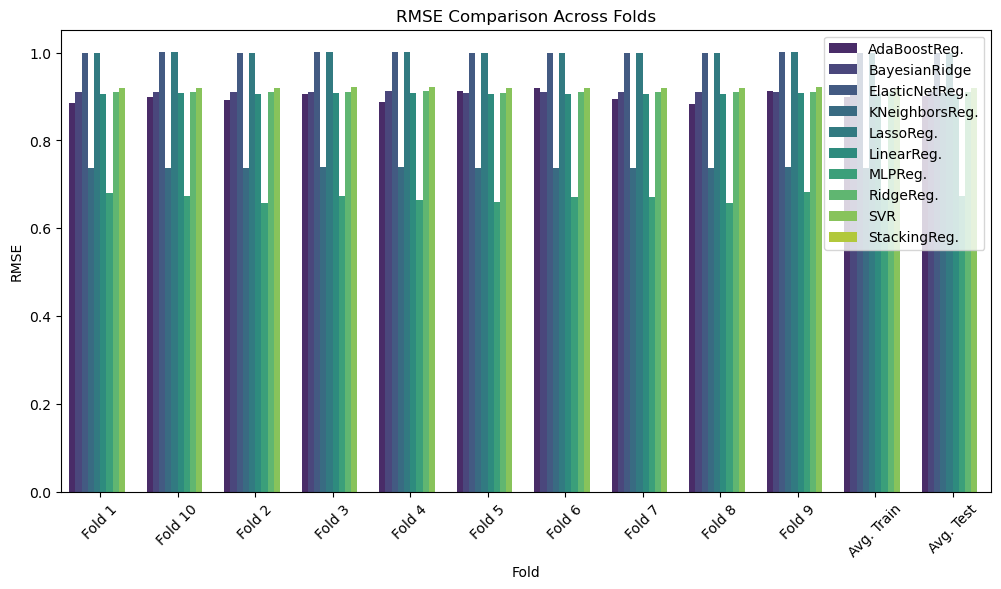

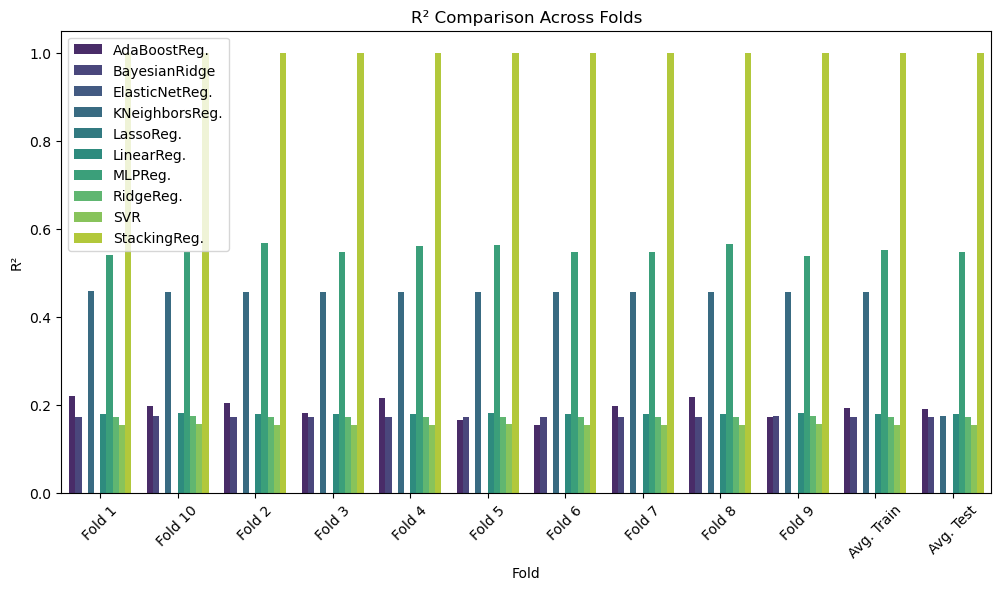

In [46]:
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Remove the 'STD' fold if it exists in the DataFrame
mae_df = mae_df.drop(columns=["STD"], errors="ignore")
mae_df_melted = mae_df.melt(id_vars="Model", var_name="Fold", value_name="MAE")

plt.figure(figsize=(12, 6))
sns.barplot(data=mae_df_melted, x="Fold", y="MAE", hue="Model", palette="viridis")
plt.title("MAE Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "mae_all_folds_homo.png", dpi=300)
plt.show()

# Remove the 'STD' fold if it exists in the DataFrame
rmse_df = rmse_df.drop(columns=["STD"], errors="ignore")
rmse_df_melted = rmse_df.melt(id_vars="Model", var_name="Fold", value_name="RMSE")

plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df_melted, x="Fold", y="RMSE", hue="Model", palette="viridis")
plt.title("RMSE Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "rmse_all_folds_homo.png", dpi=300)
plt.show()

# Remove the 'STD' fold if it exists in the DataFrame
r2_df = r2_df.drop(columns=["STD"], errors="ignore")
r2_df_melted = r2_df.melt(id_vars="Model", var_name="Fold", value_name="R²")

plt.figure(figsize=(12, 6))
sns.barplot(data=r2_df_melted, x="Fold", y="R²", hue="Model", palette="viridis")
plt.title("R² Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "r2_all_folds_homo.png", dpi=300)
plt.show()

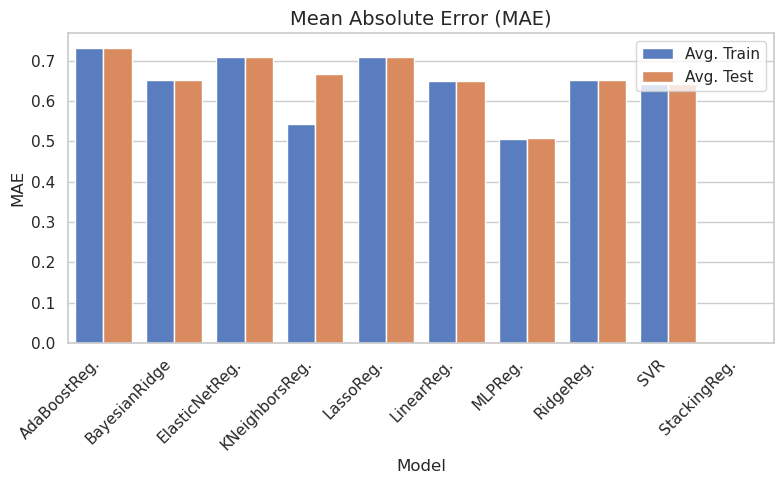

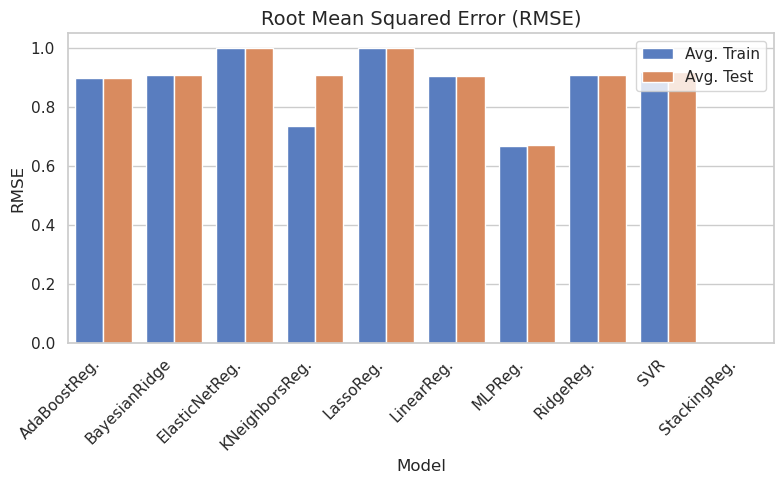

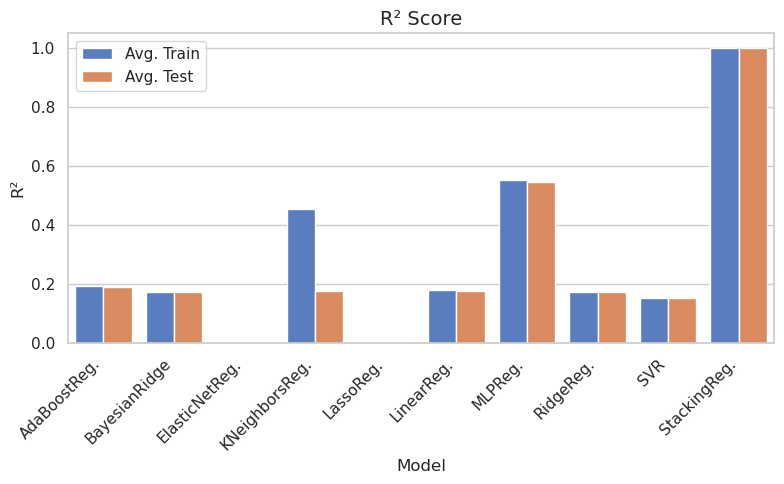

In [47]:
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Select only the "Model", "Average_tr", and "Average_ts" columns
mae_avg_df = mae_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="MAE")
rmse_avg_df = rmse_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="RMSE")
r2_avg_df = r2_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="R²")

# Set style
sns.set(style="whitegrid")

# Plot MAE
plt.figure(figsize=(8, 5))
sns.barplot(data=mae_avg_df, x="Model", y="MAE", hue="Fold", palette="muted")
plt.title("Mean Absolute Error (MAE)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "mae_avg_tr_ts_homo.png", dpi=300)
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 5))
sns.barplot(data=rmse_avg_df, x="Model", y="RMSE", hue="Fold", palette="muted")
plt.title("Root Mean Squared Error (RMSE)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "rmse_avg_tr_ts_homo.png", dpi=300)
plt.show()

# Plot R²
plt.figure(figsize=(8, 5))
sns.barplot(data=r2_avg_df, x="Model", y="R²", hue="Fold", palette="muted")
plt.title("R² Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "r2_avg_tr_ts_homo.png", dpi=300)
plt.show()

In [48]:
rmse_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.884    0.898   0.892   0.906   0.888   0.913   0.919   
1   BayesianRidge   0.910    0.910   0.909   0.911   0.912   0.908   0.909   
2  ElasticNetReg.   1.000    1.001   0.999   1.001   1.002   0.999   0.999   
3  KNeighborsReg.   0.736    0.738   0.737   0.739   0.739   0.736   0.736   
4       LassoReg.   1.000    1.001   0.999   1.001   1.002   0.999   0.999   
5      LinearReg.   0.906    0.907   0.906   0.907   0.908   0.905   0.905   
6         MLPReg.   0.679    0.674   0.657   0.674   0.664   0.660   0.672   
7       RidgeReg.   0.910    0.910   0.909   0.911   0.912   0.908   0.909   
8             SVR   0.920    0.920   0.919   0.921   0.922   0.919   0.919   
9    StackingReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test  
0   0.895   0.883   0.912       0.899      0.900  
1   0.909   0.909   0.910       0.910      0.910  
2   0.998   0.999   1.001       1.000      1.000  
3   0.736   0.736   0.739       0.737      0.908  
4   0.998   0.999   1.001       1.000      1.000  
5   0.905   0.905   0.907       0.906      0.906  
6   0.671   0.658   0.682       0.669      0.673  
7   0.909   0.909   0.910       0.910      0.910  
8   0.919   0.919   0.921       0.920      0.920  
9   0.000   0.000   0.000       0.000      0.000

In [49]:
r2_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.219    0.196   0.203   0.181   0.214   0.165   0.153   
1   BayesianRidge   0.173    0.174   0.172   0.172   0.172   0.173   0.172   
2  ElasticNetReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   
3  KNeighborsReg.   0.458    0.456   0.456   0.455   0.456   0.457   0.456   
4       LassoReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   
5      LinearReg.   0.179    0.180   0.179   0.179   0.179   0.180   0.178   
6         MLPReg.   0.539    0.547   0.568   0.547   0.560   0.563   0.547   
7       RidgeReg.   0.173    0.174   0.172   0.172   0.172   0.173   0.172   
8             SVR   0.154    0.155   0.154   0.154   0.154   0.155   0.154   
9    StackingReg.   1.000    1.000   1.000   1.000   1.000   1.000   1.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test  
0   0.197   0.217   0.171       0.192      0.190  
1   0.172   0.172   0.174       0.173      0.172  
2   0.000   0.000   0.000       0.000     -0.000  
3   0.457   0.457   0.455       0.456      0.175  
4   0.000   0.000   0.000       0.000     -0.000  
5   0.178   0.178   0.180       0.179      0.178  
6   0.548   0.566   0.537       0.552      0.547  
7   0.172   0.172   0.174       0.173      0.172  
8   0.153   0.153   0.155       0.154      0.154  
9   1.000   1.000   1.000       1.000      1.000

## Visualizing 10-fold CV performance for LUMO energy

In [50]:
# File paths and data loading
# save_path = "/media/omid/HDD2/QM9_sci/"
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "fold_results_homo_lumo_10fold_51_QM9.csv"
output_file = "filtered_fold_results_lumo_10fold_61_QM9.csv"
fold_results_df = pd.read_csv(save_path + input_file)

# Filter DataFrame for rows with Target = 'lumo'
filtered_df = fold_results_df[fold_results_df["Target"] == "lumo"]

# Create a DataFrame for Train RMSE
train_rmse_folds = filtered_df[filtered_df["Fold"] != "Average"][["Fold", "Model", "Train RMSE", "Train MAE", "Train R2"]]

# Extract "Average" fold for Train RMSE and Test RMSE
train_rmse_avg = filtered_df[filtered_df["Fold"] == "Average"][["Fold", "Model", "Train RMSE", "Train MAE", "Train R2"]]
train_rmse_avg["Fold"] = "Average_tr"  # Change the fold label to "Average_train"

test_rmse_avg = filtered_df[filtered_df["Fold"] == "Average"][["Fold", "Model", "Test RMSE", "Test MAE", "Test R2"]]
test_rmse_avg["Fold"] = "Average_ts"  # Change the fold label to "Average_test"

# Create a new DataFrame for RMSE values
fold_df = pd.concat(
    [
        train_rmse_folds.rename(columns={"Train RMSE": "RMSE", "Train MAE": "MAE", "Train R2": "R2"}),
        train_rmse_avg.rename(columns={"Train RMSE": "RMSE", "Train MAE": "MAE", "Train R2": "R2"}),
        test_rmse_avg.rename(columns={"Test RMSE": "RMSE", "Test MAE": "MAE", "Test R2": "R2"})
    ],
    ignore_index=True
)

# Sort Fold column by custom logic
fold_df = fold_df.assign(
    FoldOrder=fold_df["Fold"].apply(
        lambda x: float(x.split("_")[0]) if x.isdigit() else float("inf")
    )
)
fold_df = fold_df.sort_values(by=["Model", "FoldOrder"], ascending=[True, True]).drop(
    columns=["FoldOrder"]
).reset_index(drop=True)

# Save the resulting DataFrame to a CSV file
output_path = save_path + output_file
fold_df.to_csv(output_path, index=False)

print(f"Filtered results saved to: {output_path}")

Filtered results saved to: /media/omid/HDD2/QM9_sci/10foldnew/250203/filtered_fold_results_lumo_10fold_61_QM9.csv


In [55]:
import pandas as pd
import re

# Load the data
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_lumo_10fold_61_QM9.csv"
df = pd.read_csv(save_path + input_file)

# Step 1: Remove leading numbers and spaces and Replace 'Regressor' or 'Regression' with 'Reg.' in 'Model' column
def clean_model_name(name):
    if isinstance(name, str):
        # Remove leading numbers and spaces
        name = re.sub(r'^\d+\s+', '', name)
        # Replace 'Regressor' or 'Regression' with 'Reg.'
        name = re.sub(r'(Regressor|Regression)$', 'Reg.', name)
    return name

# Apply the cleaning function to the 'Model' column
df["Model"] = df["Model"].apply(clean_model_name)

# Step 2: Rename values in the 'Fold' column (not column names)
df['Fold'] = df['Fold'].replace({'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})

# Step 3: Save the modified DataFrame to a new CSV file
output_file = save_path + "filtered_fold_results_lumo_10fold_61_QM9_modified.csv"
df.to_csv(output_file, index=False)

In [58]:
# save_path = "/media/omid/HDD2/QM9_sci/"
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_lumo_10fold_61_QM9_modified.csv"
fold_df = pd.read_csv(save_path + input_file)
fold_df

Fold         Model  RMSE   MAE    R2
0             1  AdaBoostReg. 0.640 0.554 0.590
1             2  AdaBoostReg. 0.650 0.563 0.577
2             3  AdaBoostReg. 0.644 0.554 0.584
3             4  AdaBoostReg. 0.642 0.553 0.588
4             5  AdaBoostReg. 0.659 0.572 0.567
..          ...           ...   ...   ...   ...
125           9  StackingReg. 0.000 0.000 1.000
126          10  StackingReg. 0.000 0.000 1.000
127         STD  StackingReg. 0.000 0.000 0.000
128  Avg. Train  StackingReg. 0.000 0.000 1.000
129   Avg. Test  StackingReg. 0.000 0.000 1.000

[130 rows x 5 columns]

Radar plot saved as radar_plot_rmse_fold_results_lumo_10fold_61_QM9_with_test.png


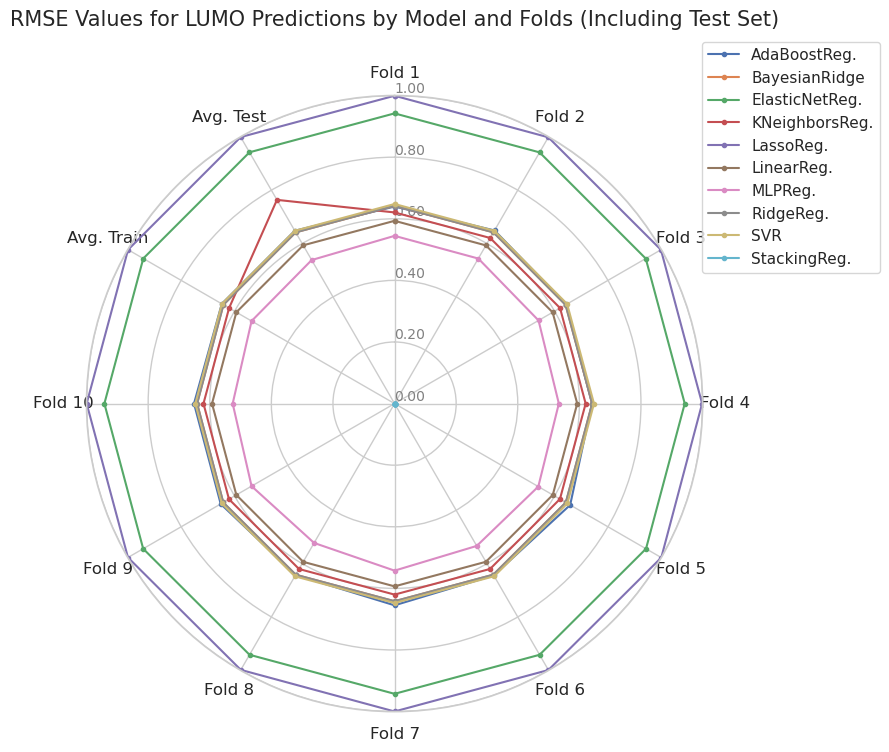

In [59]:
rmse_df = fold_df[["Fold", "Model", "RMSE"]]

# Prepare test results and model-wise data
test_results_dict = {model: rmse_df[rmse_df["Model"] == model].reset_index(drop=True) 
                     for model in rmse_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in rmse_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_rmse = test_df[test_df["Fold"] == "Avg. Test"]["RMSE"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]

# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['RMSE'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
# min_rmse = min(min(df['RMSE']) for df in df_dict.values())
# max_rmse = max(max(df['RMSE']) for df in df_dict.values())
min_rmse = min(min(df[df['Fold'] != "STD"]["RMSE"]) for df in df_dict.values())
max_rmse = max(max(df[df['Fold'] != "STD"]["RMSE"]) for df in df_dict.values())
tick_interval = (max_rmse - min_rmse) / 5  # Divide range into 5 intervals
yticks = [min_rmse + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_rmse, max_rmse)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('RMSE Values for LUMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_rmse_fold_results_lumo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()

Radar plot saved as radar_plot_r2_fold_results_lumo_10fold_61_QM9_with_test.png


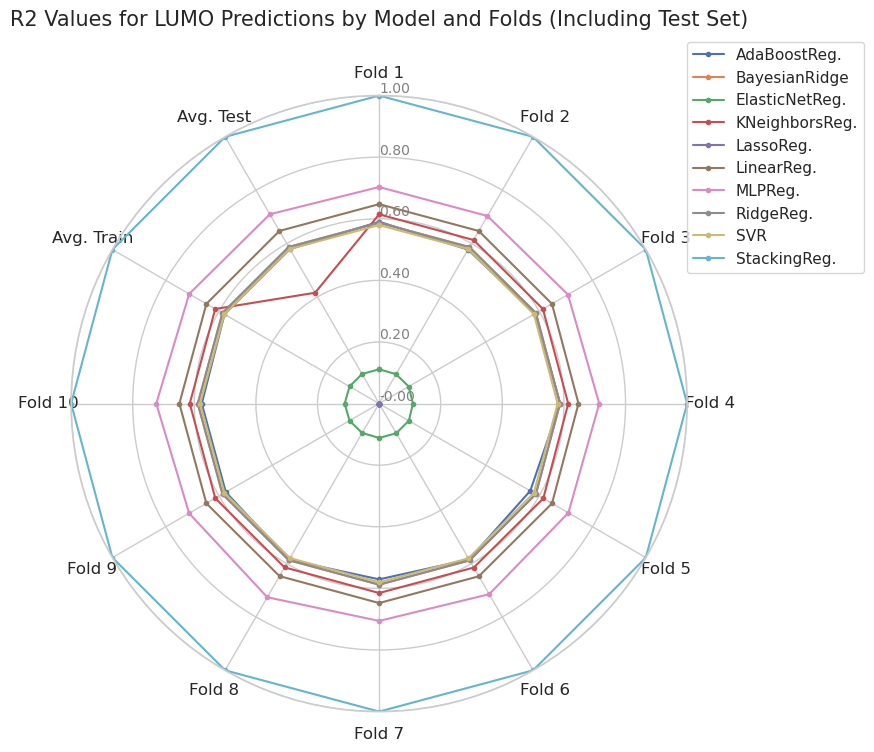

In [60]:
r2_df = fold_df[["Fold", "Model", "R2"]]

# Prepare test results and model-wise data
test_results_dict = {model: r2_df[r2_df["Model"] == model].reset_index(drop=True) 
                     for model in r2_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in r2_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_r2 = test_df[test_df["Fold"] == "Avg. Test"]["R2"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]


# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['R2'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
# min_r2 = min(min(df['R2']) for df in df_dict.values())
# max_r2 = max(max(df['R2']) for df in df_dict.values())
min_r2 = min(min(df[df['Fold'] != "STD"]["R2"]) for df in df_dict.values())
max_r2 = max(max(df[df['Fold'] != "STD"]["R2"]) for df in df_dict.values())
tick_interval = (max_r2 - min_r2) / 5  # Divide range into 5 intervals
yticks = [min_r2 + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_r2, max_r2)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('R2 Values for LUMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_r2_fold_results_lumo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()

Radar plot saved as radar_plot_mae_fold_results_lumo_10fold_61_QM9_with_test.png


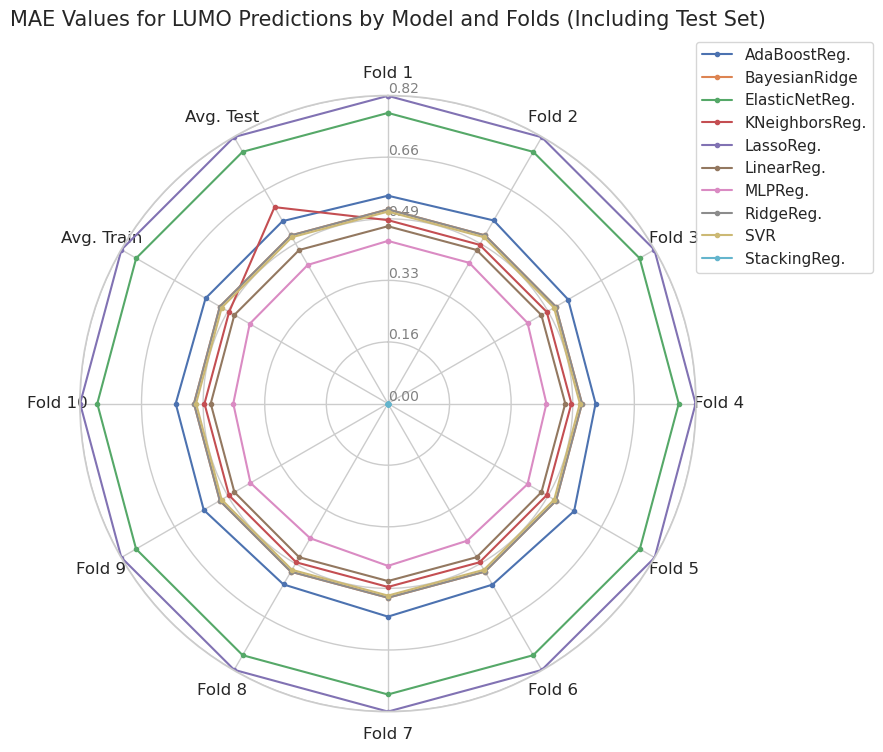

In [61]:
mae_df = fold_df[["Fold", "Model", "MAE"]]

# Prepare test results and model-wise data
test_results_dict = {model: mae_df[mae_df["Model"] == model].reset_index(drop=True) 
                     for model in mae_df["Model"].unique()}

# Create a dictionary of DataFrames grouped by Model
df_dict = {model: group.reset_index(drop=True) for model, group in mae_df.groupby('Model')}

# Update df_dict with test results
for model_name, test_df in test_results_dict.items():
    if model_name in df_dict:
        test_mae = test_df[test_df["Fold"] == "Avg. Test"]["MAE"].tolist()

# Extract unique folds (including 'Average' and 'Test')
# folds = df_dict[list(df_dict.keys())[0]]['Fold'].tolist()
folds = [fold for fold in df_dict[list(df_dict.keys())[0]]['Fold'].tolist() if fold != "STD"]

# Add "Fold" prefix to the folds and "Test" to the test data
fold_labels = [f"Fold {fold}" if fold not in ["Avg. Train", "Avg. Test"] else fold for fold in folds]

# Number of variables (including test)
num_vars = len(folds)

# Set up the radar plot
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot data for each model
for model_name, df in df_dict.items():
    filtered_df = df[df['Fold'] != "STD"]
    values = filtered_df['MAE'].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, label=model_name, marker='o', markersize=3)

# Customize the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set up the folds as the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(fold_labels, fontsize=12)

# Add labels for the radial axis
ax.set_rlabel_position(0)

# Dynamically calculate the radial ticks
min_mae = min(min(df[df['Fold'] != "STD"]["MAE"]) for df in df_dict.values())
max_mae = max(max(df[df['Fold'] != "STD"]["MAE"]) for df in df_dict.values())
# min_mae = min(min(df['MAE']) for df in df_dict.values())
# max_mae = max(max(df['MAE']) for df in df_dict.values())
tick_interval = (max_mae - min_mae) / 5  # Divide range into 5 intervals
yticks = [min_mae + i * tick_interval for i in range(6)]  # Create 6 ticks (including max)
ytick_labels = [f"{tick:.2f}" for tick in yticks]  # Format labels with 2 decimal places

# Set the radial axis ticks dynamically
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, color="grey", fontsize=10)
ax.set_ylim(min_mae, max_mae)  # Set the radial axis limits

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title
plt.title('MAE Values for LUMO Predictions by Model and Folds (Including Test Set)', size=15, y=1.1)

# Save and show the plot
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
output_path = "radar_plot_mae_fold_results_lumo_10fold_61_QM9_with_test.png"
plt.savefig(save_path+output_path, dpi=300, bbox_inches='tight')
print(f"Radar plot saved as {output_path}")

plt.show()

In [74]:
import re

# Load the data
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
input_file = "filtered_fold_results_lumo_10fold_61_QM9.csv"
foldwise_model_results_10fold_cv_ANA_lumo = pd.read_csv(save_path + input_file)

# Create horizontal DataFrames for each metric
mae_df = foldwise_model_results_10fold_cv_ANA_lumo.pivot(index='Model', columns='Fold', values='MAE').reset_index()
rmse_df = foldwise_model_results_10fold_cv_ANA_lumo.pivot(index='Model', columns='Fold', values='RMSE').reset_index()
r2_df = foldwise_model_results_10fold_cv_ANA_lumo.pivot(index='Model', columns='Fold', values='R2').reset_index()

# Rename columns to include "Fold" prefix and "Average"
def rename_columns(df):
    # Check for numeric fold names and rename appropriately
    df.columns = ['Model'] + [
        f"Fold {col}" if isinstance(col, (int, float)) or str(col).isdigit() else str(col)
        for col in df.columns[1:]
    ]
    return df

mae_df = rename_columns(mae_df).round(3)
rmse_df = rename_columns(rmse_df).round(3)
r2_df = rename_columns(r2_df).round(3)

# Rename 'Average_tr' to 'Avg. Train' and 'Average_ts' to 'Avg. Test'
mae_df = mae_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})
rmse_df = rmse_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})
r2_df = r2_df.rename(columns={'Average_tr': 'Avg. Train', 'Average_ts': 'Avg. Test'})

# Function to clean model names by removing leading numbers and spaces and replacing "Regressor" with "Reg."
def clean_model_name(name):
    name = re.sub(r'^\d+\s+', '', name)  # Remove leading digits and spaces
    name = re.sub(r'(Regressor|Regression)$', 'Reg.', name)  # Replace "Regressor" with "Reg."
    return name

# Apply the cleaning function to the 'Model' column in each DataFrame
mae_df["Model"] = mae_df["Model"].apply(clean_model_name)
rmse_df["Model"] = rmse_df["Model"].apply(clean_model_name)
r2_df["Model"] = r2_df["Model"].apply(clean_model_name)

# Display the DataFrames with float format set to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save results to CSV
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"
mae_df.to_csv(save_path+"MAE_results_10fold_cv_ANA_lumo.csv", index=False)
rmse_df.to_csv(save_path+"RMSE_results_10fold_cv_ANA_lumo.csv", index=False)
r2_df.to_csv(save_path+"R2_results_10fold_cv_ANA_lumo.csv", index=False)

In [75]:
mae_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.554    0.565   0.563   0.554   0.553   0.572   0.557   
1   BayesianRidge   0.517    0.516   0.517   0.516   0.517   0.517   0.517   
2  ElasticNetReg.   0.774    0.774   0.774   0.774   0.774   0.775   0.774   
3  KNeighborsReg.   0.488    0.489   0.488   0.488   0.488   0.488   0.488   
4       LassoReg.   0.819    0.820   0.819   0.819   0.819   0.820   0.819   
5      LinearReg.   0.472    0.472   0.472   0.472   0.472   0.472   0.472   
6         MLPReg.   0.433    0.412   0.433   0.429   0.422   0.429   0.422   
7       RidgeReg.   0.517    0.516   0.517   0.516   0.517   0.517   0.517   
8             SVR   0.511    0.511   0.511   0.511   0.511   0.511   0.511   
9    StackingReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.567   0.556   0.566       0.561      0.561 0.007  
1   0.517   0.517   0.517       0.517      0.517 0.000  
2   0.775   0.774   0.774       0.774      0.774 0.000  
3   0.488   0.488   0.489       0.488      0.604 0.000  
4   0.820   0.819   0.820       0.819      0.819 0.000  
5   0.473   0.472   0.472       0.472      0.472 0.000  
6   0.432   0.414   0.423       0.425      0.426 0.007  
7   0.517   0.517   0.517       0.517      0.517 0.000  
8   0.511   0.511   0.511       0.511      0.511 0.000  
9   0.000   0.000   0.000       0.000      0.000 0.000

In [76]:
rmse_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.640    0.652   0.650   0.644   0.642   0.659   0.645   
1   BayesianRidge   0.643    0.642   0.643   0.642   0.642   0.643   0.642   
2  ElasticNetReg.   0.943    0.943   0.943   0.943   0.943   0.944   0.943   
3  KNeighborsReg.   0.621    0.621   0.621   0.621   0.621   0.621   0.621   
4       LassoReg.   1.000    1.001   0.999   1.000   0.999   1.001   1.000   
5      LinearReg.   0.594    0.593   0.594   0.593   0.594   0.594   0.594   
6         MLPReg.   0.545    0.526   0.544   0.540   0.534   0.539   0.534   
7       RidgeReg.   0.643    0.642   0.643   0.642   0.642   0.643   0.642   
8             SVR   0.649    0.647   0.648   0.648   0.648   0.649   0.648   
9    StackingReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.656   0.643   0.652       0.648      0.649 0.006  
1   0.642   0.642   0.643       0.642      0.643 0.000  
2   0.943   0.943   0.943       0.943      0.943 0.000  
3   0.621   0.621   0.621       0.621      0.764 0.000  
4   1.001   0.999   1.000       1.000      1.000 0.001  
5   0.594   0.594   0.594       0.594      0.594 0.000  
6   0.543   0.523   0.537       0.537      0.539 0.007  
7   0.642   0.642   0.643       0.642      0.643 0.000  
8   0.648   0.648   0.649       0.648      0.648 0.000  
9   0.000   0.000   0.000       0.000      0.000 0.000

In [77]:
r2_df

Model  Fold 1  Fold 10  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  \
0    AdaBoostReg.   0.590    0.576   0.577   0.584   0.588   0.567   0.584   
1   BayesianRidge   0.587    0.589   0.586   0.588   0.587   0.588   0.588   
2  ElasticNetReg.   0.111    0.112   0.110   0.111   0.110   0.111   0.111   
3  KNeighborsReg.   0.614    0.615   0.613   0.614   0.614   0.616   0.615   
4       LassoReg.   0.000    0.000   0.000   0.000   0.000   0.000   0.000   
5      LinearReg.   0.648    0.649   0.647   0.648   0.647   0.648   0.647   
6         MLPReg.   0.703    0.724   0.703   0.708   0.715   0.710   0.715   
7       RidgeReg.   0.587    0.589   0.586   0.588   0.587   0.588   0.588   
8             SVR   0.580    0.581   0.579   0.580   0.580   0.580   0.580   
9    StackingReg.   1.000    1.000   1.000   1.000   1.000   1.000   1.000   

   Fold 7  Fold 8  Fold 9  Avg. Train  Avg. Test   STD  
0   0.571   0.586   0.575       0.580      0.579 0.007  
1   0.588   0.587   0.587       0.587      0.587 0.001  
2   0.111   0.110   0.111       0.111      0.111 0.001  
3   0.615   0.614   0.614       0.614      0.416 0.001  
4   0.000   0.000   0.000       0.000     -0.000 0.000  
5   0.648   0.647   0.648       0.648      0.647 0.000  
6   0.706   0.726   0.712       0.712      0.710 0.008  
7   0.588   0.587   0.587       0.587      0.587 0.001  
8   0.580   0.579   0.580       0.580      0.580 0.001  
9   1.000   1.000   1.000       1.000      1.000 0.000

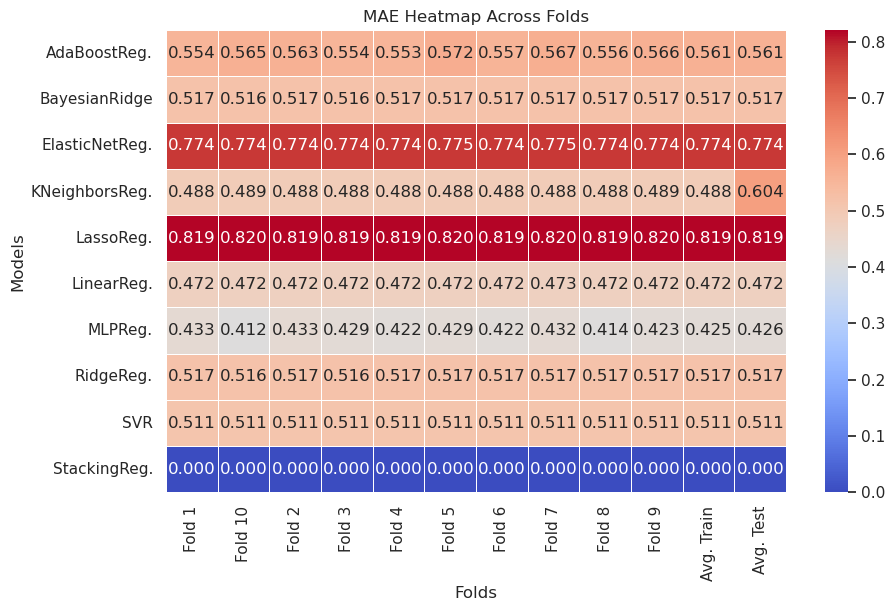

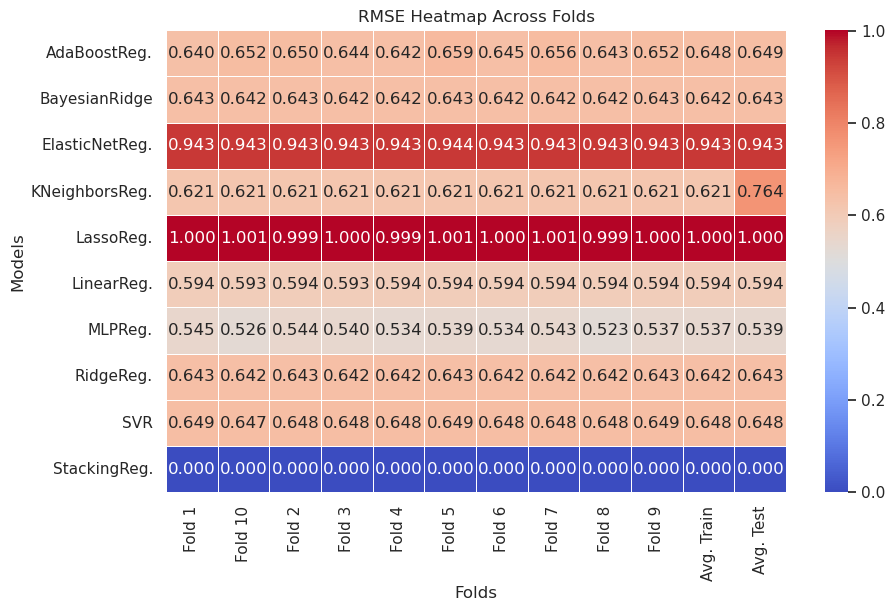

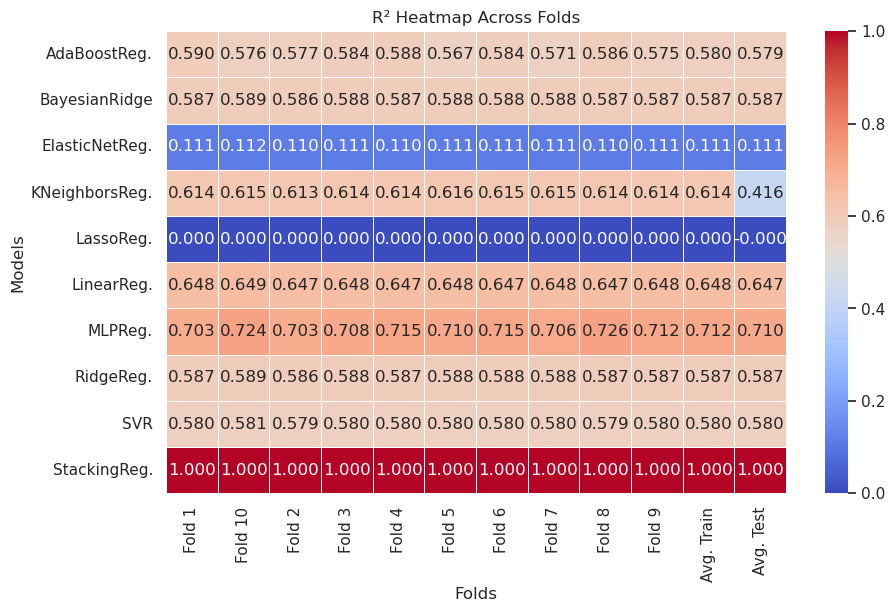

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Remove the 'STD' fold if it exists in the DataFrame
mae_df = mae_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for MAE values
sns.heatmap(mae_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("MAE Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "mae_heat_lumo.png", dpi=300)
plt.show()

rmse_df = rmse_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for RMSE values
sns.heatmap(rmse_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("RMSE Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "rmse_heat_lumo.png", dpi=300)
plt.show()

r2_df = r2_df.drop(columns=["STD"], errors="ignore")

# Set figure size
plt.figure(figsize=(10, 6))

# Create a heatmap for R² values
sns.heatmap(r2_df.set_index("Model"), annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.title("R² Heatmap Across Folds")
plt.xlabel("Folds")
plt.ylabel("Models")
plt.savefig(save_path + "r2_heat_lumo.png", dpi=300)
plt.show()

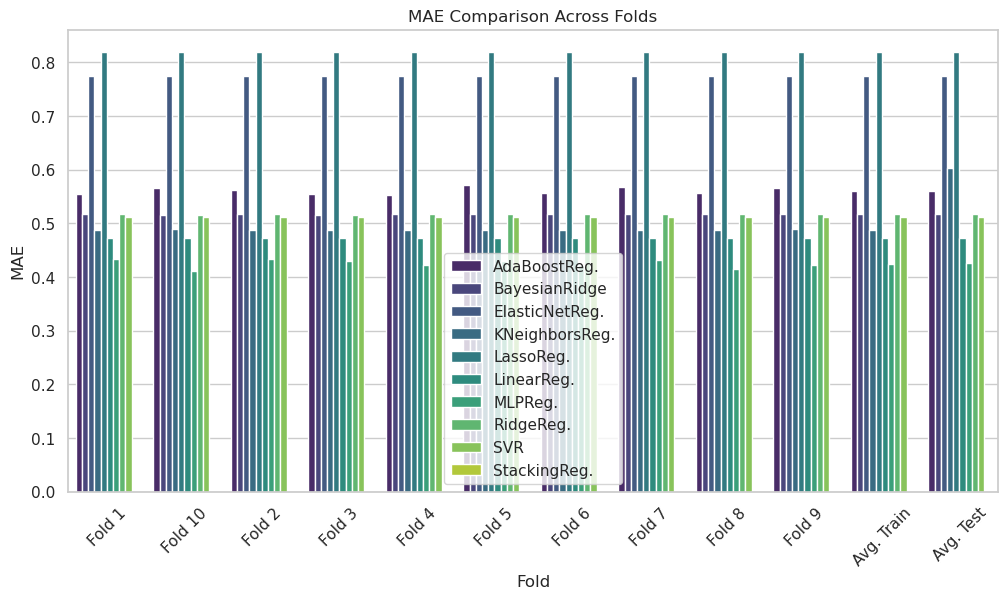

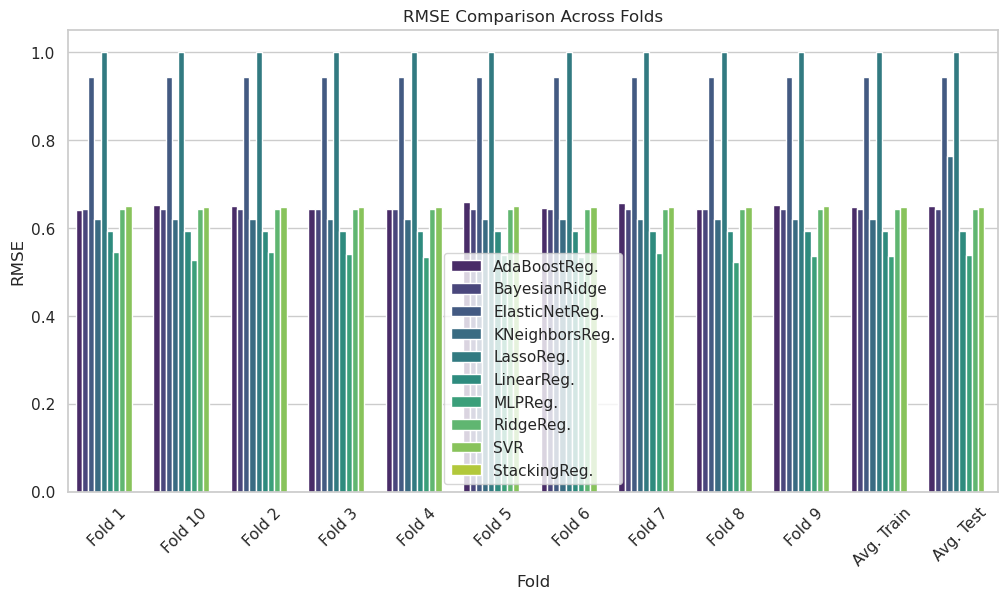

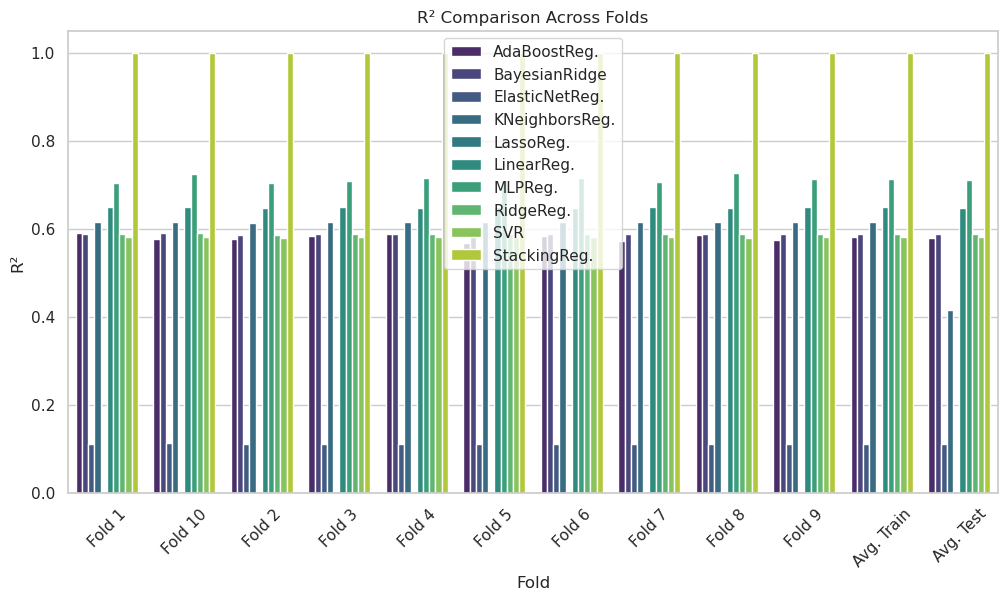

In [79]:
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Remove the 'STD' fold if it exists in the DataFrame
mae_df = mae_df.drop(columns=["STD"], errors="ignore")
mae_df_melted = mae_df.melt(id_vars="Model", var_name="Fold", value_name="MAE")

plt.figure(figsize=(12, 6))
sns.barplot(data=mae_df_melted, x="Fold", y="MAE", hue="Model", palette="viridis")
plt.title("MAE Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "mae_all_folds_lumo.png", dpi=300)
plt.show()

# Remove the 'STD' fold if it exists in the DataFrame
rmse_df = rmse_df.drop(columns=["STD"], errors="ignore")
rmse_df_melted = rmse_df.melt(id_vars="Model", var_name="Fold", value_name="RMSE")

plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df_melted, x="Fold", y="RMSE", hue="Model", palette="viridis")
plt.title("RMSE Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "rmse_all_folds_lumo.png", dpi=300)
plt.show()

# Remove the 'STD' fold if it exists in the DataFrame
r2_df = r2_df.drop(columns=["STD"], errors="ignore")
r2_df_melted = r2_df.melt(id_vars="Model", var_name="Fold", value_name="R²")

plt.figure(figsize=(12, 6))
sns.barplot(data=r2_df_melted, x="Fold", y="R²", hue="Model", palette="viridis")
plt.title("R² Comparison Across Folds")
plt.legend(title=None)
plt.xticks(rotation=45)
plt.savefig(save_path + "r2_all_folds_lumo.png", dpi=300)
plt.show()

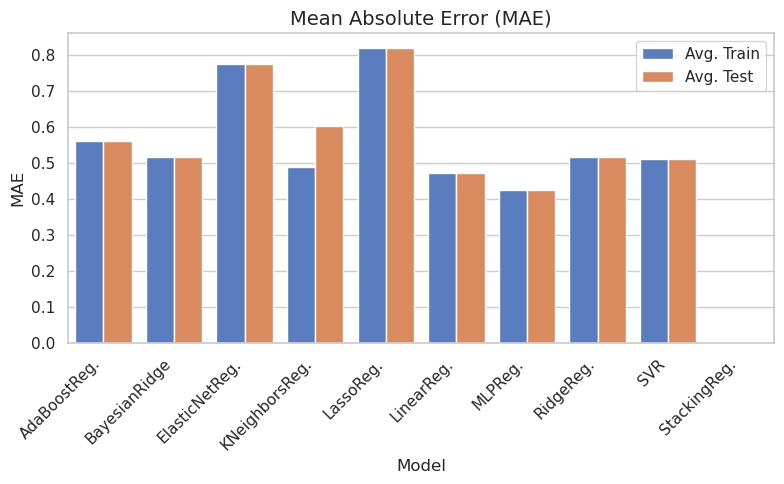

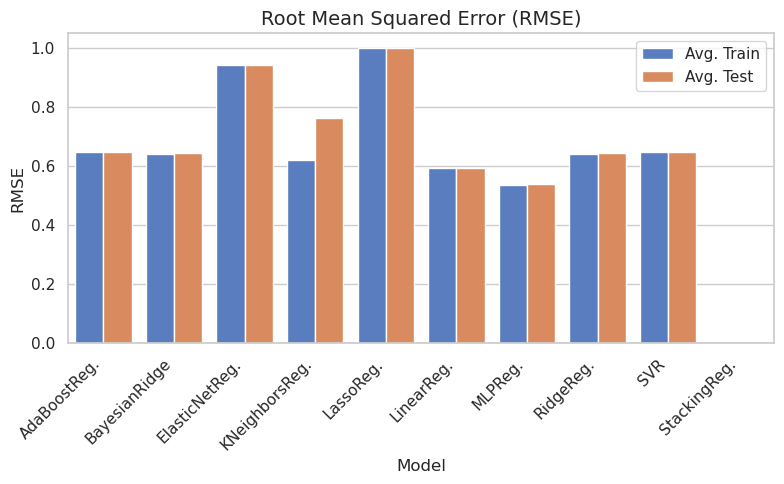

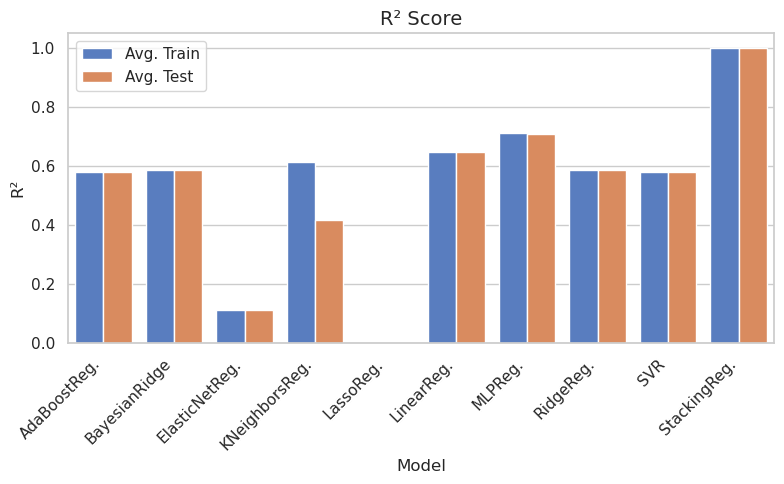

In [80]:
save_path = "/media/omid/HDD2/QM9_sci/10foldnew/250203/"

# Select only the "Model", "Average_tr", and "Average_ts" columns
mae_avg_df = mae_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="MAE")
rmse_avg_df = rmse_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="RMSE")
r2_avg_df = r2_df[["Model", "Avg. Train", "Avg. Test"]].melt(id_vars="Model", var_name="Fold", value_name="R²")

# Set style
sns.set(style="whitegrid")

# Plot MAE
plt.figure(figsize=(8, 5))
sns.barplot(data=mae_avg_df, x="Model", y="MAE", hue="Fold", palette="muted")
plt.title("Mean Absolute Error (MAE)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "mae_avg_tr_ts_lumo.png", dpi=300)
plt.show()

# Plot RMSE
plt.figure(figsize=(8, 5))
sns.barplot(data=rmse_avg_df, x="Model", y="RMSE", hue="Fold", palette="muted")
plt.title("Root Mean Squared Error (RMSE)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "rmse_avg_tr_ts_lumo.png", dpi=300)
plt.show()

# Plot R²
plt.figure(figsize=(8, 5))
sns.barplot(data=r2_avg_df, x="Model", y="R²", hue="Fold", palette="muted")
plt.title("R² Score", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title=None)
plt.tight_layout()
plt.savefig(save_path + "r2_avg_tr_ts_lumo.png", dpi=300)
plt.show()